# Estimate the unit sales of Walmart retail goods

In [674]:
## Project details: https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview/description

In [675]:

%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## OVERVIEW
#### The M5 dataset, generously made available by Walmart, involves the unit sales of various 
#### products sold in the USA, organized in the form of grouped time series. More specifically, 
#### the dataset involves the unit sales of 3,049 products,
#### classified in 3 product categories (Hobbies, Foods, and Household) and 
#### 7 product departments, in which the above-mentioned categories are disaggregated.  
#### The products are sold across ten stores, located in three States (CA, TX, and WI). 
#### In this respect, the bottom-level of the hierarchy, i.e., product-store unit sales 
#### can be mapped across either product categories or geographical regions

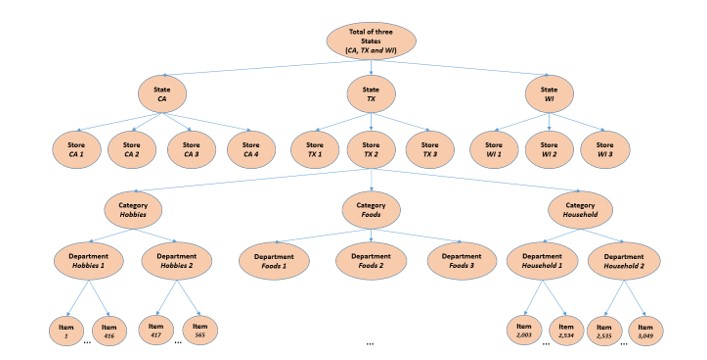

In [676]:
from IPython import display
display.Image("C:\\Users\\ajit2\\Desktop\\Capstone- use this\\Hierarchy.jpg")
#### An overview of how the forecasting Hierarchy is organized.

In [677]:
# Ignore harmless warnings

In [678]:

import warnings
warnings.filterwarnings("ignore")

In [679]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
import gc
from matplotlib import dates
from statsmodels.tsa.seasonal import STL
import datetime
sns.set_context("talk")
sns.set_style("darkgrid")
import matplotlib as mpl
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.stattools import adfuller

from datasetsforecast.hierarchical import HierarchicalData
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import  BottomUp, TopDown, MiddleOut, MinTrace, ERM
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from tqdm.autonotebook import tqdm

from matplotlib import dates
from datetime import datetime
from datetime import timedelta, date
import matplotlib.dates as mdates


from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import math
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor

In [680]:
# for plotting with in the Jupyter notebook

In [681]:
gc.collect()

139576

### Importing files

In [682]:
sell_prices = pd.read_csv("C:\\Users\\ajit2\\Desktop\\Capstone- use this\\sell_prices.csv")
calendar = pd.read_csv("C:\\Users\\ajit2\\Desktop\\Capstone- use this\\calendar.csv",parse_dates=True)
sales=pd.read_csv("C:\\Users\\ajit2\\Desktop\\Capstone- use this\\sales_train_evaluation.csv")

In [683]:
sales.head(10)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   
5  HOBBIES_1_006_CA_1_evaluation  HOBBIES_1_006  HOBBIES_1  HOBBIES     CA_1   
6  HOBBIES_1_007_CA_1_evaluation  HOBBIES_1_007  HOBBIES_1  HOBBIES     CA_1   
7  HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
8  HOBBIES_1_009_CA_1_evaluation  HOBBIES_1_009  HOBBIES_1  HOBBIES     CA_1   
9  HOBBIES_1_010_CA_1_evaluation  HOBBIES_1_010  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  d_1935  d_1936  \
0       CA    0    0    0    0  ...       2       4       0       0       0   
1       CA    0    0    0    0  ...       0       1       2       1       1   
2       CA    0    0    0    0  ...       1       0       2       0       0   
3       CA    0    0    0    0  ...       1       1       0       4       0   
4       CA    0    0    0    0  ...       0       0       0       2       1   
5       CA    0    0    0    0  ...       2       1       0       0       1   
6       CA    0    0    0    0  ...       0       1       0       0       0   
7       CA   12   15    0    0  ...       7       0       6       0      15   
8       CA    2    0    7    3  ...       1       0       0       0       0   
9       CA    0    0    1    0  ...       0       0       1       0       2   

   d_1937  d_1938  d_1939  d_1940  d_1941  
0       0       3       3       0       1  
1       0       0       0       0       0  
2       0       2       3       0       1  
3       1       3       0       2       6  
4       0       0       2       1       0  
5       0       0       5       2       0  
6       1       0       1       1       0  
7       5       4       1      40      32  
8       0       0       0       1       0  
9       1       1       0       0       1  

[10 rows x 1947 columns]

In [684]:
sell_prices.head(5)

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [685]:
df=sales.drop(['id','dept_id','state_id'],axis=1)
df

item_id   cat_id store_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  \
0      HOBBIES_1_001  HOBBIES     CA_1    0    0    0    0    0    0    0   
1      HOBBIES_1_002  HOBBIES     CA_1    0    0    0    0    0    0    0   
2      HOBBIES_1_003  HOBBIES     CA_1    0    0    0    0    0    0    0   
3      HOBBIES_1_004  HOBBIES     CA_1    0    0    0    0    0    0    0   
4      HOBBIES_1_005  HOBBIES     CA_1    0    0    0    0    0    0    0   
...              ...      ...      ...  ...  ...  ...  ...  ...  ...  ...   
30485    FOODS_3_823    FOODS     WI_3    0    0    2    2    0    3    1   
30486    FOODS_3_824    FOODS     WI_3    0    0    0    0    0    5    0   
30487    FOODS_3_825    FOODS     WI_3    0    6    0    2    2    4    1   
30488    FOODS_3_826    FOODS     WI_3    0    0    0    0    0    0    0   
30489    FOODS_3_827    FOODS     WI_3    0    0    0    0    0    0    0   

       ...  d_1932  d_1933  d_1934  d_1935  d_1936  d_1937  d_1938  d_1939  \
0      ...       2       4       0       0       0       0       3       3   
1      ...       0       1       2       1       1       0       0       0   
2      ...       1       0       2       0       0       0       2       3   
3      ...       1       1       0       4       0       1       3       0   
4      ...       0       0       0       2       1       0       0       2   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
30485  ...       1       0       3       0       1       1       0       0   
30486  ...       0       0       0       0       0       0       1       0   
30487  ...       0       0       1       2       0       1       0       1   
30488  ...       1       1       1       4       6       0       1       1   
30489  ...       1       2       0       5       4       0       2       2   

       d_1940  d_1941  
0           0       1  
1           0       0  
2           0       1  
3           2       6  
4           1       0  
...       ...     ...  
30485       1       1  
30486       1       0  
30487       0       2  
30488       1       0  
30489       5       1  

[30490 rows x 1944 columns]

In [686]:
gc.collect()

0

## 1.Plotting Aggregate unit Sales per Stores

In [687]:
store_ids = sales['store_id'].values
state_id = []

for id in store_ids:
    state_id.append(id[:2])
state_id = np.array(state_id)
sales['state_id'] = state_id

df_grouped_statewise = sales.groupby('state_id')

In [688]:
#sales['state_id']

In [689]:
#df_grouped_statewise 

In [690]:
date_cols = [c for c in sales.columns if 'd_' in c]

In [691]:
date_range = calendar['date']
d_st = date_range.values[0]
d_end = date_range.values[1940]
date_range = pd.date_range(start=d_st, end=d_end)
date_range

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', length=1941, freq='D')

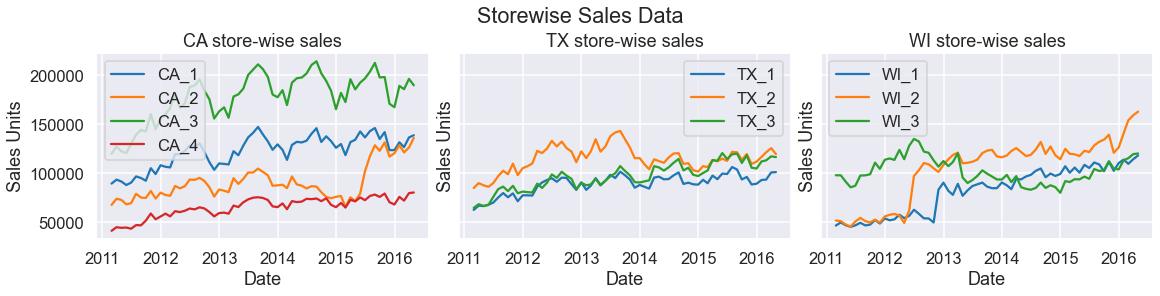

In [692]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharey=True, constrained_layout=True)
fig.suptitle('Storewise Sales Data')
i = 0
for state_name, state_group in df_grouped_statewise:
    df_store_wise_grouped = state_group.groupby('store_id')
    axs[i].set_title('%s store-wise sales' % state_name)
    axs[i].set(xlabel='Date', ylabel='Sales Units')
    axs[i].grid(True)
    for store_name, store_group in df_store_wise_grouped:
        aggr_array = []
        for d in date_cols:
            aggr_array.append(store_group[d].values.sum())
        daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
        monthly_time_seies_df = daily_time_series_df.resample('1M').sum()
        axs[i].plot(monthly_time_seies_df.index[1:-1], monthly_time_seies_df['Sales'].values[1:-1], label='%s' % store_name)
        axs[i].legend()
    i += 1

plt.show()

In [693]:
gc.collect()

458

In [694]:
# transforming to a tall dataframe

In [695]:
df1=df.melt(id_vars=['store_id','item_id','cat_id'],var_name='d',value_name='unit_sales')
df1

store_id        item_id   cat_id       d  unit_sales
0            CA_1  HOBBIES_1_001  HOBBIES     d_1           0
1            CA_1  HOBBIES_1_002  HOBBIES     d_1           0
2            CA_1  HOBBIES_1_003  HOBBIES     d_1           0
3            CA_1  HOBBIES_1_004  HOBBIES     d_1           0
4            CA_1  HOBBIES_1_005  HOBBIES     d_1           0
...           ...            ...      ...     ...         ...
59181085     WI_3    FOODS_3_823    FOODS  d_1941           1
59181086     WI_3    FOODS_3_824    FOODS  d_1941           0
59181087     WI_3    FOODS_3_825    FOODS  d_1941           2
59181088     WI_3    FOODS_3_826    FOODS  d_1941           0
59181089     WI_3    FOODS_3_827    FOODS  d_1941           1

[59181090 rows x 5 columns]

In [696]:
gc.collect()

0

In [697]:
#store_daily_sales_summary=sales.iloc[:,4:].groupby(['store_id','item_id']).sum()

# 2.Selecting CA_3 store for reduced size of data for faster computation

In [698]:

df1_CA_3=df1.query('store_id=="CA_3"')

In [699]:
## merging with calendar

In [700]:
df_final= pd.merge(left=df1_CA_3,right=calendar,how='left',left_on=['d'],right_on=['d'])
df_final

store_id        item_id   cat_id       d  unit_sales        date  \
0           CA_3  HOBBIES_1_001  HOBBIES     d_1           0  2011-01-29   
1           CA_3  HOBBIES_1_002  HOBBIES     d_1           0  2011-01-29   
2           CA_3  HOBBIES_1_003  HOBBIES     d_1           0  2011-01-29   
3           CA_3  HOBBIES_1_004  HOBBIES     d_1           0  2011-01-29   
4           CA_3  HOBBIES_1_005  HOBBIES     d_1           0  2011-01-29   
...          ...            ...      ...     ...         ...         ...   
5918104     CA_3    FOODS_3_823    FOODS  d_1941           2  2016-05-22   
5918105     CA_3    FOODS_3_824    FOODS  d_1941           0  2016-05-22   
5918106     CA_3    FOODS_3_825    FOODS  d_1941           1  2016-05-22   
5918107     CA_3    FOODS_3_826    FOODS  d_1941           0  2016-05-22   
5918108     CA_3    FOODS_3_827    FOODS  d_1941           0  2016-05-22   

         wm_yr_wk   weekday  wday  month  year event_name_1 event_type_1  \
0           11101  Saturday     1      1  2011          NaN          NaN   
1           11101  Saturday     1      1  2011          NaN          NaN   
2           11101  Saturday     1      1  2011          NaN          NaN   
3           11101  Saturday     1      1  2011          NaN          NaN   
4           11101  Saturday     1      1  2011          NaN          NaN   
...           ...       ...   ...    ...   ...          ...          ...   
5918104     11617    Sunday     2      5  2016          NaN          NaN   
5918105     11617    Sunday     2      5  2016          NaN          NaN   
5918106     11617    Sunday     2      5  2016          NaN          NaN   
5918107     11617    Sunday     2      5  2016          NaN          NaN   
5918108     11617    Sunday     2      5  2016          NaN          NaN   

        event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0                NaN          NaN        0        0        0  
1                NaN          NaN        0        0        0  
2                NaN          NaN        0        0        0  
3                NaN          NaN        0        0        0  
4                NaN          NaN        0        0        0  
...              ...          ...      ...      ...      ...  
5918104          NaN          NaN        0        0        0  
5918105          NaN          NaN        0        0        0  
5918106          NaN          NaN        0        0        0  
5918107          NaN          NaN        0        0        0  
5918108          NaN          NaN        0        0        0  

[5918109 rows x 18 columns]

In [701]:
gc.collect()

0

In [702]:
# creating a subset of dataframe

In [703]:
df_final_weekly_sales=df_final[['store_id','item_id','cat_id','wm_yr_wk','unit_sales']]\
.groupby(['store_id','item_id','cat_id','wm_yr_wk']).sum().reset_index()
df_final_weekly_sales

store_id          item_id     cat_id  wm_yr_wk  unit_sales
0          CA_3      FOODS_1_001      FOODS     11101           8
1          CA_3      FOODS_1_001      FOODS     11102           9
2          CA_3      FOODS_1_001      FOODS     11103          17
3          CA_3      FOODS_1_001      FOODS     11104           6
4          CA_3      FOODS_1_001      FOODS     11105          18
...         ...              ...        ...       ...         ...
847617     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11613           2
847618     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11614           0
847619     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11615           1
847620     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11616           2
847621     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11617           0

[847622 rows x 5 columns]

In [704]:
sell_prices.head(25)

store_id        item_id  wm_yr_wk  sell_price
0      CA_1  HOBBIES_1_001     11325        9.58
1      CA_1  HOBBIES_1_001     11326        9.58
2      CA_1  HOBBIES_1_001     11327        8.26
3      CA_1  HOBBIES_1_001     11328        8.26
4      CA_1  HOBBIES_1_001     11329        8.26
5      CA_1  HOBBIES_1_001     11330        8.26
6      CA_1  HOBBIES_1_001     11331        8.26
7      CA_1  HOBBIES_1_001     11332        8.26
8      CA_1  HOBBIES_1_001     11333        8.26
9      CA_1  HOBBIES_1_001     11334        8.26
10     CA_1  HOBBIES_1_001     11335        8.26
11     CA_1  HOBBIES_1_001     11336        8.26
12     CA_1  HOBBIES_1_001     11337        8.26
13     CA_1  HOBBIES_1_001     11338        8.26
14     CA_1  HOBBIES_1_001     11339        8.26
15     CA_1  HOBBIES_1_001     11340        8.26
16     CA_1  HOBBIES_1_001     11341        8.26
17     CA_1  HOBBIES_1_001     11342        8.26
18     CA_1  HOBBIES_1_001     11343        8.26
19     CA_1  HOBBIES_1_001     11344        8.26
20     CA_1  HOBBIES_1_001     11345        8.26
21     CA_1  HOBBIES_1_001     11346        8.26
22     CA_1  HOBBIES_1_001     11347        8.26
23     CA_1  HOBBIES_1_001     11348        8.26
24     CA_1  HOBBIES_1_001     11349        8.26

In [705]:
# merging with sales_price

In [706]:
df_final_with_sales_price= pd.merge(left=df_final_weekly_sales,right=sell_prices,how='left',\
left_on=['store_id','item_id','wm_yr_wk'],right_on=['store_id','item_id','wm_yr_wk'])
df_final_with_sales_price

store_id          item_id     cat_id  wm_yr_wk  unit_sales  sell_price
0          CA_3      FOODS_1_001      FOODS     11101           8        2.00
1          CA_3      FOODS_1_001      FOODS     11102           9        2.00
2          CA_3      FOODS_1_001      FOODS     11103          17        2.00
3          CA_3      FOODS_1_001      FOODS     11104           6        2.00
4          CA_3      FOODS_1_001      FOODS     11105          18        2.00
...         ...              ...        ...       ...         ...         ...
847617     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11613           2        5.94
847618     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11614           0        5.94
847619     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11615           1        5.94
847620     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11616           2        5.94
847621     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11617           0        5.94

[847622 rows x 6 columns]

In [707]:
# checking for Null values

In [708]:
df_final_with_sales_price.isnull().sum()

store_id           0
item_id            0
cat_id             0
wm_yr_wk           0
unit_sales         0
sell_price    165828
dtype: int64

In [709]:
# filling NA values

In [710]:
df_final_with_sales_price['sell_price'] = df_final_with_sales_price['sell_price'].fillna(0)

In [711]:
df_final_with_sales_price['Sales_Revenue']=df_final_with_sales_price['unit_sales']*df_final_with_sales_price['sell_price']

In [712]:
df_final_with_sales_price.isnull().sum()

store_id         0
item_id          0
cat_id           0
wm_yr_wk         0
unit_sales       0
sell_price       0
Sales_Revenue    0
dtype: int64

In [713]:
# joining with calendar

In [714]:
calendar.head(5)

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [715]:
df_final_with_sales_price_WK_YR= pd.merge(left=df_final_with_sales_price,right=calendar[['wm_yr_wk','year']],how='left',left_on=['wm_yr_wk'],right_on=['wm_yr_wk'])
df_final_with_sales_price_WK_YR

store_id          item_id     cat_id  wm_yr_wk  unit_sales  \
0           CA_3      FOODS_1_001      FOODS     11101           8   
1           CA_3      FOODS_1_001      FOODS     11101           8   
2           CA_3      FOODS_1_001      FOODS     11101           8   
3           CA_3      FOODS_1_001      FOODS     11101           8   
4           CA_3      FOODS_1_001      FOODS     11101           8   
...          ...              ...        ...       ...         ...   
5933349     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11617           0   
5933350     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11617           0   
5933351     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11617           0   
5933352     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11617           0   
5933353     CA_3  HOUSEHOLD_2_516  HOUSEHOLD     11617           0   

         sell_price  Sales_Revenue  year  
0              2.00           16.0  2011  
1              2.00           16.0  2011  
2              2.00           16.0  2011  
3              2.00           16.0  2011  
4              2.00           16.0  2011  
...             ...            ...   ...  
5933349        5.94            0.0  2016  
5933350        5.94            0.0  2016  
5933351        5.94            0.0  2016  
5933352        5.94            0.0  2016  
5933353        5.94            0.0  2016  

[5933354 rows x 8 columns]

In [716]:
gc.collect()

0

# 3. Box plot showing median selling price per price category by year - CA_3

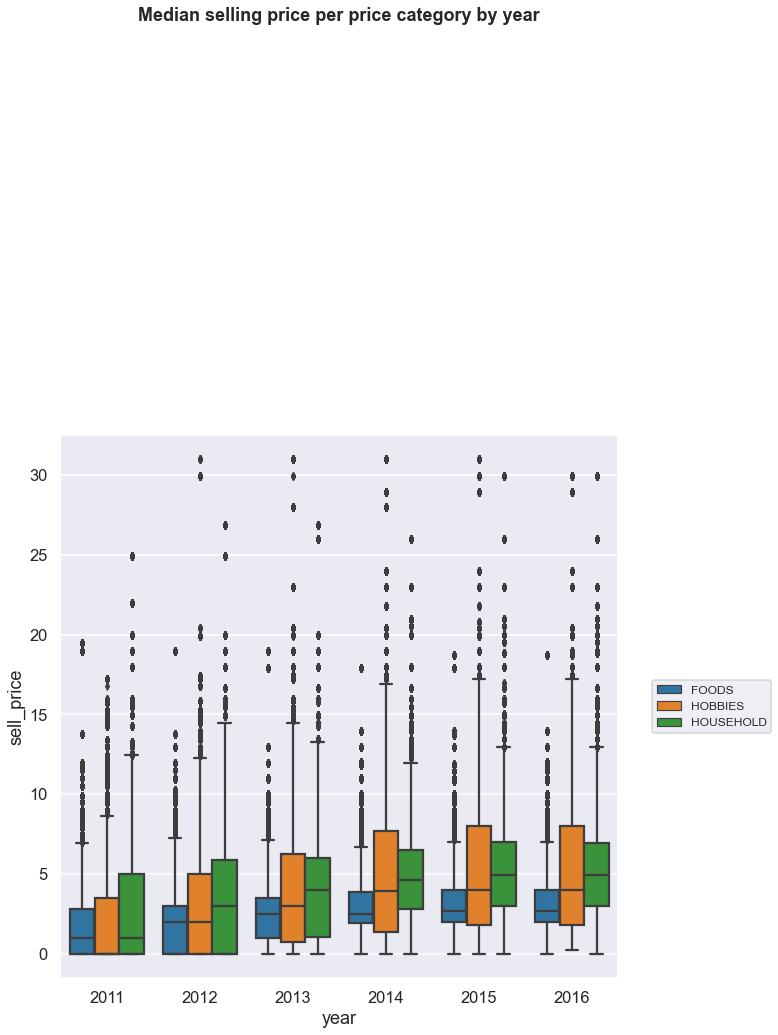

In [717]:
box_plot=sns.boxplot(x="year", y="sell_price", data=df_final_with_sales_price_WK_YR,hue='cat_id')
median = df_final_with_sales_price.groupby(['cat_id'])['sell_price'].median()
#vertical_offset = medians * 0.05 # offset from median for display

#ax.text('2015-7-4', 4250, "Independence Day", ha='center', **style)

# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,median[xtick],median[xtick],ha='center',color='w',weight='semibold')

plt.legend( loc='center left',  bbox_to_anchor=(1.05, 0.5),
           fontsize=12)
plt.title("Median selling price per price category by year",fontweight="bold",fontsize=18,y=1.75);

In [718]:
gc.collect()

8317

In [719]:
len(df_final_with_sales_price_WK_YR.year.unique())

6

In [720]:
dfpie=df_final_with_sales_price_WK_YR.groupby(['cat_id','year'])['Sales_Revenue'].sum().reset_index()
dfpie

cat_id  year  Sales_Revenue
0       FOODS  2011    17455858.71
1       FOODS  2012    24418954.62
2       FOODS  2013    23960798.46
3       FOODS  2014    26754577.12
4       FOODS  2015    26060010.51
5       FOODS  2016    10875669.36
6     HOBBIES  2011     2730983.59
7     HOBBIES  2012     3397499.94
8     HOBBIES  2013     4729902.29
9     HOBBIES  2014     4857610.39
10    HOBBIES  2015     6028742.33
11    HOBBIES  2016     2454444.65
12  HOUSEHOLD  2011     9031495.79
13  HOUSEHOLD  2012    11742670.79
14  HOUSEHOLD  2013    14425002.40
15  HOUSEHOLD  2014    15606353.37
16  HOUSEHOLD  2015    17272285.20
17  HOUSEHOLD  2016     7091104.17

In [721]:
#dfpie.cat_id

In [722]:
# #dfpie=df_final_with_sales_price_WK_YR.groupby['cat_id','year']['Sales_Revenue'].sum()
# #l=df_final_with_sales_price_WK_YR.year.unique()


# x =dfpie.query('year==2011')['cat_id']
# y =dfpie.query('year==2011')['Sales_Revenue']
# colors = ['red','green','blue']
# percent = 100.*y/y.sum()

# patches,texts = plt.pie(y, colors=colors, startangle=90, radius=3)
# labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]

# sort_legend = True
# if sort_legend:
#     patches,labels,dummy =zip(*sorted(zip(patches, labels, y), key=lambda x: x[2],reverse=True))

# plt.legend(patches, labels, loc='center left',  bbox_to_anchor=(2.0, 0.5), fontsize=12)

# plt.savefig('piechart.png', bbox_inches='tight')
# plt.title("Percentage total sales revenue per category",fontweight="bold",fontsize=18,y=1.75);

## 4. Pie chart showing that Food (60%) contributes the highest revenue followed by household (30%) and hobbies (10%)

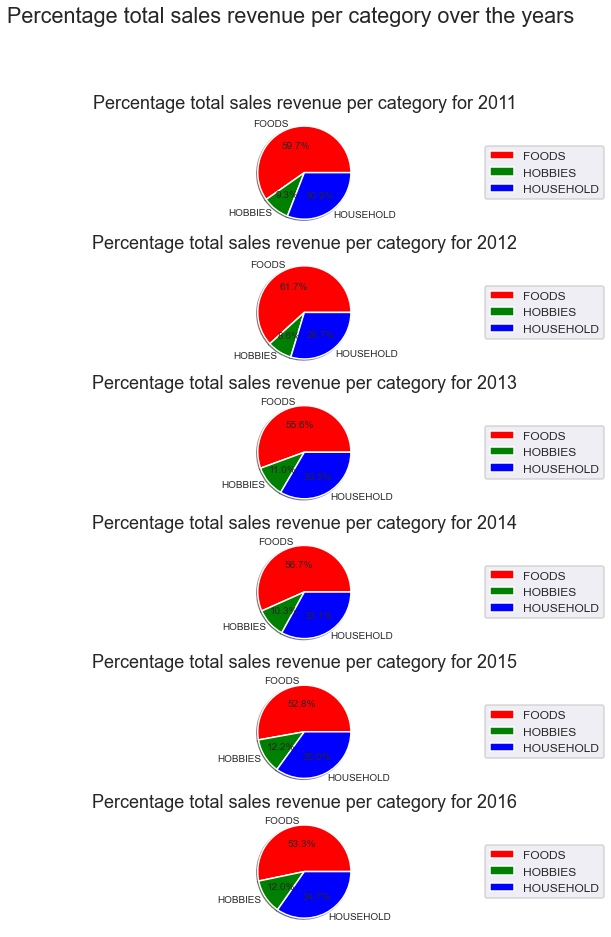

In [723]:
#dfpie=df_final_with_sales_price_WK_YR[['cat_id','Sales_Revenue','year']]
l2=dfpie.year.unique()

#.query(f"month == {ix+1}")
fig,ax = plt.subplots(nrows=len(l2),figsize=(15,15))
ax = ax.flatten()
fig.tight_layout(h_pad=25)
for i in range(len(l2)):
    labels=dfpie.query(f"year=={l2[i]}")['cat_id']
    #data =dfpie.query(f"year=={l2[i]}")['Sales_Revenue']
    colors = ['red','green','blue']
    #percent = 100.*y/y.sum()

    dfpie.query(f"year=={l2[i]}").plot.pie(y='Sales_Revenue',labels = labels,\
        colors = colors,autopct='%0.1f%%', label='',shadow=True,ax=ax[i],fontsize=10)
    #ax[i].pie(data, labels = labels, colors = colors, autopct='%1.1f%%', shadow=True,radius=3)
    ax[i].legend( loc='center left',  bbox_to_anchor=(2.0, 0.5),
           fontsize=12)
    #plt.savefig('piechart.png', bbox_inches='tight')
    ax[i].title.set_text(f"Percentage total sales revenue per category for {l2[i]}")
    
fig.suptitle('Percentage total sales revenue per category over the years');
#plt.subplots_adjust(top=0.85);


In [724]:
gc.collect()

36464

### 5. Identifying A,B,C items i.e. items generating top sales

In [725]:
df_final_with_sales_price_WK_YR.head(101)

store_id      item_id cat_id  wm_yr_wk  unit_sales  sell_price  \
0       CA_3  FOODS_1_001  FOODS     11101           8         2.0   
1       CA_3  FOODS_1_001  FOODS     11101           8         2.0   
2       CA_3  FOODS_1_001  FOODS     11101           8         2.0   
3       CA_3  FOODS_1_001  FOODS     11101           8         2.0   
4       CA_3  FOODS_1_001  FOODS     11101           8         2.0   
..       ...          ...    ...       ...         ...         ...   
96      CA_3  FOODS_1_001  FOODS     11114           9         2.0   
97      CA_3  FOODS_1_001  FOODS     11114           9         2.0   
98      CA_3  FOODS_1_001  FOODS     11115          22         2.0   
99      CA_3  FOODS_1_001  FOODS     11115          22         2.0   
100     CA_3  FOODS_1_001  FOODS     11115          22         2.0   

     Sales_Revenue  year  
0             16.0  2011  
1             16.0  2011  
2             16.0  2011  
3             16.0  2011  
4             16.0  2011  
..             ...   ...  
96            18.0  2011  
97            18.0  2011  
98            44.0  2011  
99            44.0  2011  
100           44.0  2011  

[101 rows x 8 columns]

In [726]:
Item_sales_revenue_sum=df_final_with_sales_price_WK_YR.groupby(['item_id','cat_id']).agg({'Sales_Revenue':'sum'}).sort_values(['Sales_Revenue'],ascending=False)
Item_sales_revenue_sum=Item_sales_revenue_sum.query('Sales_Revenue!=0')

In [727]:
Item_sales_revenue_sum.dropna()

Sales_Revenue
item_id       cat_id                
FOODS_3_120   FOODS       3151755.32
FOODS_3_090   FOODS       2411021.76
FOODS_3_202   FOODS       1550084.06
FOODS_3_586   FOODS       1522381.14
FOODS_2_244   FOODS       1379203.84
...                              ...
HOBBIES_2_030 HOBBIES         570.36
HOBBIES_2_099 HOBBIES         543.20
HOBBIES_2_047 HOBBIES         474.74
HOBBIES_2_023 HOBBIES         420.98
HOBBIES_2_026 HOBBIES         310.73

[3049 rows x 1 columns]

In [728]:
# gettting cumulative sales from the top Item_id's

In [729]:
Item_sales_revenue_sum['grouped_cumulative_sum'] = \
(Item_sales_revenue_sum.Sales_Revenue.cumsum()/Item_sales_revenue_sum.Sales_Revenue.sum())*100
Item_sales_revenue_sum

Sales_Revenue  grouped_cumulative_sum
item_id       cat_id                                        
FOODS_3_120   FOODS       3151755.32                1.376950
FOODS_3_090   FOODS       2411021.76                2.430286
FOODS_3_202   FOODS       1550084.06                3.107492
FOODS_3_586   FOODS       1522381.14                3.772595
FOODS_2_244   FOODS       1379203.84                4.375146
...                              ...                     ...
HOBBIES_2_030 HOBBIES         570.36               99.999236
HOBBIES_2_099 HOBBIES         543.20               99.999473
HOBBIES_2_047 HOBBIES         474.74               99.999680
HOBBIES_2_023 HOBBIES         420.98               99.999864
HOBBIES_2_026 HOBBIES         310.73              100.000000

[3049 rows x 2 columns]

In [730]:
Item_sales_revenue_sum.reset_index(inplace=True)

In [731]:
 Item_sales_revenue_sum

item_id   cat_id  Sales_Revenue  grouped_cumulative_sum
0       FOODS_3_120    FOODS     3151755.32                1.376950
1       FOODS_3_090    FOODS     2411021.76                2.430286
2       FOODS_3_202    FOODS     1550084.06                3.107492
3       FOODS_3_586    FOODS     1522381.14                3.772595
4       FOODS_2_244    FOODS     1379203.84                4.375146
...             ...      ...            ...                     ...
3044  HOBBIES_2_030  HOBBIES         570.36               99.999236
3045  HOBBIES_2_099  HOBBIES         543.20               99.999473
3046  HOBBIES_2_047  HOBBIES         474.74               99.999680
3047  HOBBIES_2_023  HOBBIES         420.98               99.999864
3048  HOBBIES_2_026  HOBBIES         310.73              100.000000

[3049 rows x 4 columns]

In [732]:
Item_sales_revenue_sum.head(1200)

item_id     cat_id  Sales_Revenue  grouped_cumulative_sum
0         FOODS_3_120      FOODS     3151755.32                1.376950
1         FOODS_3_090      FOODS     2411021.76                2.430286
2         FOODS_3_202      FOODS     1550084.06                3.107492
3         FOODS_3_586      FOODS     1522381.14                3.772595
4         FOODS_2_244      FOODS     1379203.84                4.375146
...               ...        ...            ...                     ...
1195  HOUSEHOLD_1_247  HOUSEHOLD       51855.23               81.523164
1196  HOUSEHOLD_1_105  HOUSEHOLD       51813.37               81.545800
1197      FOODS_3_392      FOODS       51802.38               81.568432
1198  HOUSEHOLD_2_491  HOUSEHOLD       51678.76               81.591010
1199      FOODS_2_199      FOODS       51634.66               81.613568

[1200 rows x 4 columns]

In [733]:
gc.collect()

0

In [734]:
Item_sales_revenue_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   item_id                 3049 non-null   object 
 1   cat_id                  3049 non-null   object 
 2   Sales_Revenue           3049 non-null   float64
 3   grouped_cumulative_sum  3049 non-null   float64
dtypes: float64(2), object(2)
memory usage: 95.4+ KB


In [735]:
Item_sales_revenue_sum["Inventory_class"] = np.where(Item_sales_revenue_sum.grouped_cumulative_sum>95,
                                                    "C",
                                       np.where(Item_sales_revenue_sum.grouped_cumulative_sum>80,"B","A"))
                

In [736]:
Item_sales_revenue_sum['item_id'].value_counts().sum()

3049

In [737]:
# plot of top items by inventory class

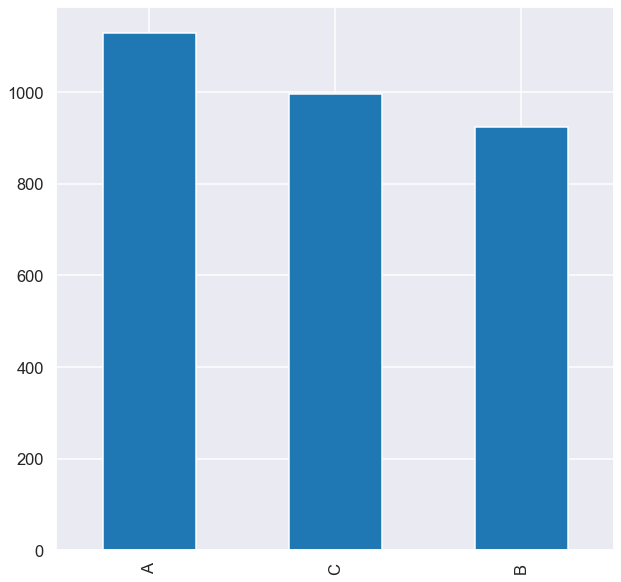

In [738]:
Item_sales_revenue_sum['Inventory_class'].value_counts().plot(kind='bar');

In [739]:
Item_sales_revenue_sum['Inventory_class'].value_counts()

A    1130
C     996
B     923
Name: Inventory_class, dtype: int64

In [740]:
gc.collect()

2892

### 6.Data frame for Summarizing data at store level - Daily time frame

In [741]:
store_daily_sales_summary=sales.iloc[:,4:].groupby('store_id').sum()

In [742]:
store_daily_sales_summary

d_1   d_2   d_3   d_4   d_5   d_6   d_7   d_8   d_9  d_10  ...  \
store_id                                                              ...   
CA_1      4337  4155  2816  3051  2630  3276  3450  5437  4340  3157  ...   
CA_2      3494  3046  2121  2324  1942  2288  2629  3729  2957  2218  ...   
CA_3      4739  4827  3785  4232  3817  4369  4703  5456  5581  4912  ...   
CA_4      1625  1777  1386  1440  1536  1389  1469  1988  1818  1535  ...   
TX_1      2556  2687  1822  2258  1694  2734  1691  2820  2887  2174  ...   
TX_2      3852  3937  2731  2954  2492  3439  2588  3772  3657  2932  ...   
TX_3      3030  3006  2225  2169  1726  2833  1947  2848  2832  2213  ...   
WI_1      2704  2194  1562  1251     2  2049  2815  3248  1674  1355  ...   
WI_2      2256  1922  2018  2522  1175  2244  2232  2643  2140  1836  ...   
WI_3      4038  4198  3317  3211  2132  4590  4486  5991  4850  3240  ...   

          d_1932  d_1933  d_1934  d_1935  d_1936  d_1937  d_1938  d_1939  \
store_id                                                                   
CA_1        4951    6245    6707    4568    3949    3995    4136    4433   
CA_2        4839    6507    6710    4238    3963    3789    4037    4751   
CA_3        6046    7029    7969    5891    5523    5375    5580    5542   
CA_4        2635    3256    3318    3024    2715    2519    2544    2704   
TX_1        3610    3787    5000    3708    3310    3147    2748    3664   
TX_2        4415    4424    5866    4179    4008    3518    3126    4249   
TX_3        4295    4155    5383    4341    4052    3710    3288    4390   
WI_1        3978    5527    5488    3505    3323    3242    3478    3813   
WI_2        5317    7704    7586    5011    4628    4533    4628    4880   
WI_3        3987    5674    5894    3897    3306    3268    3398    4126   

          d_1940  d_1941  
store_id                  
CA_1        5764    6289  
CA_2        7120    6614  
CA_3        7073    8144  
CA_4        3146    3597  
TX_1        4167    4624  
TX_2        4802    5217  
TX_3        4712    4974  
WI_1        5002    5054  
WI_2        5213    5068  
WI_3        4519    4757  

[10 rows x 1941 columns]

### Creating rows for sales total by state and overall for WMT

In [743]:
store_daily_sales_summary.loc['CA_Total']=store_daily_sales_summary.loc[store_daily_sales_summary.index.str.contains('CA')].sum()

In [744]:
store_daily_sales_summary.loc['TX_Total']=store_daily_sales_summary.loc[store_daily_sales_summary.index.str.contains('TX')].sum()

In [745]:
store_daily_sales_summary.loc['WI_Total']=store_daily_sales_summary.loc[store_daily_sales_summary.index.str.contains('WI')].sum()

In [746]:
store_daily_sales_summary.loc['WMT_Total']= store_daily_sales_summary.sum(numeric_only=True, axis=0)

In [747]:
store_daily_sales_summary

d_1    d_2    d_3    d_4    d_5    d_6    d_7    d_8    d_9  \
store_id                                                                   
CA_1        4337   4155   2816   3051   2630   3276   3450   5437   4340   
CA_2        3494   3046   2121   2324   1942   2288   2629   3729   2957   
CA_3        4739   4827   3785   4232   3817   4369   4703   5456   5581   
CA_4        1625   1777   1386   1440   1536   1389   1469   1988   1818   
TX_1        2556   2687   1822   2258   1694   2734   1691   2820   2887   
TX_2        3852   3937   2731   2954   2492   3439   2588   3772   3657   
TX_3        3030   3006   2225   2169   1726   2833   1947   2848   2832   
WI_1        2704   2194   1562   1251      2   2049   2815   3248   1674   
WI_2        2256   1922   2018   2522   1175   2244   2232   2643   2140   
WI_3        4038   4198   3317   3211   2132   4590   4486   5991   4850   
CA_Total   14195  13805  10108  11047   9925  11322  12251  16610  14696   
TX_Total    9438   9630   6778   7381   5912   9006   6226   9440   9376   
WI_Total    8998   8314   6897   6984   3309   8883   9533  11882   8664   
WMT_Total  65262  63498  47566  50824  38292  58422  56020  75864  65472   

            d_10  ...  d_1932  d_1933  d_1934  d_1935  d_1936  d_1937  d_1938  \
store_id          ...                                                           
CA_1        3157  ...    4951    6245    6707    4568    3949    3995    4136   
CA_2        2218  ...    4839    6507    6710    4238    3963    3789    4037   
CA_3        4912  ...    6046    7029    7969    5891    5523    5375    5580   
CA_4        1535  ...    2635    3256    3318    3024    2715    2519    2544   
TX_1        2174  ...    3610    3787    5000    3708    3310    3147    2748   
TX_2        2932  ...    4415    4424    5866    4179    4008    3518    3126   
TX_3        2213  ...    4295    4155    5383    4341    4052    3710    3288   
WI_1        1355  ...    3978    5527    5488    3505    3323    3242    3478   
WI_2        1836  ...    5317    7704    7586    5011    4628    4533    4628   
WI_3        3240  ...    3987    5674    5894    3897    3306    3268    3398   
CA_Total   11822  ...   18471   23037   24704   17721   16150   15678   16297   
TX_Total    7319  ...   12320   12366   16249   12228   11370   10375    9162   
WI_Total    6431  ...   13282   18905   18968   12413   11257   11043   11504   
WMT_Total  51144  ...   88146  108616  119842   84724   77554   74192   73926   

           d_1939  d_1940  d_1941  
store_id                           
CA_1         4433    5764    6289  
CA_2         4751    7120    6614  
CA_3         5542    7073    8144  
CA_4         2704    3146    3597  
TX_1         3664    4167    4624  
TX_2         4249    4802    5217  
TX_3         4390    4712    4974  
WI_1         3813    5002    5054  
WI_2         4880    5213    5068  
WI_3         4126    4519    4757  
CA_Total    17430   23103   24644  
TX_Total    12303   13681   14815  
WI_Total    12819   14734   14879  
WMT_Total   85104  103036  108676  

[14 rows x 1941 columns]

In [748]:
#store_daily_sales_summary=store_daily_sales_summary.reset_index()
#store_daily_sales_summary

### Transposing to make dates along the rows

In [749]:
store_daily_sales_summary_transpose=store_daily_sales_summary.T
store_daily_sales_summary_transpose

store_id  CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3  \
d_1       4337  3494  4739  1625  2556  3852  3030  2704  2256  4038   
d_2       4155  3046  4827  1777  2687  3937  3006  2194  1922  4198   
d_3       2816  2121  3785  1386  1822  2731  2225  1562  2018  3317   
d_4       3051  2324  4232  1440  2258  2954  2169  1251  2522  3211   
d_5       2630  1942  3817  1536  1694  2492  1726     2  1175  2132   
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
d_1937    3995  3789  5375  2519  3147  3518  3710  3242  4533  3268   
d_1938    4136  4037  5580  2544  2748  3126  3288  3478  4628  3398   
d_1939    4433  4751  5542  2704  3664  4249  4390  3813  4880  4126   
d_1940    5764  7120  7073  3146  4167  4802  4712  5002  5213  4519   
d_1941    6289  6614  8144  3597  4624  5217  4974  5054  5068  4757   

store_id  CA_Total  TX_Total  WI_Total  WMT_Total  
d_1          14195      9438      8998      65262  
d_2          13805      9630      8314      63498  
d_3          10108      6778      6897      47566  
d_4          11047      7381      6984      50824  
d_5           9925      5912      3309      38292  
...            ...       ...       ...        ...  
d_1937       15678     10375     11043      74192  
d_1938       16297      9162     11504      73926  
d_1939       17430     12303     12819      85104  
d_1940       23103     13681     14734     103036  
d_1941       24644     14815     14879     108676  

[1941 rows x 14 columns]

### Resetting indexing

In [750]:
store_daily_sales_summary_transpose=store_daily_sales_summary_transpose.reset_index()
store_daily_sales_summary_transpose

store_id   index  CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3  \
0            d_1  4337  3494  4739  1625  2556  3852  3030  2704  2256  4038   
1            d_2  4155  3046  4827  1777  2687  3937  3006  2194  1922  4198   
2            d_3  2816  2121  3785  1386  1822  2731  2225  1562  2018  3317   
3            d_4  3051  2324  4232  1440  2258  2954  2169  1251  2522  3211   
4            d_5  2630  1942  3817  1536  1694  2492  1726     2  1175  2132   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
1936      d_1937  3995  3789  5375  2519  3147  3518  3710  3242  4533  3268   
1937      d_1938  4136  4037  5580  2544  2748  3126  3288  3478  4628  3398   
1938      d_1939  4433  4751  5542  2704  3664  4249  4390  3813  4880  4126   
1939      d_1940  5764  7120  7073  3146  4167  4802  4712  5002  5213  4519   
1940      d_1941  6289  6614  8144  3597  4624  5217  4974  5054  5068  4757   

store_id  CA_Total  TX_Total  WI_Total  WMT_Total  
0            14195      9438      8998      65262  
1            13805      9630      8314      63498  
2            10108      6778      6897      47566  
3            11047      7381      6984      50824  
4             9925      5912      3309      38292  
...            ...       ...       ...        ...  
1936         15678     10375     11043      74192  
1937         16297      9162     11504      73926  
1938         17430     12303     12819      85104  
1939         23103     13681     14734     103036  
1940         24644     14815     14879     108676  

[1941 rows x 15 columns]

### Renaming indexing

In [751]:
store_daily_sales_summary_transpose =store_daily_sales_summary_transpose.rename(columns={'index':'d'})
store_daily_sales_summary_transpose

store_id       d  CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3  \
0            d_1  4337  3494  4739  1625  2556  3852  3030  2704  2256  4038   
1            d_2  4155  3046  4827  1777  2687  3937  3006  2194  1922  4198   
2            d_3  2816  2121  3785  1386  1822  2731  2225  1562  2018  3317   
3            d_4  3051  2324  4232  1440  2258  2954  2169  1251  2522  3211   
4            d_5  2630  1942  3817  1536  1694  2492  1726     2  1175  2132   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
1936      d_1937  3995  3789  5375  2519  3147  3518  3710  3242  4533  3268   
1937      d_1938  4136  4037  5580  2544  2748  3126  3288  3478  4628  3398   
1938      d_1939  4433  4751  5542  2704  3664  4249  4390  3813  4880  4126   
1939      d_1940  5764  7120  7073  3146  4167  4802  4712  5002  5213  4519   
1940      d_1941  6289  6614  8144  3597  4624  5217  4974  5054  5068  4757   

store_id  CA_Total  TX_Total  WI_Total  WMT_Total  
0            14195      9438      8998      65262  
1            13805      9630      8314      63498  
2            10108      6778      6897      47566  
3            11047      7381      6984      50824  
4             9925      5912      3309      38292  
...            ...       ...       ...        ...  
1936         15678     10375     11043      74192  
1937         16297      9162     11504      73926  
1938         17430     12303     12819      85104  
1939         23103     13681     14734     103036  
1940         24644     14815     14879     108676  

[1941 rows x 15 columns]

In [752]:
gc.collect()

0

### Merging with calendar to get the dates and holidays

In [753]:
store_daily_sales_summary_final= pd.merge(left=store_daily_sales_summary_transpose,right=calendar,how='left',left_on=['d'],right_on=['d'])
store_daily_sales_summary_final

d  CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  ...  wday  \
0        d_1  4337  3494  4739  1625  2556  3852  3030  2704  2256  ...     1   
1        d_2  4155  3046  4827  1777  2687  3937  3006  2194  1922  ...     2   
2        d_3  2816  2121  3785  1386  1822  2731  2225  1562  2018  ...     3   
3        d_4  3051  2324  4232  1440  2258  2954  2169  1251  2522  ...     4   
4        d_5  2630  1942  3817  1536  1694  2492  1726     2  1175  ...     5   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1936  d_1937  3995  3789  5375  2519  3147  3518  3710  3242  4533  ...     5   
1937  d_1938  4136  4037  5580  2544  2748  3126  3288  3478  4628  ...     6   
1938  d_1939  4433  4751  5542  2704  3664  4249  4390  3813  4880  ...     7   
1939  d_1940  5764  7120  7073  3146  4167  4802  4712  5002  5213  ...     1   
1940  d_1941  6289  6614  8144  3597  4624  5217  4974  5054  5068  ...     2   

      month  year  event_name_1  event_type_1 event_name_2  event_type_2  \
0         1  2011           NaN           NaN          NaN           NaN   
1         1  2011           NaN           NaN          NaN           NaN   
2         1  2011           NaN           NaN          NaN           NaN   
3         2  2011           NaN           NaN          NaN           NaN   
4         2  2011           NaN           NaN          NaN           NaN   
...     ...   ...           ...           ...          ...           ...   
1936      5  2016           NaN           NaN          NaN           NaN   
1937      5  2016           NaN           NaN          NaN           NaN   
1938      5  2016           NaN           NaN          NaN           NaN   
1939      5  2016           NaN           NaN          NaN           NaN   
1940      5  2016           NaN           NaN          NaN           NaN   

     snap_CA  snap_TX  snap_WI  
0          0        0        0  
1          0        0        0  
2          0        0        0  
3          1        1        0  
4          1        0        1  
...      ...      ...      ...  
1936       0        0        0  
1937       0        0        0  
1938       0        0        0  
1939       0        0        0  
1940       0        0        0  

[1941 rows x 28 columns]

In [754]:
store_daily_sales_summary_final.iloc[:,14:]

WMT_Total        date  wm_yr_wk    weekday  wday  month  year  \
0         65262  2011-01-29     11101   Saturday     1      1  2011   
1         63498  2011-01-30     11101     Sunday     2      1  2011   
2         47566  2011-01-31     11101     Monday     3      1  2011   
3         50824  2011-02-01     11101    Tuesday     4      2  2011   
4         38292  2011-02-02     11101  Wednesday     5      2  2011   
...         ...         ...       ...        ...   ...    ...   ...   
1936      74192  2016-05-18     11616  Wednesday     5      5  2016   
1937      73926  2016-05-19     11616   Thursday     6      5  2016   
1938      85104  2016-05-20     11616     Friday     7      5  2016   
1939     103036  2016-05-21     11617   Saturday     1      5  2016   
1940     108676  2016-05-22     11617     Sunday     2      5  2016   

     event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  \
0             NaN          NaN          NaN          NaN        0        0   
1             NaN          NaN          NaN          NaN        0        0   
2             NaN          NaN          NaN          NaN        0        0   
3             NaN          NaN          NaN          NaN        1        1   
4             NaN          NaN          NaN          NaN        1        0   
...           ...          ...          ...          ...      ...      ...   
1936          NaN          NaN          NaN          NaN        0        0   
1937          NaN          NaN          NaN          NaN        0        0   
1938          NaN          NaN          NaN          NaN        0        0   
1939          NaN          NaN          NaN          NaN        0        0   
1940          NaN          NaN          NaN          NaN        0        0   

      snap_WI  
0           0  
1           0  
2           0  
3           0  
4           1  
...       ...  
1936        0  
1937        0  
1938        0  
1939        0  
1940        0  

[1941 rows x 14 columns]

In [755]:
gc.collect()

0

In [756]:
#store_daily_sales_summary_final['event_name_1']=store_daily_sales_summary_final['event_name_1'].fillna(0)

In [757]:
#store_daily_sales_summary_final

In [758]:
#store_daily_sales_summary_final[store_daily_sales_summary_final['event_name_1'].notna()]

### Combining all the holidays in one column

In [759]:
store_daily_sales_summary_final['Holidays']=store_daily_sales_summary_final['event_name_1']

In [760]:
store_daily_sales_summary_final['Holidays']=store_daily_sales_summary_final['Holidays'].notnull().astype("int")

In [761]:
store_daily_sales_summary_final['Holidays']=store_daily_sales_summary_final['Holidays'].fillna(0)

In [762]:
gc.collect()

0

In [763]:
#store_daily_sales_summary_final['snap_CA'].replace(1,'snap', inplace=True)

In [764]:
store_daily_sales_summary_final.columns

Index(['d', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3', 'CA_Total', 'TX_Total', 'WI_Total', 'WMT_Total', 'date',
       'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'Holidays'],
      dtype='object')

### Resetting the index to date and setting frequence to daily

In [765]:
store_daily_sales_summary_final.set_index('date',inplace=True)

In [766]:
store_daily_sales_summary_final.index=pd.to_datetime(store_daily_sales_summary_final.index)

In [767]:
store_daily_sales_summary_final.index.freq = 'd'

In [768]:
store_daily_sales_summary_final.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', name='date', length=1941, freq='D')

In [769]:
gc.collect()

0

## 7.Summary statistics of sales by various stores and their respective totals

### by Median sales

In [770]:
store_daily_sales_summary_final.head(5)

d  CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  ...  \
date                                                                   ...   
2011-01-29  d_1  4337  3494  4739  1625  2556  3852  3030  2704  2256  ...   
2011-01-30  d_2  4155  3046  4827  1777  2687  3937  3006  2194  1922  ...   
2011-01-31  d_3  2816  2121  3785  1386  1822  2731  2225  1562  2018  ...   
2011-02-01  d_4  3051  2324  4232  1440  2258  2954  2169  1251  2522  ...   
2011-02-02  d_5  2630  1942  3817  1536  1694  2492  1726     2  1175  ...   

            month  year  event_name_1  event_type_1  event_name_2  \
date                                                                
2011-01-29      1  2011           NaN           NaN           NaN   
2011-01-30      1  2011           NaN           NaN           NaN   
2011-01-31      1  2011           NaN           NaN           NaN   
2011-02-01      2  2011           NaN           NaN           NaN   
2011-02-02      2  2011           NaN           NaN           NaN   

            event_type_2 snap_CA  snap_TX  snap_WI  Holidays  
date                                                          
2011-01-29           NaN       0        0        0         0  
2011-01-30           NaN       0        0        0         0  
2011-01-31           NaN       0        0        0         0  
2011-02-01           NaN       1        1        0         0  
2011-02-02           NaN       1        0        1         0  

[5 rows x 28 columns]

In [771]:
df2=pd.melt(store_daily_sales_summary_final[['CA_1', 'CA_2', 'CA_3', 'CA_4',\
'TX_1', 'TX_2','TX_3','WI_1','WI_2', 'WI_3']])
df2.columns=['store_name','unit_sales']


In [772]:
## Plotting Sales data for all stores

''

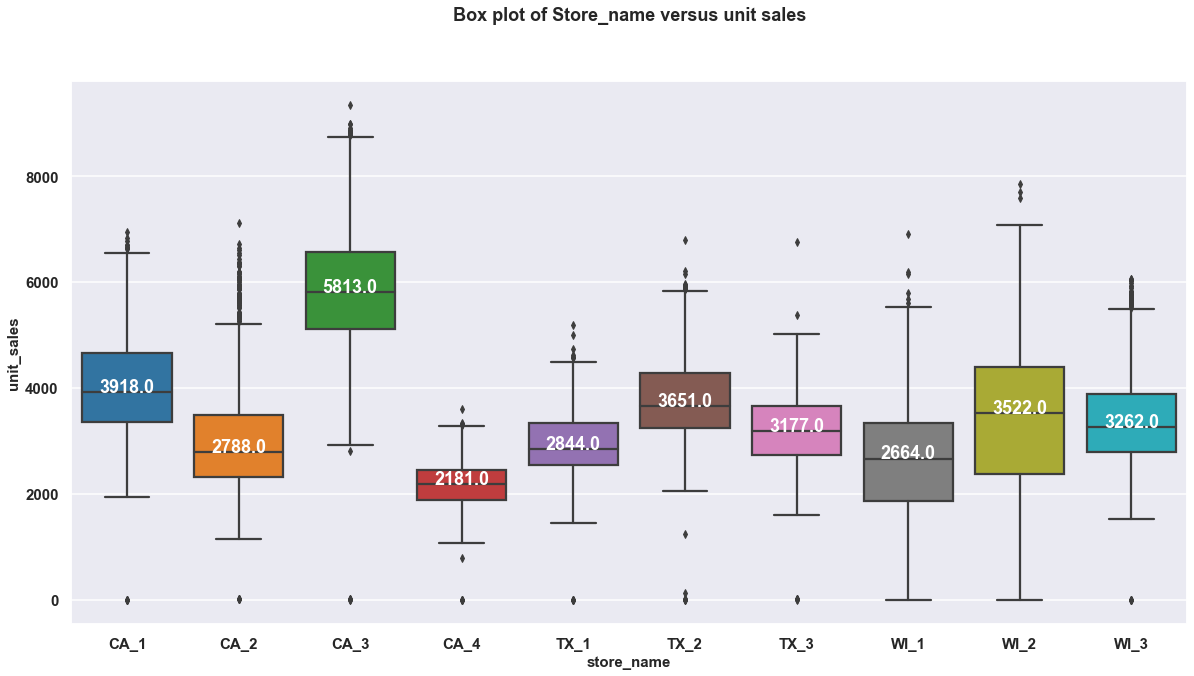

In [773]:
plt.figure(figsize=(20,10))
box_plot=sns.boxplot(x="store_name", y="unit_sales", data=df2)
median = df2.groupby(['store_name'])['unit_sales'].median()
#vertical_offset = medians * 0.05 # offset from median for display

#ax.text('2015-7-4', 4250, "Independence Day", ha='center', **style)

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,median[xtick],median[xtick],ha='center',color='white',weight='bold')
    
plt.xticks(fontweight='bold',fontsize=15)
plt.yticks(fontweight='bold',fontsize=15)
plt.xlabel('store_name', fontweight='bold',fontsize=15)
plt.ylabel('unit_sales', fontweight='bold',fontsize=15)
plt.title("Box plot of Store_name versus unit sales",fontweight="bold",fontsize=18,y=1.1)
;
    

In [774]:
gc.collect()

12041

In [775]:
### Store sales by other measures

In [776]:
summary_statistics=store_daily_sales_summary_final[['CA_1', 'CA_2', 'CA_3', 'CA_4', 'CA_Total','TX_1', 'TX_2',\
        'TX_3','TX_Total', 'WI_1',       'WI_2', 'WI_3', 'WI_Total', 'WMT_Total']].describe().T
summary_statistics

count          mean           std   min      25%      50%  \
CA_1       1941.0   4035.161257    994.891371   0.0   3359.0   3918.0   
CA_2       1941.0   2997.627512    928.407386   2.0   2324.0   2788.0   
CA_3       1941.0   5854.477074   1197.765435   0.0   5112.0   5813.0   
CA_4       1941.0   2154.834621    434.003127   0.0   1885.0   2181.0   
CA_Total   1941.0  15042.100464   3283.724013   5.0  12917.0  14720.0   
TX_1       1941.0   2932.933024    617.853295   0.0   2540.0   2844.0   
TX_2       1941.0   3776.219474    791.389294   0.0   3250.0   3651.0   
TX_3       1941.0   3197.290057    689.250751   1.0   2737.0   3177.0   
TX_Total   1941.0   9906.442555   1973.405599   2.0   8629.0   9665.0   
WI_1       1941.0   2710.719217   1007.099725   0.0   1866.0   2664.0   
WI_2       1941.0   3450.792375   1304.984661   0.0   2376.0   3522.0   
WI_3       1941.0   3370.714580    829.380669   0.0   2789.0   3262.0   
WI_Total   1941.0   9532.226172   2607.255766   1.0   7696.0   9358.0   
WMT_Total  1941.0  68961.538382  14851.813645  22.0  59426.0  67660.0   

               75%       max  
CA_1        4653.0    6948.0  
CA_2        3492.0    7120.0  
CA_3        6572.0    9338.0  
CA_4        2443.0    3597.0  
CA_Total   16963.0   25224.0  
TX_1        3336.0    5190.0  
TX_2        4290.0    6793.0  
TX_3        3650.0    6750.0  
TX_Total   11206.0   18733.0  
WI_1        3336.0    6902.0  
WI_2        4403.0    7852.0  
WI_3        3877.0    6065.0  
WI_Total   11193.0   19669.0  
WMT_Total  78016.0  119842.0

In [777]:
summary_statistics['rank_mean']=summary_statistics['mean'].rank(ascending=False)
summary_statistics['rank_median']=summary_statistics['50%'].rank(ascending=False)
summary_statistics

count          mean           std   min      25%      50%  \
CA_1       1941.0   4035.161257    994.891371   0.0   3359.0   3918.0   
CA_2       1941.0   2997.627512    928.407386   2.0   2324.0   2788.0   
CA_3       1941.0   5854.477074   1197.765435   0.0   5112.0   5813.0   
CA_4       1941.0   2154.834621    434.003127   0.0   1885.0   2181.0   
CA_Total   1941.0  15042.100464   3283.724013   5.0  12917.0  14720.0   
TX_1       1941.0   2932.933024    617.853295   0.0   2540.0   2844.0   
TX_2       1941.0   3776.219474    791.389294   0.0   3250.0   3651.0   
TX_3       1941.0   3197.290057    689.250751   1.0   2737.0   3177.0   
TX_Total   1941.0   9906.442555   1973.405599   2.0   8629.0   9665.0   
WI_1       1941.0   2710.719217   1007.099725   0.0   1866.0   2664.0   
WI_2       1941.0   3450.792375   1304.984661   0.0   2376.0   3522.0   
WI_3       1941.0   3370.714580    829.380669   0.0   2789.0   3262.0   
WI_Total   1941.0   9532.226172   2607.255766   1.0   7696.0   9358.0   
WMT_Total  1941.0  68961.538382  14851.813645  22.0  59426.0  67660.0   

               75%       max  rank_mean  rank_median  
CA_1        4653.0    6948.0        6.0          6.0  
CA_2        3492.0    7120.0       11.0         12.0  
CA_3        6572.0    9338.0        5.0          5.0  
CA_4        2443.0    3597.0       14.0         14.0  
CA_Total   16963.0   25224.0        2.0          2.0  
TX_1        3336.0    5190.0       12.0         11.0  
TX_2        4290.0    6793.0        7.0          7.0  
TX_3        3650.0    6750.0       10.0         10.0  
TX_Total   11206.0   18733.0        3.0          3.0  
WI_1        3336.0    6902.0       13.0         13.0  
WI_2        4403.0    7852.0        8.0          8.0  
WI_3        3877.0    6065.0        9.0          9.0  
WI_Total   11193.0   19669.0        4.0          4.0  
WMT_Total  78016.0  119842.0        1.0          1.0

In [778]:
gc.collect()

0

In [779]:
### from the above we can see that CA_3 is the highest selling store while CA_4 is the lowest by unit sales

In [780]:
store_daily_sales_summary_final.query('Holidays!=0')

d  CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  ...  \
date                                                                      ...   
2011-02-06     d_9  4340  2957  5581  1818  2887  3657  2832  1674  2140  ...   
2011-02-14    d_17  2757  1801  3303  1183  1921  2679  2119  1522  1612  ...   
2011-02-21    d_24  3264  2601  4631  1501  2071  3006  2220   939  1356  ...   
2011-03-09    d_40  2772  2064  3754  1361  2180  2705  2056  1157  1480  ...   
2011-03-16    d_47  2522  2082  3767  1381  1987  2719  2062  1530  1650  ...   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2016-03-27  d_1885  4669  6296  7650  2681  4589  4759  3988  3550  4127  ...   
2016-04-30  d_1919  5898  6349  7057  3023  4052  4508  4134  5318  5485  ...   
2016-05-01  d_1920  6397  6193  7828  3271  4412  4872  4909  5228  5348  ...   
2016-05-05  d_1924  3918  4020  5793  2466  3170  3708  3955  3730  5945  ...   
2016-05-08  d_1927  5212  5330  6743  2675  3196  4035  4154  4059  5802  ...   

            month  year    event_name_1  event_type_1  event_name_2  \
date                                                                  
2011-02-06      2  2011       SuperBowl      Sporting           NaN   
2011-02-14      2  2011   ValentinesDay      Cultural           NaN   
2011-02-21      2  2011   PresidentsDay      National           NaN   
2011-03-09      3  2011       LentStart     Religious           NaN   
2011-03-16      3  2011       LentWeek2     Religious           NaN   
...           ...   ...             ...           ...           ...   
2016-03-27      3  2016          Easter      Cultural           NaN   
2016-04-30      4  2016      Pesach End     Religious           NaN   
2016-05-01      5  2016  OrthodoxEaster     Religious           NaN   
2016-05-05      5  2016   Cinco De Mayo      Cultural           NaN   
2016-05-08      5  2016    Mother's day      Cultural           NaN   

            event_type_2 snap_CA  snap_TX  snap_WI  Holidays  
date                                                          
2011-02-06           NaN       1        1        1         1  
2011-02-14           NaN       0        0        1         1  
2011-02-21           NaN       0        0        0         1  
2011-03-09           NaN       1        1        1         1  
2011-03-16           NaN       0        0        0         1  
...                  ...     ...      ...      ...       ...  
2016-03-27           NaN       0        0        0         1  
2016-04-30           NaN       0        0        0         1  
2016-05-01           NaN       1        1        0         1  
2016-05-05           NaN       1        1        1         1  
2016-05-08           NaN       1        0        1         1  

[158 rows x 28 columns]

## 8. Plotting for sales and holidays for the 3 major states

In [781]:
# getting a summry of all holdays along with sales on that day

In [782]:
df2015holiday =store_daily_sales_summary_final.reset_index().query('Holidays!=0 & date>"01-01-2015" and date<"12-31-2015"')\
[['date','event_name_1','WMT_Total','CA_1','CA_2', 'CA_3', 'CA_4', 'CA_Total','TX_1', 'TX_2', 'TX_3','TX_Total', 'WI_1',
       'WI_2', 'WI_3', 'WI_Total', 'WMT_Total']]
df2015holiday


date         event_name_1  WMT_Total  CA_1  CA_2  CA_3  CA_4  \
1439 2015-01-07    OrthodoxChristmas      58330  3394  2015  4991  1901   
1451 2015-01-19  MartinLutherKingDay      68824  4456  2191  6538  2350   
1464 2015-02-01            SuperBowl      80770  5462  3186  8081  2790   
1477 2015-02-14        ValentinesDay      83228  4789  2613  6239  2383   
1479 2015-02-16        PresidentsDay      74294  4281  2553  6997  2404   
1481 2015-02-18            LentStart      57010  3038  1837  5097  2032   
1488 2015-02-25            LentWeek2      58454  3106  2116  5095  2041   
1496 2015-03-05            Purim End      65638  3660  2041  5881  2224   
1508 2015-03-17        StPatricksDay      62824  3431  1950  5819  1953   
1527 2015-04-05               Easter      83272  4874  3108  7999  2445   
1533 2015-04-11           Pesach End      90544  5495  3189  7093  2599   
1534 2015-04-12       OrthodoxEaster      94360  6093  2940  7907  2696   
1557 2015-05-05        Cinco De Mayo      70178  4168  2077  5835  2529   
1562 2015-05-10         Mother's day      76060  5014  2410  6636  2463   
1577 2015-05-25          MemorialDay      75634  4859  2930  7264  2589   
1587 2015-06-04       NBAFinalsStart      69844  3818  2755  5871  2502   
1599 2015-06-16         NBAFinalsEnd      63396  3792  2753  5408  2341   
1601 2015-06-18       Ramadan starts      68850  4018  3109  5732  2409   
1604 2015-06-21         Father's day      82826  4881  4333  6739  2582   
1617 2015-07-04      IndependenceDay      74978  4434  3647  6237  2217   
1631 2015-07-18          Eid al-Fitr      91320  5133  5344  7397  2533   
1682 2015-09-07             LaborDay      91524  5636  5045  7827  2683   
1699 2015-09-24            EidAlAdha      65934  3430  3405  5404  2371   
1717 2015-10-12          ColumbusDay      84480  4880  3742  7279  2572   
1736 2015-10-31            Halloween      85486  5214  5604  6500  3058   
1747 2015-11-11          VeteransDay      66676  3702  3424  5187  2097   
1762 2015-11-26         Thanksgiving      47262  2160  2265  3674  1471   
1780 2015-12-14         Chanukah End      75044  3989  3504  5568  2418   
1791 2015-12-25            Christmas         28     0     2     4     0   

      CA_Total  TX_1  TX_2  TX_3  TX_Total  WI_1  WI_2  WI_3  WI_Total  \
1439     12301  2837  3467  3109      9413  2233  3229  1989      7451   
1451     15535  3245  3563  3306     10114  3195  2987  2581      8763   
1464     19519  4301  5111  4574     13986  1847  3034  1999      6880   
1477     16024  3566  4196  3973     11735  4812  4850  4193     13855   
1479     16235  2812  3721  3726     10259  3257  4092  3304     10653   
1481     12004  2542  2943  2941      8426  2530  3370  2175      8075   
1488     12358  2461  2981  3207      8649  2707  3231  2282      8220   
1496     13806  2626  2945  3381      8952  3009  4169  2883     10061   
1508     13153  3060  3462  3226      9748  2473  3406  2632      8511   
1527     18426  4561  4475  3753     12789  3167  3691  3563     10421   
1533     18376  3965  4677  4333     12975  4737  4999  4185     13921   
1534     19636  4119  4753  4952     13824  4431  5022  4267     13720   
1557     14609  2869  3291  3604      9764  2997  4483  3236     10716   
1562     16523  3556  3684  4127     11367  3435  3461  3244     10140   
1577     17642  3063  3846  3643     10552  3582  3079  2962      9623   
1587     14946  2810  3416  3669      9895  3327  3931  2823     10081   
1599     14294  2830  2186  2541      7557  2965  3687  3195      9847   
1601     15268  2735  3198  3297      9230  3319  3806  2802      9927   
1604     18535  4430  3936  3907     12273  3784  3546  3275     10605   
1617     16535  3368  3912  3874     11154  3236  3455  3109      9800   
1631     20407  4027  4908  4268     13203  4120  4220  3710     12050   
1682     21191  3619  4851  4304     12774  3556  4338  3903     11797   
1699     14610  2587  3279  3321      9187  2877  3560  27

In [783]:
gc.collect()

24

## Plotting sales of total stores while indicating holidays

In [784]:
## Overall WMT Sales

In [785]:
gc.collect()

0

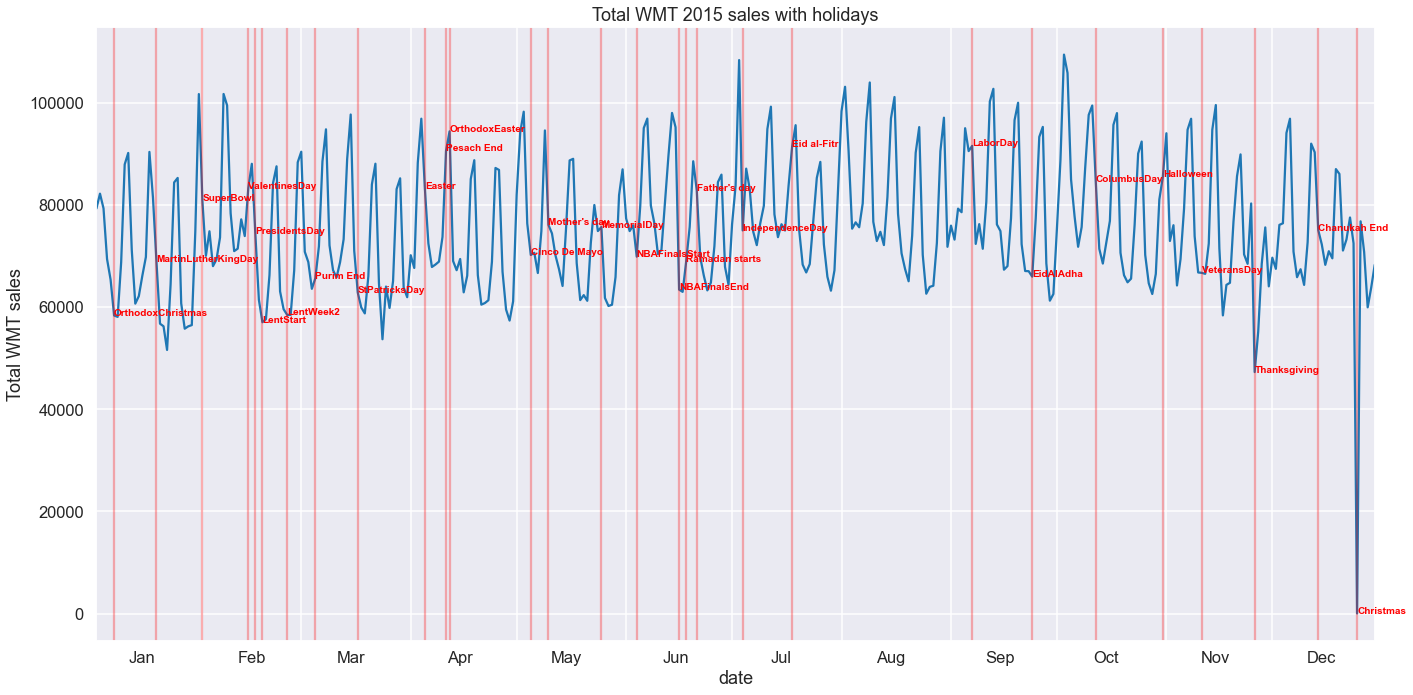

In [786]:

fig,ax = plt.subplots(figsize=(20, 10))
                     

    

store_daily_sales_summary_final.query('date>"01-01-2015" and date<"12-31-2015"')['WMT_Total'].plot(ax=ax)
    
# Add labels to the plot
style = dict(size=10, color='red',weight='bold')

for k in range(len(df2015holiday)):
        
    ax.text(df2015holiday.iloc[k,0],df2015holiday[['date','event_name_1','WMT_Total']].iloc[k,2],df2015holiday.iloc[k,1],\
            **style)
for x in store_daily_sales_summary_final.query('Holidays!=0').index:       # for days where holiday == 1
    ax.axvline(x=x, color='Red', alpha = 0.3);  # add a semi-transparent grey line


# Label the axes
ax.set(title="Total WMT 2015 sales with holidays", ylabel="Total WMT sales")

#Format the x axis with centered month labels
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%h'));
plt.tight_layout()
plt.show()

In [787]:
#CA was the highest-selling state and CA_3 was the highest-selling store. WI was the lowest-selling state.  

In [788]:
gc.collect()

19590

In [789]:
# PLotting CA stores

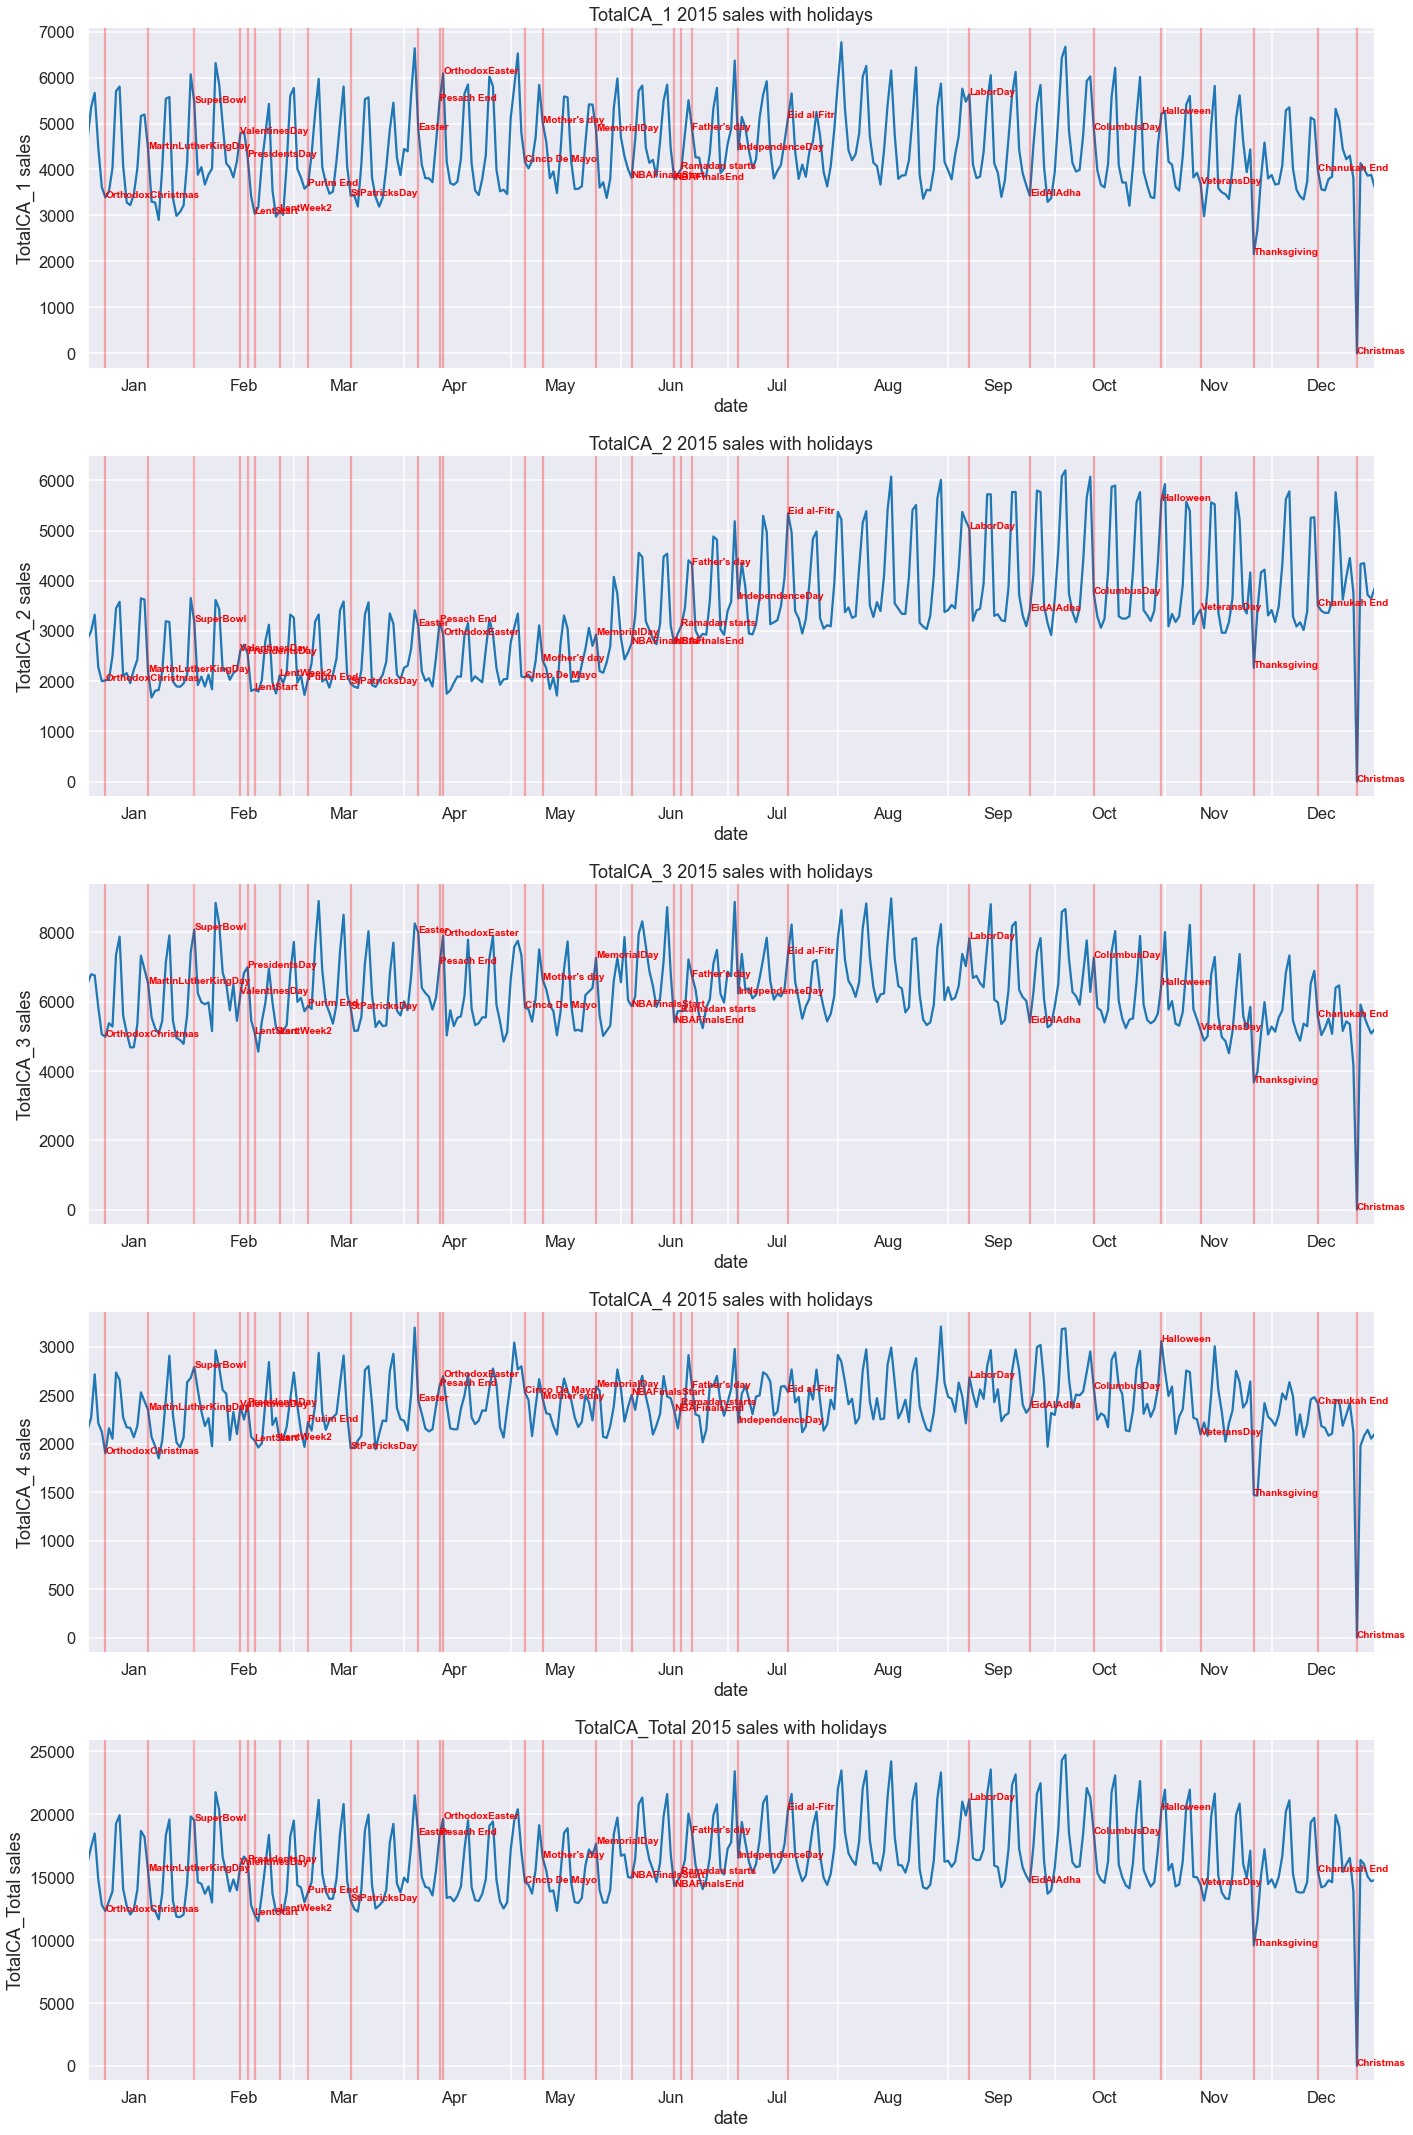

In [790]:
var=['CA_1','CA_2', 'CA_3', 'CA_4', 'CA_Total']
fig,ax = plt.subplots(nrows=len(var), figsize=[20,30] )
for i in range(len(var)):
    

    store_daily_sales_summary_final.query('date>"01-01-2015" and date<"12-31-2015"')[f"{var[i]}"].plot(ax=ax[i])
    
    style = dict(size=10, color='red',weight='bold')

    for k in range(len(df2015holiday)):
        
        ax[i].text(df2015holiday.iloc[k,0],df2015holiday[f"{var[i]}"].iloc[k],df2015holiday.iloc[k,1], **style)
    for x in store_daily_sales_summary_final.query('Holidays!=0').index:       # for days where holiday == 1
        ax[i].axvline(x=x, color='Red', alpha = 0.3);  # add a semi-transparent grey line


# Label the axes
    ax[i].set(title=f"Total{var[i]} 2015 sales with holidays", ylabel=f"Total{var[i]} sales")

# Format the x axis with centered month labels
    ax[i].xaxis.set_major_locator(mpl.dates.MonthLocator())
    ax[i].xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
    ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax[i].xaxis.set_minor_formatter(mpl.dates.DateFormatter('%h'));
fig.tight_layout()
plt.show()
    


In [791]:
gc.collect()

0

In [792]:
## Plotting Texas Stores

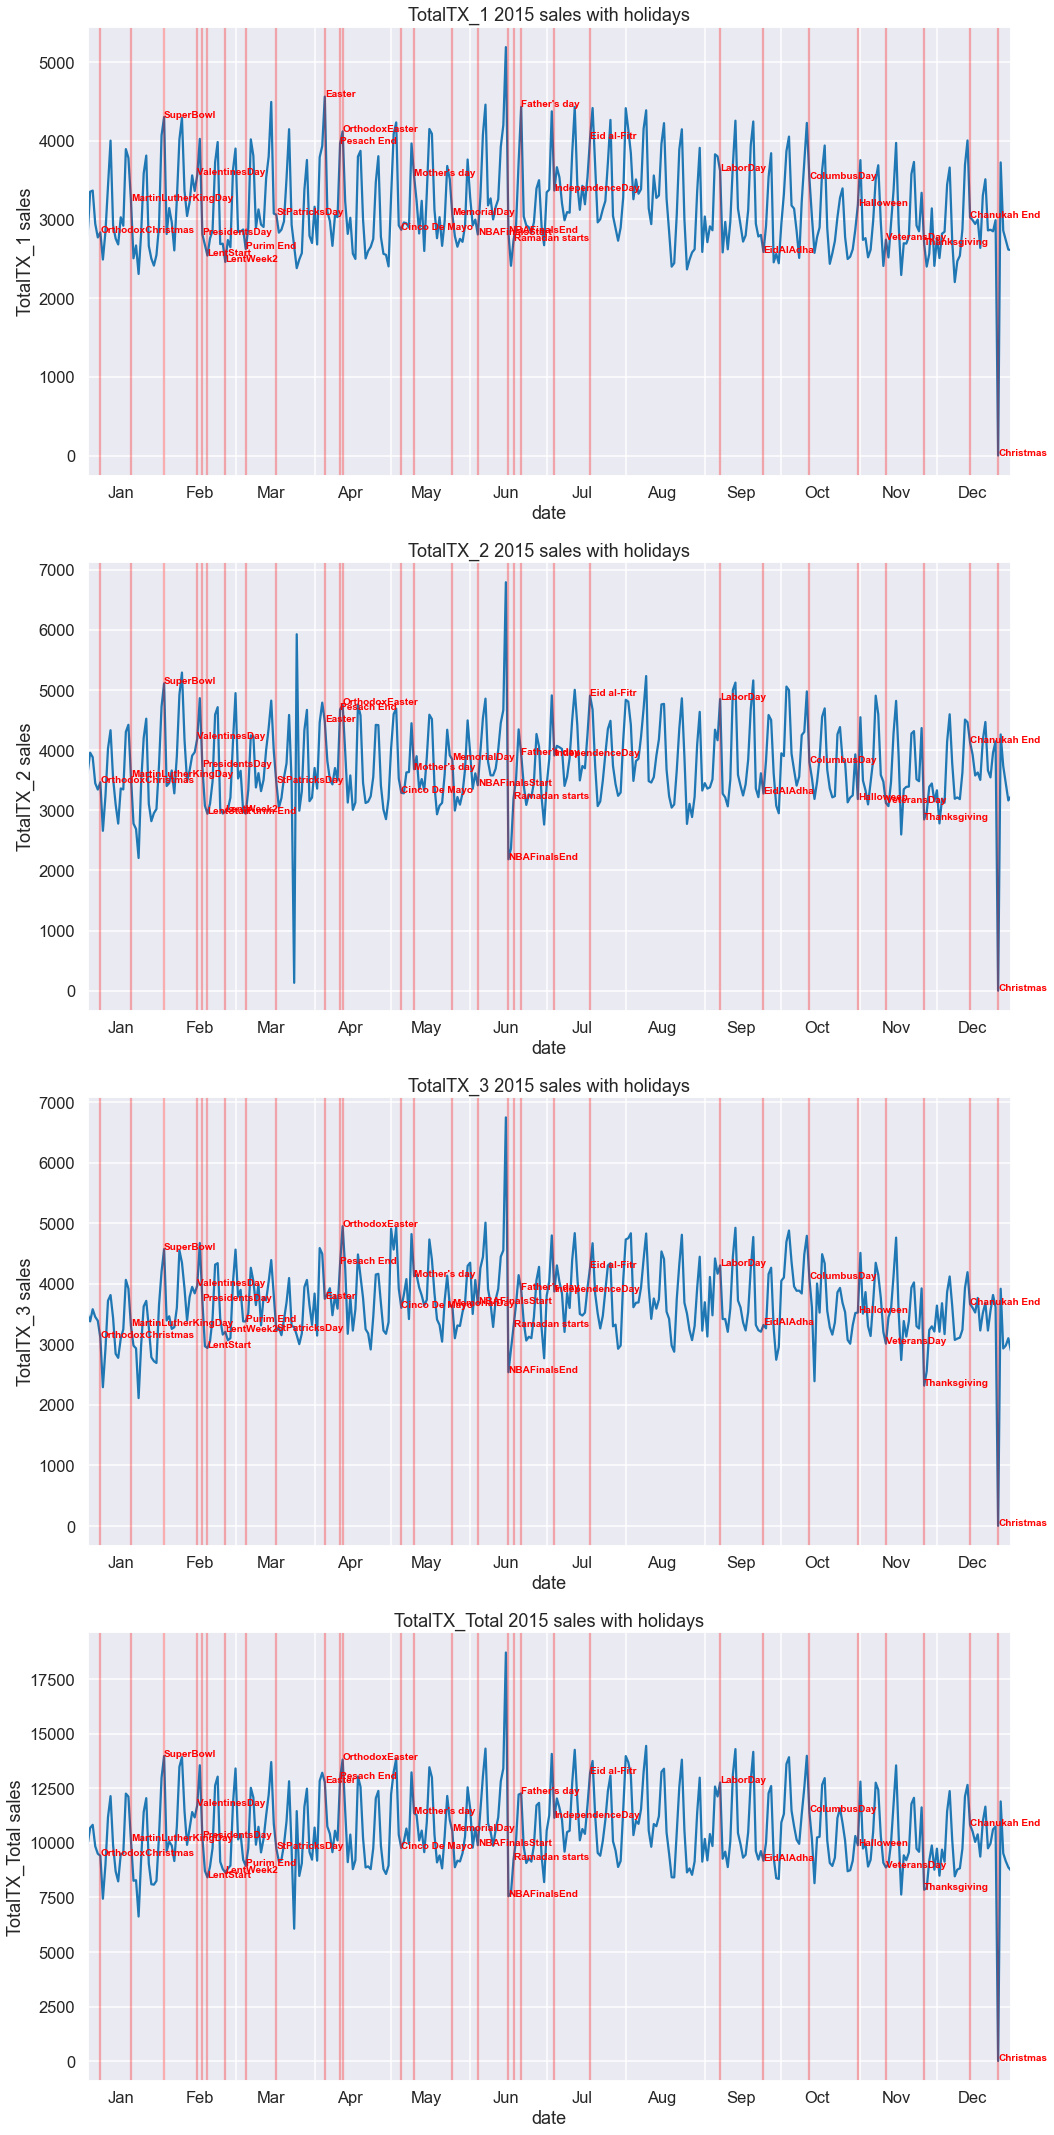

In [793]:
var=['TX_1', 'TX_2', 'TX_3','TX_Total' ]
fig,ax = plt.subplots(nrows=len(var), figsize=[15,30]
                     )
for i in range(len(var)):
    

    store_daily_sales_summary_final.query('date>"01-01-2015" and date<"12-31-2015"')[f"{var[i]}"].plot(ax=ax[i])
    
    style = dict(size=10, color='red',weight='bold')

    for k in range(len(df2015holiday)):
        
        ax[i].text(df2015holiday.iloc[k,0],df2015holiday[f"{var[i]}"].iloc[k],df2015holiday.iloc[k,1], **style)
    for x in store_daily_sales_summary_final.query('Holidays!=0').index:       # for days where holiday == 1
        ax[i].axvline(x=x, color='Red', alpha = 0.3);  # add a semi-transparent grey line

# Label the axes
    ax[i].set(title=f"Total{var[i]} 2015 sales with holidays", ylabel=f"Total{var[i]} sales")

# Format the x axis with centered month labels
    ax[i].xaxis.set_major_locator(mpl.dates.MonthLocator())
    ax[i].xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
    ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax[i].xaxis.set_minor_formatter(mpl.dates.DateFormatter('%h'));
fig.tight_layout()
plt.show()

In [794]:
gc.collect()

102210

In [795]:
## Plotting Wisconsin Stores

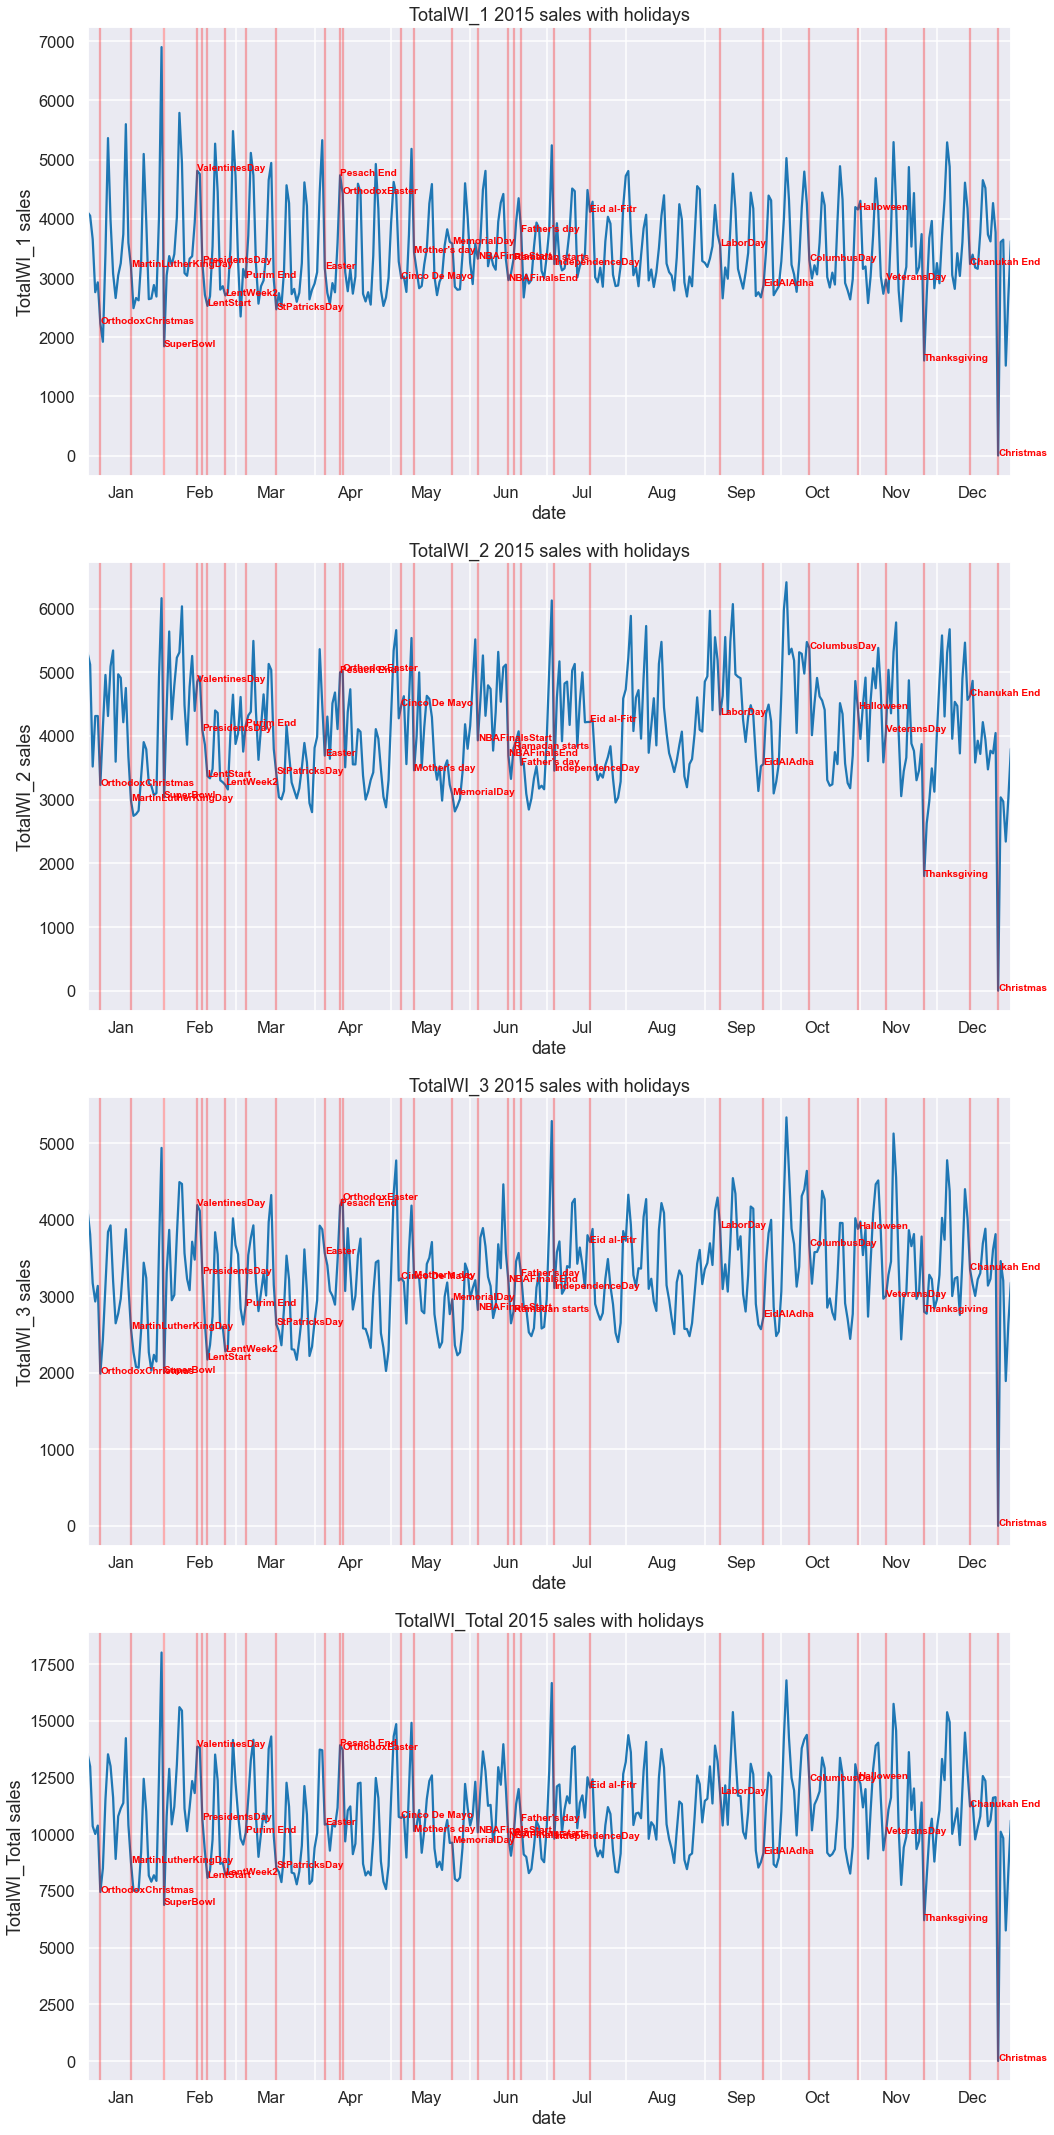

In [796]:
var=[  'WI_1','WI_2', 'WI_3', 'WI_Total' ]
fig,ax = plt.subplots(nrows=len(var),figsize=[15,30] )
for i in range(len(var)):
    

    store_daily_sales_summary_final.query('date>"01-01-2015" and date<"12-31-2015"')[f"{var[i]}"].plot(ax=ax[i])
  
    style = dict(size=10, color='red',weight='bold')

    for k in range(len(df2015holiday)):
        
        ax[i].text(df2015holiday.iloc[k,0],df2015holiday[f"{var[i]}"].iloc[k],df2015holiday.iloc[k,1], **style)
    for x in store_daily_sales_summary_final.query('Holidays!=0').index:       # for days where holiday == 1
        ax[i].axvline(x=x, color='Red', alpha = 0.3);  # add a semi-transparent grey line


# Label the axes
    ax[i].set(title=f"Total{var[i]} 2015 sales with holidays", ylabel=f"Total{var[i]} sales")

# Format the x axis with centered month labels
    ax[i].xaxis.set_major_locator(mpl.dates.MonthLocator())
    ax[i].xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
    ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax[i].xaxis.set_minor_formatter(mpl.dates.DateFormatter('%h'));
fig.tight_layout()
plt.show()

In [797]:
gc.collect()

82079

In [798]:
gc.collect()

0

### 9.Plotting the trend and seasonality

In [799]:
store_daily_sales_summary_final

d  CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  ...  \
date                                                                      ...   
2011-01-29     d_1  4337  3494  4739  1625  2556  3852  3030  2704  2256  ...   
2011-01-30     d_2  4155  3046  4827  1777  2687  3937  3006  2194  1922  ...   
2011-01-31     d_3  2816  2121  3785  1386  1822  2731  2225  1562  2018  ...   
2011-02-01     d_4  3051  2324  4232  1440  2258  2954  2169  1251  2522  ...   
2011-02-02     d_5  2630  1942  3817  1536  1694  2492  1726     2  1175  ...   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2016-05-18  d_1937  3995  3789  5375  2519  3147  3518  3710  3242  4533  ...   
2016-05-19  d_1938  4136  4037  5580  2544  2748  3126  3288  3478  4628  ...   
2016-05-20  d_1939  4433  4751  5542  2704  3664  4249  4390  3813  4880  ...   
2016-05-21  d_1940  5764  7120  7073  3146  4167  4802  4712  5002  5213  ...   
2016-05-22  d_1941  6289  6614  8144  3597  4624  5217  4974  5054  5068  ...   

            month  year  event_name_1  event_type_1  event_name_2  \
date                                                                
2011-01-29      1  2011           NaN           NaN           NaN   
2011-01-30      1  2011           NaN           NaN           NaN   
2011-01-31      1  2011           NaN           NaN           NaN   
2011-02-01      2  2011           NaN           NaN           NaN   
2011-02-02      2  2011           NaN           NaN           NaN   
...           ...   ...           ...           ...           ...   
2016-05-18      5  2016           NaN           NaN           NaN   
2016-05-19      5  2016           NaN           NaN           NaN   
2016-05-20      5  2016           NaN           NaN           NaN   
2016-05-21      5  2016           NaN           NaN           NaN   
2016-05-22      5  2016           NaN           NaN           NaN   

            event_type_2 snap_CA  snap_TX  snap_WI  Holidays  
date                                                          
2011-01-29           NaN       0        0        0         0  
2011-01-30           NaN       0        0        0         0  
2011-01-31           NaN       0        0        0         0  
2011-02-01           NaN       1        1        0         0  
2011-02-02           NaN       1        0        1         0  
...                  ...     ...      ...      ...       ...  
2016-05-18           NaN       0        0        0         0  
2016-05-19           NaN       0        0        0         0  
2016-05-20           NaN       0        0        0         0  
2016-05-21           NaN       0        0        0         0  
2016-05-22           NaN       0        0        0         0  

[1941 rows x 28 columns]

In [800]:
# Compute date time variables used later in plotting
store_daily_sales_summary_final["week"] = store_daily_sales_summary_final.index.isocalendar().week
store_daily_sales_summary_final["day_of_month"] = store_daily_sales_summary_final.index.day
store_daily_sales_summary_final["month"] = store_daily_sales_summary_final.index.month
store_daily_sales_summary_final["year"] = store_daily_sales_summary_final.index.year
store_daily_sales_summary_final["day_of_week"] = store_daily_sales_summary_final.index.dayofweek
store_daily_sales_summary_final["day_of_year"] = store_daily_sales_summary_final.index.dayofyear

In [801]:
timeseries=store_daily_sales_summary_final[['week','day_of_month','month','day_of_week',"year",'CA_3']]\
.query('year>2012 and year<2016')

In [802]:
gc.collect()

3

In [803]:
# for ix, month in enumerate(MONTHS): # Iterate over each month

#     # Plot individual time series for each day 
#     monthly_ts = []
#     for _, ts in ( # Loop over the sales for each day in a given month
#         timeseries[["CA_3", "day_of_month", "month","year"]]
#         .query(f"month == {ix+1}") # Filter timeseries to a single month
#         .groupby("year")  ):
#         ts = ts.reset_index()
#         k=pd.DataFrame(monthly_ts.append(ts["CA_3"]))
#         print(f"_ is {_} /n and \n k is {k}")

In [804]:
#pd.DataFrame(monthly_ts).mean()

# Daily Trend and seasonality plotting

### Daily decomposition of trend and seasonality

In [805]:
# Perform STL decomposition
res = STL(
    endog=store_daily_sales_summary_final["CA_3"],  # Y values
    period=365,  # The periodicity of the seasonal component
    seasonal=211,  # Determines the window size for LOESS used
    # when smoothing the seasonal component
    # (i.e, the cycle-subseries)
    robust=True  # Flag to use robust regression when
    # fitting the LOESS curves so the fit
    # is robust to outliers
).fit()

In [806]:
# Extract the trend and seasonality individually
store_daily_sales_summary_final["CA_3_trend_daily"] = res.trend
store_daily_sales_summary_final["CA_3_seasonal_daily"] = res.seasonal


Text(0, 0.5, 'Seasonal component')

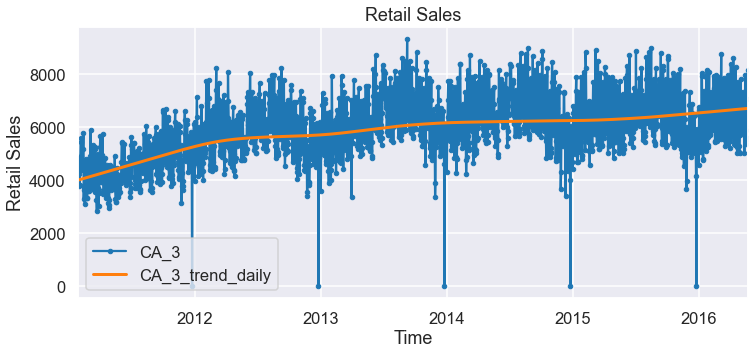

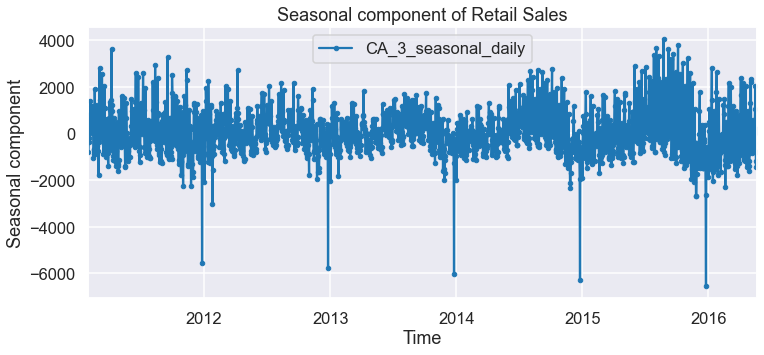

In [807]:
# Plot the full decomposition

# Plot the trend
fig, ax = plt.subplots(figsize=[12, 5])
store_daily_sales_summary_final.plot(y="CA_3", marker=".", ax=ax)
store_daily_sales_summary_final.plot(y="CA_3_trend_daily", ax=ax, linewidth=3)
ax.set_title("Retail Sales")
ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")


# Plot seasonality
fig, ax = plt.subplots(figsize=[12, 5])
store_daily_sales_summary_final.plot(y="CA_3_seasonal_daily", marker=".", ax=ax)
ax.set_title("Seasonal component of Retail Sales")
ax.set_xlabel("Time")
ax.set_ylabel("Seasonal component")

## Plotting daily data for 52 weeks and 3 years

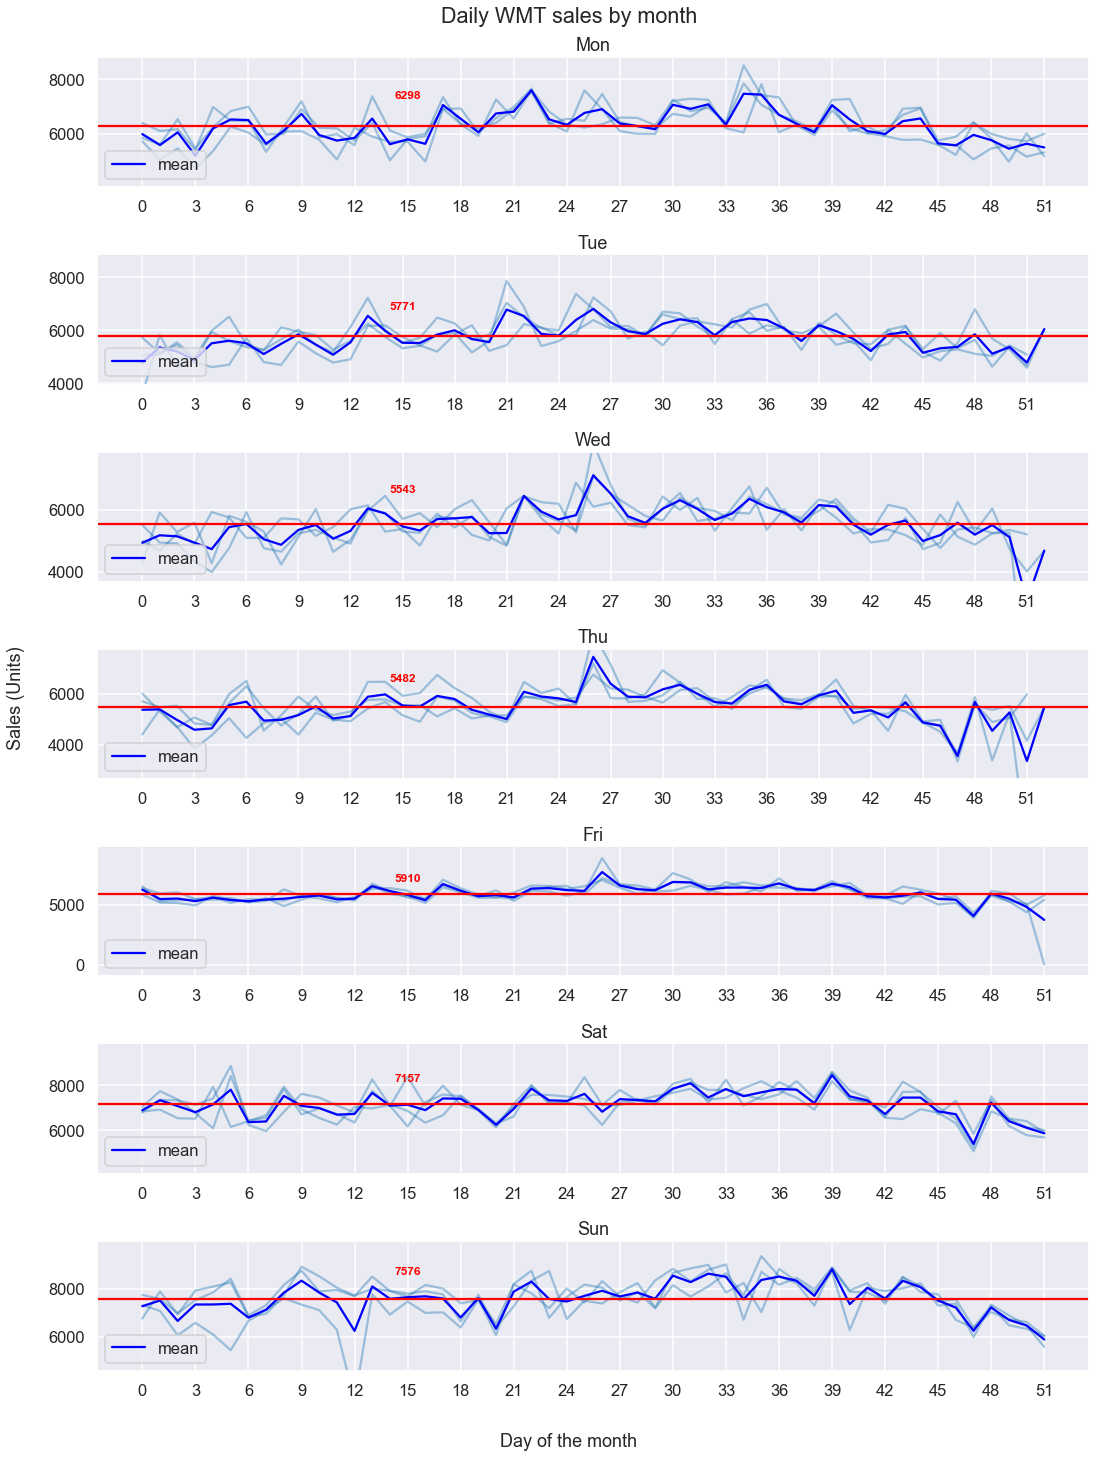

In [808]:
# Plot the Sales for each day in each month,
fig, ax = plt.subplots(nrows=7,figsize=[15, 20], 
                      )
ax = ax.flatten()
sns_blue = sns.color_palette(as_cmap=True)[0] 
DAYS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]


for ix, days in enumerate(DAYS): 
    daily_ts = [] 
    
    for _, ts in (
        timeseries[["CA_3", "day_of_month", "month","year",'day_of_week']]
        .query(f"day_of_week == {ix}")
        .groupby("year") 
    ):
        ts = ts.reset_index()
        daily_ts.append(ts["CA_3"]) 
        ts["CA_3"].plot( 
            alpha=0.4, ax=ax[ix], color=sns_blue, label="_no_legend_"
            )
    style = dict(size=12, color='red',weight='bold')
    ax[ix].text(15, round((pd.concat(daily_ts, axis=1).mean(axis=1)).mean())+1000, \
                round((pd.concat(daily_ts, axis=1).mean(axis=1)).mean()), ha='center',**style)    
    
    ax[ix].set_xticks(range(0,156,3))
              
    ax[ix].set_title(days)
    ax[ix].set_ylim([ts["CA_3"].min()-1000, ts["CA_3"].max()+1000])
    
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(
        ax=ax[ix], color="blue", label="mean", legend=True
    ) 
    
    ax[ix].axhline(y=(pd.concat(daily_ts, axis=1).mean(axis=1)).mean(), color='Red')
    ax[ix].legend(loc="lower left", frameon=True)
    ax[ix].set_xticks(range(0,52,3))
    

fig.text(0.5, -0.02, "Day of the month", ha="center")
fig.text(-0.02, 0.5, "Sales (Units)", va="center", rotation="vertical")
fig.suptitle("Daily WMT sales by month")

fig.tight_layout()

In [809]:
# the plot above show tha tthere is daily seasonality with Sat and Sun being the highest days of sales.

# Weekly data trend and seasonality plotting

In [810]:
store_daily_sales_summary_final

d  CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  ...  \
date                                                                      ...   
2011-01-29     d_1  4337  3494  4739  1625  2556  3852  3030  2704  2256  ...   
2011-01-30     d_2  4155  3046  4827  1777  2687  3937  3006  2194  1922  ...   
2011-01-31     d_3  2816  2121  3785  1386  1822  2731  2225  1562  2018  ...   
2011-02-01     d_4  3051  2324  4232  1440  2258  2954  2169  1251  2522  ...   
2011-02-02     d_5  2630  1942  3817  1536  1694  2492  1726     2  1175  ...   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2016-05-18  d_1937  3995  3789  5375  2519  3147  3518  3710  3242  4533  ...   
2016-05-19  d_1938  4136  4037  5580  2544  2748  3126  3288  3478  4628  ...   
2016-05-20  d_1939  4433  4751  5542  2704  3664  4249  4390  3813  4880  ...   
2016-05-21  d_1940  5764  7120  7073  3146  4167  4802  4712  5002  5213  ...   
2016-05-22  d_1941  6289  6614  8144  3597  4624  5217  4974  5054  5068  ...   

            snap_CA  snap_TX  snap_WI  Holidays  week  day_of_month  \
date                                                                  
2011-01-29        0        0        0         0     4            29   
2011-01-30        0        0        0         0     4            30   
2011-01-31        0        0        0         0     5            31   
2011-02-01        1        1        0         0     5             1   
2011-02-02        1        0        1         0     5             2   
...             ...      ...      ...       ...   ...           ...   
2016-05-18        0        0        0         0    20            18   
2016-05-19        0        0        0         0    20            19   
2016-05-20        0        0        0         0    20            20   
2016-05-21        0        0        0         0    20            21   
2016-05-22        0        0        0         0    20            22   

           day_of_week  day_of_year  CA_3_trend_daily  CA_3_seasonal_daily  
date                                                                        
2011-01-29           5           29       4001.338584           611.114419  
2011-01-30           6           30       4005.142196          -777.487463  
2011-01-31           0           31       4008.946454          -349.152228  
2011-02-01           1           32       4012.751356            75.170369  
2011-02-02           2           33       4016.556905          -194.525417  
...                ...          ...               ...                  ...  
2016-05-18           2          139       6704.577668         -1418.890421  
2016-05-19           3          140       6705.775376         -1190.120517  
2016-05-20           4          141       6706.972969         -1255.321829  
2016-05-21           5          142       6708.170447            72.158417  
2016-05-22           6          143       6709.367812           172.897756  

[1941 rows x 34 columns]

In [811]:
# Weekly Means
store_daily_sales_summary_final_weekly=store_daily_sales_summary_final[['CA_3']].resample(rule='W').sum()

In [812]:
#store_daily_sales_summary_final_weekly

In [813]:
store_daily_sales_summary_final_weekly['week']=store_daily_sales_summary_final_weekly.index.isocalendar().week

In [814]:
## 1) Compute Trend
window_size = 52
store_daily_sales_summary_final_weekly["CA_3_rolling_weekly"] = (
 store_daily_sales_summary_final_weekly['CA_3'].rolling(window=window_size)
    .mean()  # Apply the 12-MA without a centered window
    
    .rolling(window=2)
    .mean()  # Apply the 2-MA without a centred window
    # The average is computed at the end of the window
    .shift(-window_size // 2)  # Shift is required to align the 2x4-MA to what a
    # centered window would have produced
    # Integer division is used as shift() requires an int
)

In [815]:
store_daily_sales_summary_final_weekly.tail(25)

CA_3  week  CA_3_rolling_weekly
date                                        
2015-12-06  40938    49                  NaN
2015-12-13  39526    50                  NaN
2015-12-20  39315    51                  NaN
2015-12-27  31616    52                  NaN
2016-01-03  39074    53                  NaN
2016-01-10  43942     1                  NaN
2016-01-17  41039     2                  NaN
2016-01-24  43112     3                  NaN
2016-01-31  43133     4                  NaN
2016-02-07  43888     5                  NaN
2016-02-14  45481     6                  NaN
2016-02-21  46150     7                  NaN
2016-02-28  44012     8                  NaN
2016-03-06  46335     9                  NaN
2016-03-13  45812    10                  NaN
2016-03-20  43835    11                  NaN
2016-03-27  45003    12                  NaN
2016-04-03  43832    13                  NaN
2016-04-10  46738    14                  NaN
2016-04-17  43635    15                  NaN
2016-04-24  42767    16                  NaN
2016-05-01  42318    17                  NaN
2016-05-08  45029    18                  NaN
2016-05-15  44885    19                  NaN
2016-05-22  43128    20                  NaN

In [816]:
## Detrend Data
store_daily_sales_summary_final_weekly["CA_3_detrended"] = \
store_daily_sales_summary_final_weekly["CA_3"] - store_daily_sales_summary_final_weekly["CA_3_rolling_weekly"]


In [817]:
store_daily_sales_summary_final_weekly.head(25)

CA_3  week  CA_3_rolling_weekly  CA_3_detrended
date                                                        
2011-01-30   9566     4                  NaN             NaN
2011-02-06  31943     5                  NaN             NaN
2011-02-13  33656     6                  NaN             NaN
2011-02-20  26609     7                  NaN             NaN
2011-02-27  27765     8                  NaN             NaN
2011-03-06  29721     9                  NaN             NaN
2011-03-13  30283    10                  NaN             NaN
2011-03-20  29253    11                  NaN             NaN
2011-03-27  27813    12                  NaN             NaN
2011-04-03  29422    13                  NaN             NaN
2011-04-10  31574    14                  NaN             NaN
2011-04-17  28335    15                  NaN             NaN
2011-04-24  27015    16                  NaN             NaN
2011-05-01  24529    17                  NaN             NaN
2011-05-08  28471    18                  NaN             NaN
2011-05-15  28769    19                  NaN             NaN
2011-05-22  25721    20                  NaN             NaN
2011-05-29  25509    21                  NaN             NaN
2011-06-05  31289    22                  NaN             NaN
2011-06-12  31709    23                  NaN             NaN
2011-06-19  29545    24                  NaN             NaN
2011-06-26  30486    25                  NaN             NaN
2011-07-03  30654    26                  NaN             NaN
2011-07-10  34270    27                  NaN             NaN
2011-07-17  30224    28                  NaN             NaN

In [818]:
seasonality_weekly =store_daily_sales_summary_final_weekly.groupby("week").mean()["CA_3_detrended"]
seasonality_weekly.name = "Weekly_seasonality"
np.mean(seasonality_weekly)

129.41384060650873

In [821]:
#Repeat seasonal pattern each year

store_daily_sales_summary_final_weekly = store_daily_sales_summary_final_weekly.merge(right=seasonality_weekly, left_on="week", right_index=True)
store_daily_sales_summary_final_weekly = store_daily_sales_summary_final_weekly.sort_index()
store_daily_sales_summary_final_weekly.head()

CA_3  week  CA_3_rolling_weekly  CA_3_detrended  \
date                                                           
2011-01-30   9566     4                  NaN             NaN   
2011-02-06  31943     5                  NaN             NaN   
2011-02-13  33656     6                  NaN             NaN   
2011-02-20  26609     7                  NaN             NaN   
2011-02-27  27765     8                  NaN             NaN   

            Weekly_seasonality_x  Weekly_seasonality_y  
date                                                    
2011-01-30          -3087.911058          -3087.911058  
2011-02-06          -2205.939904          -2205.939904  
2011-02-13           1417.466346           1417.466346  
2011-02-20           -874.266827           -874.266827  
2011-02-27          -1726.235577          -1726.235577

In [822]:
Compute residual component
store_daily_sales_summary_final_weekly["residual"] = store_daily_sales_summary_final_weekly["CA_3"] - \
store_daily_sales_summary_final_weekly["CA_3_rolling_weekly"] - store_daily_sales_summary_final_weekly["Weekly_seasonality"]



SyntaxError: invalid syntax (1935853585.py, line 1)

In [ ]:
# Compute inter-quartile range
Q1 = store_daily_sales_summary_final_weekly["residual"].quantile(0.25)
Q3 = store_daily_sales_summary_final_weekly["residual"].quantile(0.75)
IQR = Q3 - Q1

# Apply 1.5 IQR as a threshold to identify outliers
factor = 1.5
store_daily_sales_summary_final_weekly["lower"] = Q1 - factor * IQR
store_daily_sales_summary_final_weekly["upper"] = Q3 + factor * IQR
store_daily_sales_summary_final_weekly["is_outlier"] = (store_daily_sales_summary_final_weekly["residual"] \
                                                        < (Q1 - factor * IQR)) | (
    store_daily_sales_summary_final_weekly["residual"] > (Q3 + factor * IQR)
)

In [ ]:
# plot results

fig, ax = plt.subplots(nrows=4, figsize=[12, 12], sharex=True)

store_daily_sales_summary_final_weekly["CA_3"].plot(ax=ax[0], legend="y")
ax[0].set_ylabel("y")

store_daily_sales_summary_final_weekly["CA_3_rolling_weekly"].plot(ax=ax[1], legend="trend")
ax[1].set_ylabel("trend")

store_daily_sales_summary_final_weekly["Weekly_seasonality"].plot(ax=ax[2], legend="seasonality")
ax[2].set_ylabel("seasonality")

store_daily_sales_summary_final_weekly["residual"].plot(ax=ax[3], marker=".", legend="residual", ls="None")
ax[3].set_ylabel("residual")

# If any data points are identified as an outlier, plot them
if store_daily_sales_summary_final_weekly["is_outlier"].any():
    store_daily_sales_summary_final_weekly["CA_3"].loc[store_daily_sales_summary_final_weekly["is_outlier"]].plot(
        marker="o", color="r", ax=ax[0], legend=None, linestyle="", alpha=0.5
    )
    store_daily_sales_summary_final_weekly["residual"].loc[store_daily_sales_summary_final_weekly["is_outlier"]].plot(
        marker="o", color="r", ax=ax[3], legend=None, linestyle="")




ax[0].set_title("Classical decomposition of Retail Sales time series")
ax[3].set_xlabel("Time")

plt.tight_layout()



In [ ]:
gc.collect()

# Monthly data plotting

In [ ]:
# Plot the Sales for each day in each month,
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[15, 10], 
                      )
ax = ax.flatten()
sns_blue = sns.color_palette(as_cmap=True)[0] # Get seaborn blue color
MONTHS = ["Jan", "Feb", "Mar", "Apr","May","June","July","Aug","Sept","Oct","Nov","Dec"]
for ix, month in enumerate(MONTHS): # Iterate over each month

    # Plot individual time series for each day 
    monthly_ts = []
    for _, ts in ( 
        timeseries[["CA_3", "day_of_month", "month","year"]]
        .query(f"month == {ix+1}") 
        .groupby("year") 
    ):
        ts = ts.reset_index()
        monthly_ts.append(ts["CA_3"]) 
        ts["CA_3"].plot( 
            alpha=0.4, ax=ax[ix], color=sns_blue, label="_no_legend_"
            )
    style = dict(size=12, color='red',weight='bold')
    ax[ix].text(15, round((pd.concat(monthly_ts, axis=1).mean(axis=1)).mean())+1000, \
                round((pd.concat(monthly_ts, axis=1).mean(axis=1)).mean()), ha='center',**style)    
   
    ax[ix].set_xticks(range(0,30,5))
              
    ax[ix].set_title(month)
    ax[ix].set_ylim([3250, ts["CA_3"].max()])
    # Plot average sales each month
    pd.concat(monthly_ts, axis=1).mean(axis=1).plot(
        ax=ax[ix], color="blue", label="mean", legend=True
    ) 
    
    ax[ix].axhline(y=(pd.concat(monthly_ts, axis=1).mean(axis=1)).mean(), color='Red')
    ax[ix].legend(loc="lower left", frameon=True)
    ax[ix].set_xticks(range(0,31,5))
    

fig.text(0.5, -0.02, "Day of the month", ha="center")
fig.text(-0.02, 0.5, "Sales (Units)", va="center", rotation="vertical")
fig.suptitle("Daily WMT sales by month")

fig.tight_layout()

In [ ]:
# data clearly shows June and august were the peak months

In [ ]:
gc.collect()

In [ ]:
gc.collect()

## Monthly data decomposition plotting after de-trending

In [823]:
store_daily_sales_summary_final_monthly=\
store_daily_sales_summary_final[['CA_3','year','month']].groupby(['year','month']).mean().reset_index()

In [824]:
store_daily_sales_summary_final_monthly

year  month         CA_3
0   2011      1  4450.333333
1   2011      2  4278.285714
2   2011      3  4107.870968
3   2011      4  4080.933333
4   2011      5  3893.903226
..   ...    ...          ...
60  2016      1  6103.774194
61  2016      2  6407.655172
62  2016      3  6333.870968
63  2016      4  6326.866667
64  2016      5  6403.181818

[65 rows x 3 columns]

In [825]:
store_daily_sales_summary_final_monthly['Date'] = \
pd.to_datetime(store_daily_sales_summary_final_monthly[['year', 'month']].assign(DAY=1))
                                                                        

In [826]:
store_daily_sales_summary_final_monthly.set_index('Date',inplace=True)

In [827]:
store_daily_sales_summary_final_monthly.index.freq='MS'

In [828]:
store_daily_sales_summary_final_monthly.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01',
               '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
      

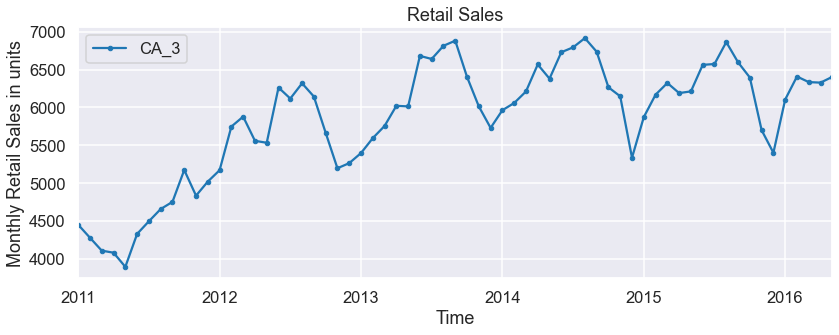

In [829]:
fig, ax = plt.subplots(figsize=[12, 5])

store_daily_sales_summary_final_monthly[['CA_3']].plot(ax=ax, marker=".")
ax.set_xlabel("Time")
ax.set_ylabel("Monthly Retail Sales in units")
ax.set_title("Retail Sales")
plt.tight_layout()

## Classical decomposition- Monthly

In [830]:
## 1) Compute Trend
window_size = 12
store_daily_sales_summary_final_monthly["CA_3_rolling"] = (
 store_daily_sales_summary_final_monthly['CA_3'].rolling(window=window_size)
    .mean()      
    .rolling(window=2)
    .mean()     
    .shift(-window_size // 2) 
)

In [831]:
store_daily_sales_summary_final_monthly.tail(25)

year  month         CA_3  CA_3_rolling
Date                                              
2014-05-01  2014      5  6379.322581   6368.458314
2014-06-01  2014      6  6728.366667   6357.578341
2014-07-01  2014      7  6792.709677   6337.351190
2014-08-01  2014      8  6914.741935   6338.137049
2014-09-01  2014      9  6735.233333   6347.397369
2014-10-01  2014     10  6265.129032   6336.332988
2014-11-01  2014     11  6146.200000   6313.585810
2014-12-01  2014     12  5334.967742   6299.631688
2015-01-01  2015      1  5871.741935   6283.516276
2015-02-01  2015      2  6167.607143   6272.165470
2015-03-01  2015      3  6322.225806   6264.157853
2015-04-01  2015      4  6188.800000   6263.724162
2015-05-01  2015      5  6211.290323   6250.498803
2015-06-01  2015      6  6561.500000   6234.628283
2015-07-01  2015      7  6572.806452   6247.036886
2015-08-01  2015      8  6862.225806   6266.706898
2015-09-01  2015      9  6595.566667   6277.194114
2015-10-01  2015     10  6394.387097   6283.432107
2015-11-01  2015     11  5699.533333   6297.180363
2015-12-01  2015     12  5400.741935           NaN
2016-01-01  2016      1  6103.774194           NaN
2016-02-01  2016      2  6407.655172           NaN
2016-03-01  2016      3  6333.870968           NaN
2016-04-01  2016      4  6326.866667           NaN
2016-05-01  2016      5  6403.181818           NaN

In [832]:
## Detrend Data
store_daily_sales_summary_final_monthly["CA_3_detrended"] = \
store_daily_sales_summary_final_monthly["CA_3"] - store_daily_sales_summary_final_monthly["CA_3_rolling"]


In [833]:
store_daily_sales_summary_final_monthly.head(25)

year  month         CA_3  CA_3_rolling  CA_3_detrended
Date                                                              
2011-01-01  2011      1  4450.333333           NaN             NaN
2011-02-01  2011      2  4278.285714           NaN             NaN
2011-03-01  2011      3  4107.870968           NaN             NaN
2011-04-01  2011      4  4080.933333           NaN             NaN
2011-05-01  2011      5  3893.903226           NaN             NaN
2011-06-01  2011      6  4328.900000           NaN             NaN
2011-07-01  2011      7  4496.032258   4536.089401      -40.057143
2011-08-01  2011      8  4657.290323   4627.268511       30.021812
2011-09-01  2011      9  4752.266667   4762.198069       -9.931402
2011-10-01  2011     10  5173.064516   4897.503804      275.560713
2011-11-01  2011     11  4834.133333   5027.351205     -193.217872
2011-12-01  2011     12  5020.129032   5176.179162     -156.050130
2012-01-01  2012      1  5170.193548   5324.243678     -154.050130
2012-02-01  2012      2  5746.724138   5460.960076      285.764062
2012-03-01  2012      3  5877.741935   5588.099458      289.642478
2012-04-01  2012      4  5558.400000   5666.556044     -108.156044
2012-05-01  2012      5  5532.774194   5702.155685     -169.381492
2012-06-01  2012      6  6261.900000   5727.384359      534.515641
2012-07-01  2012      7  6116.580645   5746.951563      369.629082
2012-08-01  2012      8  6317.935484   5750.009525      567.925959
2012-09-01  2012      9  6142.966667   5738.500282      404.466385
2012-10-01  2012     10  5665.322581   5752.614663      -87.292083
2012-11-01  2012     11  5196.266667   5791.883615     -595.616948
2012-12-01  2012     12  5263.483871   5829.308122     -565.824251
2013-01-01  2013      1  5396.451613   5868.500102     -472.048490

In [834]:
seasonality =store_daily_sales_summary_final_monthly.groupby("month").mean()["CA_3_detrended"]
seasonality.name = "seasonality"
seasonality

month
1    -361.673108
2    -115.088895
3      -7.677241
4       2.943156
5     -68.264505
6     442.502161
7     313.029010
8     471.092688
9     343.067404
10     64.447960
11   -377.372139
12   -580.082180
Name: seasonality, dtype: float64

In [835]:
gc.collect()

130932

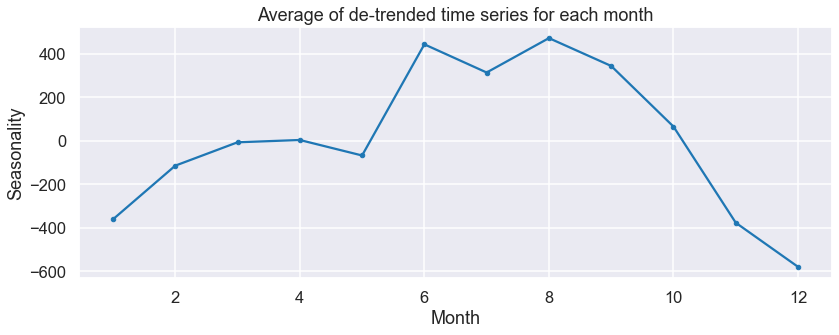

In [836]:
fig, ax = plt.subplots(figsize=[12, 5])
seasonality.plot(y="seasonality", ax=ax, marker=".")
ax.set_xlabel("Month")
ax.set_ylabel("Seasonality")
ax.set_title("Average of de-trended time series for each month")
plt.tight_layout()

In [837]:
#4. Repeat seasonal pattern each year

store_daily_sales_summary_final_monthly = store_daily_sales_summary_final_monthly.merge(right=seasonality, left_on="month", right_index=True)
store_daily_sales_summary_final_monthly = store_daily_sales_summary_final_monthly.sort_index()
store_daily_sales_summary_final_monthly.head()

year  month         CA_3  CA_3_rolling  CA_3_detrended  \
Date                                                                 
2011-01-01  2011      1  4450.333333           NaN             NaN   
2011-02-01  2011      2  4278.285714           NaN             NaN   
2011-03-01  2011      3  4107.870968           NaN             NaN   
2011-04-01  2011      4  4080.933333           NaN             NaN   
2011-05-01  2011      5  3893.903226           NaN             NaN   

            seasonality  
Date                     
2011-01-01  -361.673108  
2011-02-01  -115.088895  
2011-03-01    -7.677241  
2011-04-01     2.943156  
2011-05-01   -68.264505

In [838]:
##6.Compute residual component
store_daily_sales_summary_final_monthly["residual"] = store_daily_sales_summary_final_monthly["CA_3"] - \
store_daily_sales_summary_final_monthly["CA_3_rolling"] - store_daily_sales_summary_final_monthly["seasonality"]



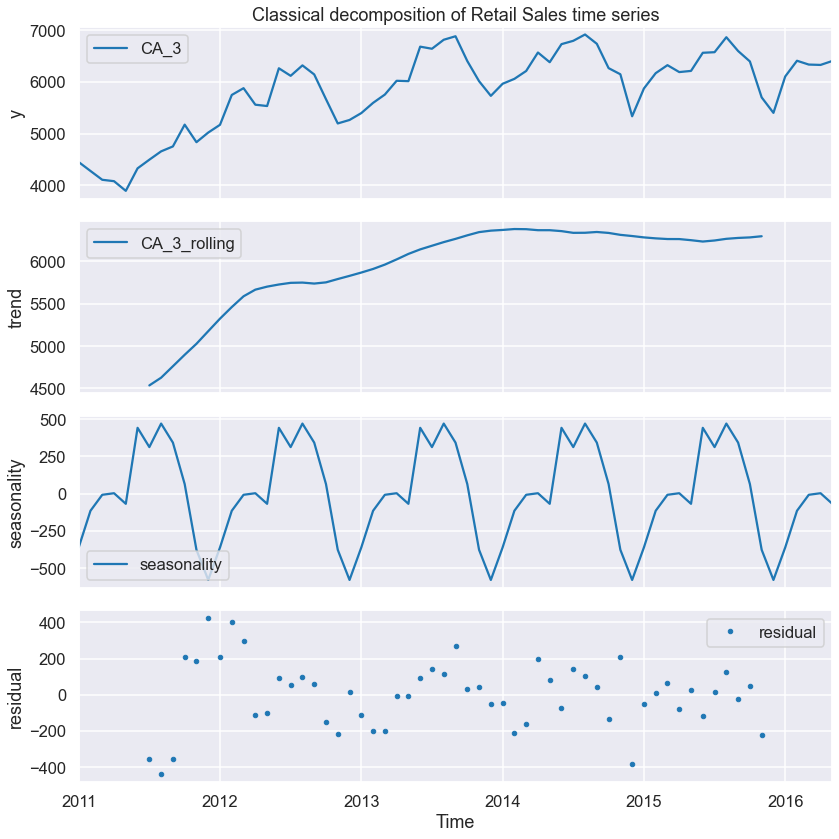

In [839]:
#7 plot results

fig, ax = plt.subplots(nrows=4, figsize=[12, 12], sharex=True)

store_daily_sales_summary_final_monthly["CA_3"].plot(ax=ax[0], legend="y")
ax[0].set_ylabel("y")

store_daily_sales_summary_final_monthly["CA_3_rolling"].plot(ax=ax[1], legend="trend")
ax[1].set_ylabel("trend")

store_daily_sales_summary_final_monthly["seasonality"].plot(ax=ax[2], legend="seasonality")
ax[2].set_ylabel("seasonality")

store_daily_sales_summary_final_monthly["residual"].plot(ax=ax[3], marker=".", legend="residual", ls="None")
ax[3].set_ylabel("residual")

ax[0].set_title("Classical decomposition of Retail Sales time series")
ax[3].set_xlabel("Time")

plt.tight_layout()



In [840]:
gc.collect()

7053

In [841]:
gc.collect()

0

## 10.Plotting of 2015 holidays for CA_3

In [842]:
df2015holiday_CA_3=df2015holiday[['date','event_name_1','CA_3']]
df2015holiday_CA_3.set_index('date',inplace=True)
df2015holiday_CA_3

event_name_1  CA_3
date                                 
2015-01-07    OrthodoxChristmas  4991
2015-01-19  MartinLutherKingDay  6538
2015-02-01            SuperBowl  8081
2015-02-14        ValentinesDay  6239
2015-02-16        PresidentsDay  6997
2015-02-18            LentStart  5097
2015-02-25            LentWeek2  5095
2015-03-05            Purim End  5881
2015-03-17        StPatricksDay  5819
2015-04-05               Easter  7999
2015-04-11           Pesach End  7093
2015-04-12       OrthodoxEaster  7907
2015-05-05        Cinco De Mayo  5835
2015-05-10         Mother's day  6636
2015-05-25          MemorialDay  7264
2015-06-04       NBAFinalsStart  5871
2015-06-16         NBAFinalsEnd  5408
2015-06-18       Ramadan starts  5732
2015-06-21         Father's day  6739
2015-07-04      IndependenceDay  6237
2015-07-18          Eid al-Fitr  7397
2015-09-07             LaborDay  7827
2015-09-24            EidAlAdha  5404
2015-10-12          ColumbusDay  7279
2015-10-31            Halloween  6500
2015-11-11          VeteransDay  5187
2015-11-26         Thanksgiving  3674
2015-12-14         Chanukah End  5568
2015-12-25            Christmas     4

In [843]:
df2015holiday_CA_3.index

DatetimeIndex(['2015-01-07', '2015-01-19', '2015-02-01', '2015-02-14',
               '2015-02-16', '2015-02-18', '2015-02-25', '2015-03-05',
               '2015-03-17', '2015-04-05', '2015-04-11', '2015-04-12',
               '2015-05-05', '2015-05-10', '2015-05-25', '2015-06-04',
               '2015-06-16', '2015-06-18', '2015-06-21', '2015-07-04',
               '2015-07-18', '2015-09-07', '2015-09-24', '2015-10-12',
               '2015-10-31', '2015-11-11', '2015-11-26', '2015-12-14',
               '2015-12-25'],
              dtype='datetime64[ns]', name='date', freq=None)

In [844]:
df2015holiday_CA_3['CA_3_seasonal_daily']=store_daily_sales_summary_final[["CA_3_seasonal_daily"]].loc[df2015holiday_CA_3.index]

In [845]:
df2015holiday_CA_3=df2015holiday_CA_3.reset_index()
df2015holiday_CA_3

date         event_name_1  CA_3  CA_3_seasonal_daily
0  2015-01-07    OrthodoxChristmas  4991          -805.960363
1  2015-01-19  MartinLutherKingDay  6538           370.798210
2  2015-02-01            SuperBowl  8081           -95.947589
3  2015-02-14        ValentinesDay  6239          -134.058539
4  2015-02-16        PresidentsDay  6997          1043.427765
5  2015-02-18            LentStart  5097          -920.182374
6  2015-02-25            LentWeek2  5095          -984.530931
7  2015-03-05            Purim End  5881          -664.176447
8  2015-03-17        StPatricksDay  5819          -509.998209
9  2015-04-05               Easter  7999          1831.621285
10 2015-04-11           Pesach End  7093          1005.108402
11 2015-04-12       OrthodoxEaster  7907          1492.038875
12 2015-05-05        Cinco De Mayo  5835          -269.583573
13 2015-05-10         Mother's day  6636           375.589182
14 2015-05-25          MemorialDay  7264           938.476326
15 2015-06-04       NBAFinalsStart  5871          -306.532825
16 2015-06-16         NBAFinalsEnd  5408          -839.245125
17 2015-06-18       Ramadan starts  5732          -418.712289
18 2015-06-21         Father's day  6739           735.751511
19 2015-07-04      IndependenceDay  6237           973.889375
20 2015-07-18          Eid al-Fitr  7397           931.917780
21 2015-09-07             LaborDay  7827          3625.495582
22 2015-09-24            EidAlAdha  5404         -1030.992908
23 2015-10-12          ColumbusDay  7279          2555.619814
24 2015-10-31            Halloween  6500          -311.389574
25 2015-11-11          VeteransDay  5187         -1103.038229
26 2015-11-26         Thanksgiving  3674         -2685.054887
27 2015-12-14         Chanukah End  5568          -342.531532
28 2015-12-25            Christmas     4         -6535.243481

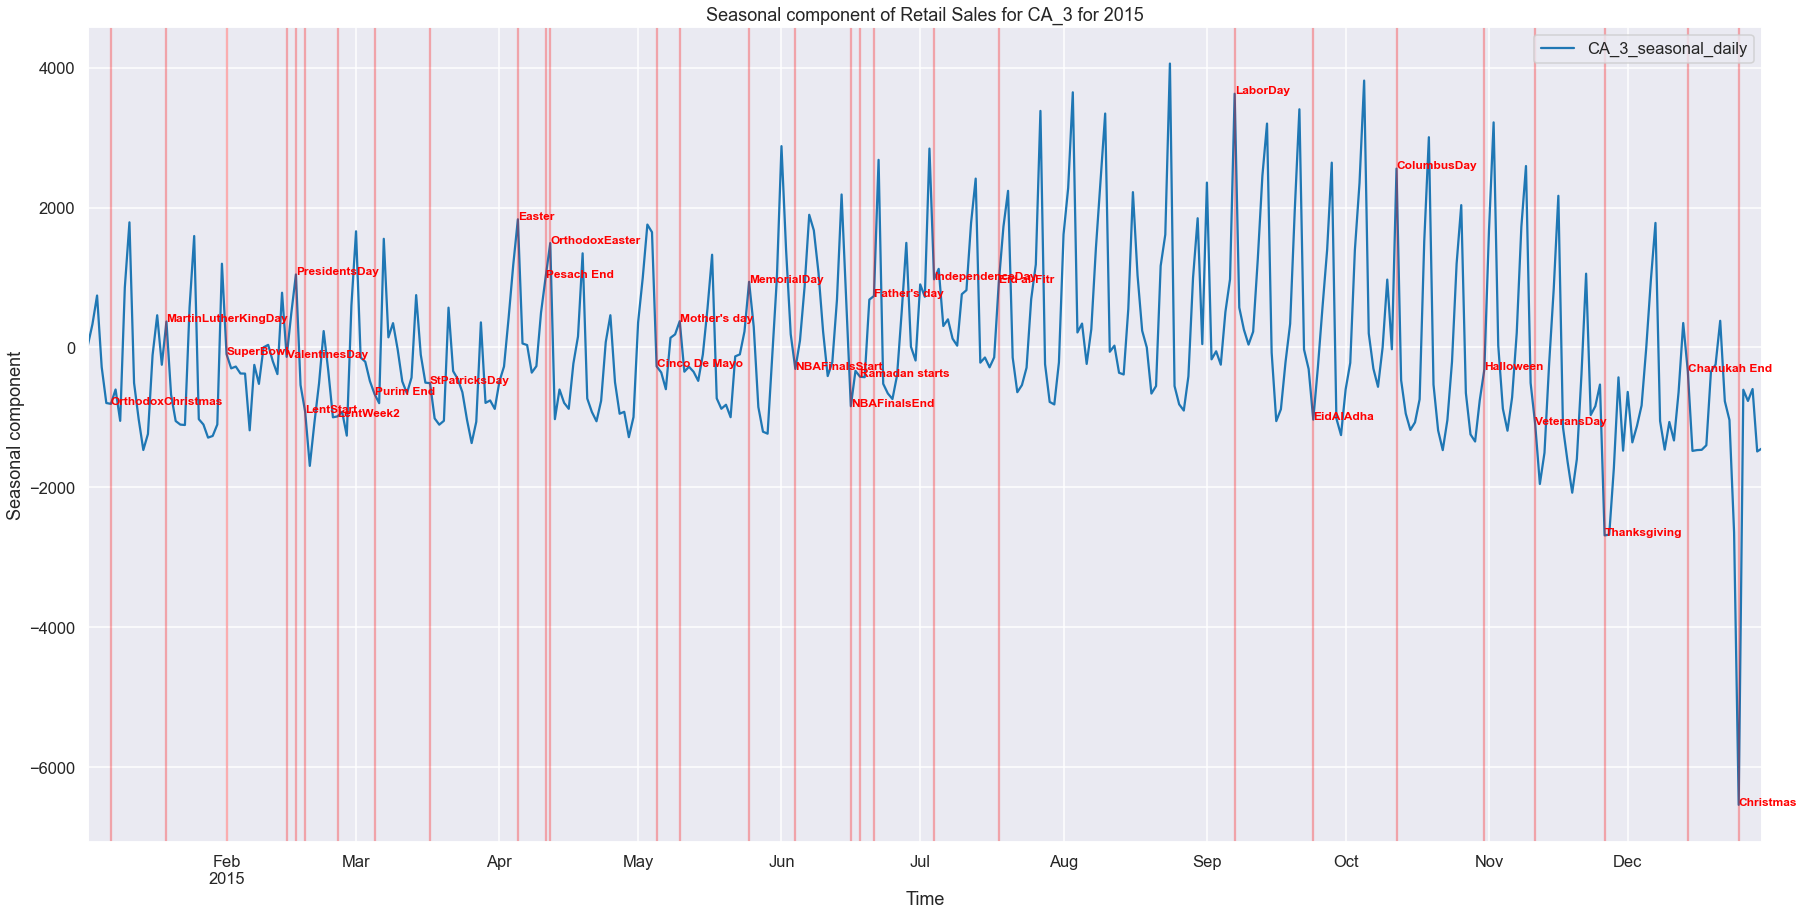

In [846]:
fig, ax = plt.subplots(nrows=1, figsize=[30, 15], sharex=True)
store_daily_sales_summary_final[["CA_3_seasonal_daily"]].query('date>"01-01-2015" and date<"12-31-2015"')\
.plot(ax=ax, legend="seasonality")

for k in range(len(df2015holiday_CA_3)):
        #ax[i].text(df2015holiday.iloc[i,0],df2015holiday.iloc[k,2],df2015holiday.iloc[k,1], **style)
        ax.text(df2015holiday_CA_3.iloc[k,0],df2015holiday_CA_3['CA_3_seasonal_daily'].iloc[k],df2015holiday_CA_3.iloc[k,1], **style)
for x in store_daily_sales_summary_final.query('Holidays!=0').index:       # for days where holiday == 1
        ax.axvline(x=x, color='Red', alpha = 0.3);  # add a semi-transparent grey line
ax.set_title("Seasonal component of Retail Sales for CA_3 for 2015")
ax.set_xlabel("Time")
ax.set_ylabel("Seasonal component") ;      
        

In [847]:
gc.collect()

15233

# 11.Preparing dataframe frame for Item level forecast

In [848]:
# getting sell price

In [849]:
df_final_with_price= pd.merge(left=df_final,right=sell_prices,how='left',left_on=['store_id','item_id','wm_yr_wk']\
                              ,right_on=['store_id','item_id','wm_yr_wk'])
df_final_with_price

store_id        item_id   cat_id       d  unit_sales        date  \
0           CA_3  HOBBIES_1_001  HOBBIES     d_1           0  2011-01-29   
1           CA_3  HOBBIES_1_002  HOBBIES     d_1           0  2011-01-29   
2           CA_3  HOBBIES_1_003  HOBBIES     d_1           0  2011-01-29   
3           CA_3  HOBBIES_1_004  HOBBIES     d_1           0  2011-01-29   
4           CA_3  HOBBIES_1_005  HOBBIES     d_1           0  2011-01-29   
...          ...            ...      ...     ...         ...         ...   
5918104     CA_3    FOODS_3_823    FOODS  d_1941           2  2016-05-22   
5918105     CA_3    FOODS_3_824    FOODS  d_1941           0  2016-05-22   
5918106     CA_3    FOODS_3_825    FOODS  d_1941           1  2016-05-22   
5918107     CA_3    FOODS_3_826    FOODS  d_1941           0  2016-05-22   
5918108     CA_3    FOODS_3_827    FOODS  d_1941           0  2016-05-22   

         wm_yr_wk   weekday  wday  month  year event_name_1 event_type_1  \
0           11101  Saturday     1      1  2011          NaN          NaN   
1           11101  Saturday     1      1  2011          NaN          NaN   
2           11101  Saturday     1      1  2011          NaN          NaN   
3           11101  Saturday     1      1  2011          NaN          NaN   
4           11101  Saturday     1      1  2011          NaN          NaN   
...           ...       ...   ...    ...   ...          ...          ...   
5918104     11617    Sunday     2      5  2016          NaN          NaN   
5918105     11617    Sunday     2      5  2016          NaN          NaN   
5918106     11617    Sunday     2      5  2016          NaN          NaN   
5918107     11617    Sunday     2      5  2016          NaN          NaN   
5918108     11617    Sunday     2      5  2016          NaN          NaN   

        event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  sell_price  
0                NaN          NaN        0        0        0         NaN  
1                NaN          NaN        0        0        0         NaN  
2                NaN          NaN        0        0        0         NaN  
3                NaN          NaN        0        0        0         NaN  
4                NaN          NaN        0        0        0         NaN  
...              ...          ...      ...      ...      ...         ...  
5918104          NaN          NaN        0        0        0        2.98  
5918105          NaN          NaN        0        0        0        2.48  
5918106          NaN          NaN        0        0        0        3.98  
5918107          NaN          NaN        0        0        0        1.28  
5918108          NaN          NaN        0        0        0        1.00  

[5918109 rows x 19 columns]

In [850]:
df_final_with_price.sell_price.isnull().sum()

1160796

In [851]:
df_final_with_price.sell_price.fillna(0)

0          0.00
1          0.00
2          0.00
3          0.00
4          0.00
           ... 
5918104    2.98
5918105    2.48
5918106    3.98
5918107    1.28
5918108    1.00
Name: sell_price, Length: 5918109, dtype: float64

In [852]:
gc.collect()

0

In [853]:
# getting inventory class

In [854]:
Item_sales_revenue_sum.columns

Index(['item_id', 'cat_id', 'Sales_Revenue', 'grouped_cumulative_sum',
       'Inventory_class'],
      dtype='object')

In [855]:
df_final_with_price_inventory_class=\
pd.merge(left=df_final_with_price,right=Item_sales_revenue_sum[['item_id','Inventory_class']],how='left',left_on=['item_id']\
                              ,right_on=['item_id'])
df_final_with_price_inventory_class.head(5)

store_id        item_id   cat_id    d  unit_sales        date  wm_yr_wk  \
0     CA_3  HOBBIES_1_001  HOBBIES  d_1           0  2011-01-29     11101   
1     CA_3  HOBBIES_1_002  HOBBIES  d_1           0  2011-01-29     11101   
2     CA_3  HOBBIES_1_003  HOBBIES  d_1           0  2011-01-29     11101   
3     CA_3  HOBBIES_1_004  HOBBIES  d_1           0  2011-01-29     11101   
4     CA_3  HOBBIES_1_005  HOBBIES  d_1           0  2011-01-29     11101   

    weekday  wday  month  year event_name_1 event_type_1 event_name_2  \
0  Saturday     1      1  2011          NaN          NaN          NaN   
1  Saturday     1      1  2011          NaN          NaN          NaN   
2  Saturday     1      1  2011          NaN          NaN          NaN   
3  Saturday     1      1  2011          NaN          NaN          NaN   
4  Saturday     1      1  2011          NaN          NaN          NaN   

  event_type_2  snap_CA  snap_TX  snap_WI  sell_price Inventory_class  
0          NaN        0        0        0         NaN               B  
1          NaN        0        0        0         NaN               C  
2          NaN        0        0        0         NaN               C  
3          NaN        0        0        0         NaN               A  
4          NaN        0        0        0         NaN               A

In [856]:
gc.collect()

0

In [857]:
df_final_with_price_inventory_class.columns

Index(['store_id', 'item_id', 'cat_id', 'd', 'unit_sales', 'date', 'wm_yr_wk',
       'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
       'sell_price', 'Inventory_class'],
      dtype='object')

In [858]:
df_final_with_price_inventory_class.Inventory_class.nunique()

3

In [859]:
df_final_with_price_inventory_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5918109 entries, 0 to 5918108
Data columns (total 20 columns):
 #   Column           Dtype  
---  ------           -----  
 0   store_id         object 
 1   item_id          object 
 2   cat_id           object 
 3   d                object 
 4   unit_sales       int64  
 5   date             object 
 6   wm_yr_wk         int64  
 7   weekday          object 
 8   wday             int64  
 9   month            int64  
 10  year             int64  
 11  event_name_1     object 
 12  event_type_1     object 
 13  event_name_2     object 
 14  event_type_2     object 
 15  snap_CA          int64  
 16  snap_TX          int64  
 17  snap_WI          int64  
 18  sell_price       float64
 19  Inventory_class  object 
dtypes: float64(1), int64(8), object(11)
memory usage: 948.2+ MB


In [860]:
df_final_with_price_inventory_class['date']=pd.to_datetime(df_final_with_price_inventory_class['date'],infer_datetime_format=True)

In [861]:
df_final_with_price_inventory_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5918109 entries, 0 to 5918108
Data columns (total 20 columns):
 #   Column           Dtype         
---  ------           -----         
 0   store_id         object        
 1   item_id          object        
 2   cat_id           object        
 3   d                object        
 4   unit_sales       int64         
 5   date             datetime64[ns]
 6   wm_yr_wk         int64         
 7   weekday          object        
 8   wday             int64         
 9   month            int64         
 10  year             int64         
 11  event_name_1     object        
 12  event_type_1     object        
 13  event_name_2     object        
 14  event_type_2     object        
 15  snap_CA          int64         
 16  snap_TX          int64         
 17  snap_WI          int64         
 18  sell_price       float64       
 19  Inventory_class  object        
dtypes: datetime64[ns](1), float64(1), int64(8), object(10)
memory usage:

### Combining all the holidays in one column

In [862]:
df_final_with_price_inventory_class['Holidays']=df_final_with_price_inventory_class['event_name_1']

In [863]:
df_final_with_price_inventory_class['Holidays']=df_final_with_price_inventory_class['Holidays'].notnull().astype("int")

In [864]:
df_final_with_price_inventory_class['Holidays']=df_final_with_price_inventory_class['Holidays'].fillna(0)

In [865]:
df_final_with_price_inventory_class['Holidays'].unique()

array([0, 1])

In [866]:
# Seeting daily index

In [867]:
#df_final_with_price_inventory_class.set_index('date',inplace=True)

In [868]:
#df_final_with_price_inventory_class = df_final_with_price_inventory_class.asfreq('d')

In [869]:
df_final_with_price_inventory_class.sort_values(by=['item_id','date'],inplace=True)

In [870]:
df_final_with_price_inventory_class

store_id          item_id     cat_id       d  unit_sales       date  \
1612        CA_3      FOODS_1_001      FOODS     d_1           1 2011-01-29   
4661        CA_3      FOODS_1_001      FOODS     d_2           2 2011-01-30   
7710        CA_3      FOODS_1_001      FOODS     d_3           1 2011-01-31   
10759       CA_3      FOODS_1_001      FOODS     d_4           1 2011-02-01   
13808       CA_3      FOODS_1_001      FOODS     d_5           1 2011-02-02   
...          ...              ...        ...     ...         ...        ...   
5904475     CA_3  HOUSEHOLD_2_516  HOUSEHOLD  d_1937           0 2016-05-18   
5907524     CA_3  HOUSEHOLD_2_516  HOUSEHOLD  d_1938           0 2016-05-19   
5910573     CA_3  HOUSEHOLD_2_516  HOUSEHOLD  d_1939           0 2016-05-20   
5913622     CA_3  HOUSEHOLD_2_516  HOUSEHOLD  d_1940           0 2016-05-21   
5916671     CA_3  HOUSEHOLD_2_516  HOUSEHOLD  d_1941           0 2016-05-22   

         wm_yr_wk    weekday  wday  month  ...  event_name_1 event_type_1  \
1612        11101   Saturday     1      1  ...           NaN          NaN   
4661        11101     Sunday     2      1  ...           NaN          NaN   
7710        11101     Monday     3      1  ...           NaN          NaN   
10759       11101    Tuesday     4      2  ...           NaN          NaN   
13808       11101  Wednesday     5      2  ...           NaN          NaN   
...           ...        ...   ...    ...  ...           ...          ...   
5904475     11616  Wednesday     5      5  ...           NaN          NaN   
5907524     11616   Thursday     6      5  ...           NaN          NaN   
5910573     11616     Friday     7      5  ...           NaN          NaN   
5913622     11617   Saturday     1      5  ...           NaN          NaN   
5916671     11617     Sunday     2      5  ...           NaN          NaN   

        event_name_2 event_type_2 snap_CA  snap_TX  snap_WI  sell_price  \
1612             NaN          NaN       0        0        0        2.00   
4661             NaN          NaN       0        0        0        2.00   
7710             NaN          NaN       0        0        0        2.00   
10759            NaN          NaN       1        1        0        2.00   
13808            NaN          NaN       1        0        1        2.00   
...              ...          ...     ...      ...      ...         ...   
5904475          NaN          NaN       0        0        0        5.94   
5907524          NaN          NaN       0        0        0        5.94   
5910573          NaN          NaN       0        0        0        5.94   
5913622          NaN          NaN       0        0        0        5.94   
5916671          NaN          NaN       0        0        0        5.94   

         Inventory_class Holidays  
1612                   B        0  
4661                   B        0  
7710                   B        0  
10759                  B        0  
13808                  B        0  
...                  ...      ...  
5904475                C        0  
5907524                C        0  
5910573                C        0  
5913622                C        0  
5916671                C        0  

[5918109 rows x 21 columns]

In [871]:
df_final_with_price_inventory_class.query('item_id=="FOODS_1_001"')

store_id      item_id cat_id       d  unit_sales       date  wm_yr_wk  \
1612        CA_3  FOODS_1_001  FOODS     d_1           1 2011-01-29     11101   
4661        CA_3  FOODS_1_001  FOODS     d_2           2 2011-01-30     11101   
7710        CA_3  FOODS_1_001  FOODS     d_3           1 2011-01-31     11101   
10759       CA_3  FOODS_1_001  FOODS     d_4           1 2011-02-01     11101   
13808       CA_3  FOODS_1_001  FOODS     d_5           1 2011-02-02     11101   
...          ...          ...    ...     ...         ...        ...       ...   
5904476     CA_3  FOODS_1_001  FOODS  d_1937           1 2016-05-18     11616   
5907525     CA_3  FOODS_1_001  FOODS  d_1938           0 2016-05-19     11616   
5910574     CA_3  FOODS_1_001  FOODS  d_1939           3 2016-05-20     11616   
5913623     CA_3  FOODS_1_001  FOODS  d_1940           2 2016-05-21     11617   
5916672     CA_3  FOODS_1_001  FOODS  d_1941           2 2016-05-22     11617   

           weekday  wday  month  ...  event_name_1 event_type_1 event_name_2  \
1612      Saturday     1      1  ...           NaN          NaN          NaN   
4661        Sunday     2      1  ...           NaN          NaN          NaN   
7710        Monday     3      1  ...           NaN          NaN          NaN   
10759      Tuesday     4      2  ...           NaN          NaN          NaN   
13808    Wednesday     5      2  ...           NaN          NaN          NaN   
...            ...   ...    ...  ...           ...          ...          ...   
5904476  Wednesday     5      5  ...           NaN          NaN          NaN   
5907525   Thursday     6      5  ...           NaN          NaN          NaN   
5910574     Friday     7      5  ...           NaN          NaN          NaN   
5913623   Saturday     1      5  ...           NaN          NaN          NaN   
5916672     Sunday     2      5  ...           NaN          NaN          NaN   

        event_type_2 snap_CA  snap_TX  snap_WI  sell_price  Inventory_class  \
1612             NaN       0        0        0        2.00                B   
4661             NaN       0        0        0        2.00                B   
7710             NaN       0        0        0        2.00                B   
10759            NaN       1        1        0        2.00                B   
13808            NaN       1        0        1        2.00                B   
...              ...     ...      ...      ...         ...              ...   
5904476          NaN       0        0        0        2.24                B   
5907525          NaN       0        0        0        2.24                B   
5910574          NaN       0        0        0        2.24                B   
5913623          NaN       0        0        0        2.24                B   
5916672          NaN       0        0        0        2.24                B   

        Holidays  
1612           0  
4661           0  
7710           0  
10759          0  
13808          0  
...          ...  
5904476        0  
5907525        0  
5910574        0  
5913623        0  
5916672        0  

[1941 rows x 21 columns]

In [872]:
gc.collect()

12

## 12.Autocorrelation function (ACF) and partial autocorrelation function (PACF) Plots

# Daily

In [873]:
df_acf_pacf_daily_plots=store_daily_sales_summary_final.query('year>=2012 & year<=2015')[['CA_3']]

In [874]:
df_acf_pacf_daily_plots.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
               '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', name='date', length=1461, freq='D')

In [875]:
# plotting ACF and PACF for daily data without removing trend and Seasonality

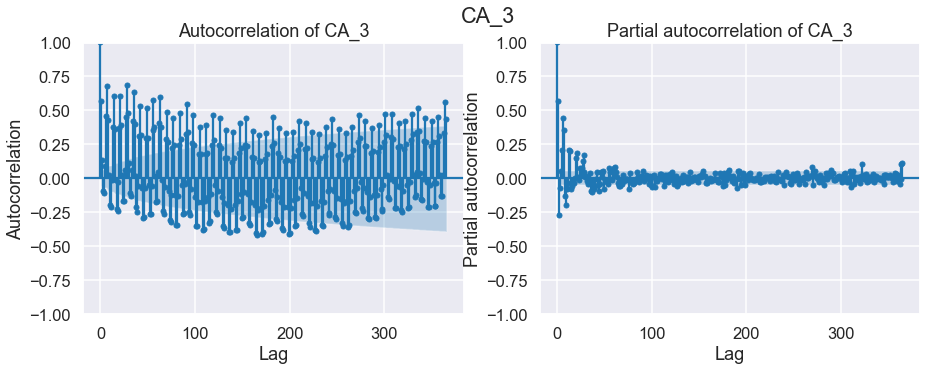

In [876]:
for col in df_acf_pacf_daily_plots.columns:
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    plot_acf(df_acf_pacf_daily_plots, lags=365, ax=ax[0])
    ax[0].set_title(f"Autocorrelation of {col}")
    ax[0].set_xlabel("Lag")
    ax[0].set_ylabel("Autocorrelation")
    plot_pacf(df_acf_pacf_daily_plots, lags=365, ax=ax[1], method="ywmle")
    ax[1].set_title(f"Partial autocorrelation of {col}")
    ax[1].set_xlabel("Lag")
    ax[1].set_ylabel("Partial autocorrelation")
    fig.suptitle(col)

In [877]:
#CA_3_daily_summary_for_ARIMA=store_daily_sales_summary_final.query('year>=2012 & year<=2015')[['CA_3']]

## Daily-PACF after detrending the original series

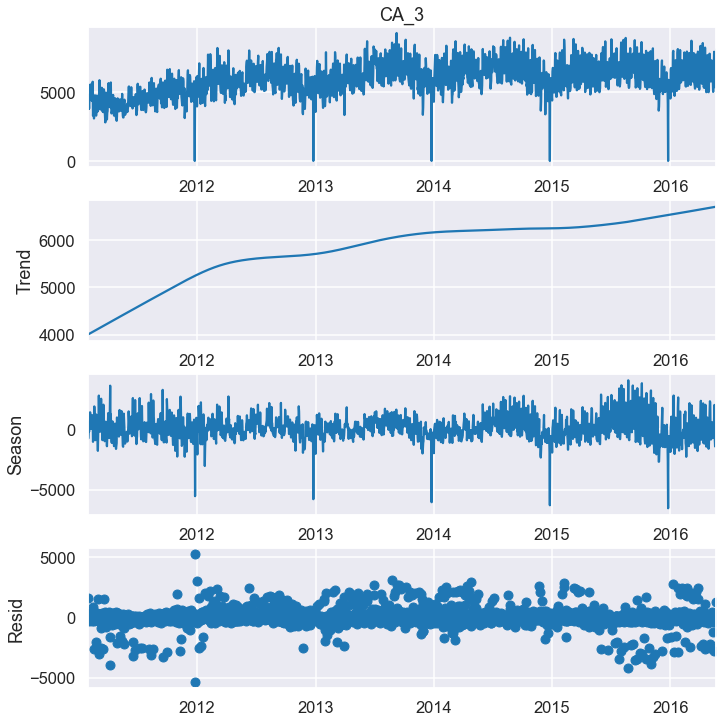

In [878]:
# Break the timeseries into trend, seasonality, and residual components
res_daily = STL(df_acf_pacf_daily_plots).fit()

# Plot the full decomposition
plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
res.plot();

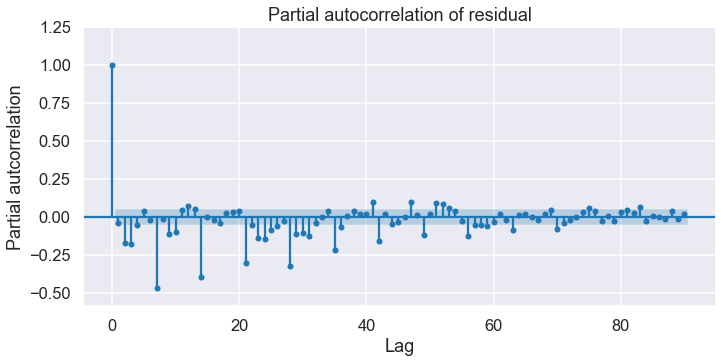

In [879]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_pacf(
    x=res_daily.resid,
    lags=90,
    method='ywmle', # Recommended method in Statsmodels notes
    ax=ax,
    alpha=0.05,
    auto_ylims=True
)
ax.set_title("Partial autocorrelation of residual")
ax.set_ylabel("Partial autcorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

## Daily-ACF after detrending the original series

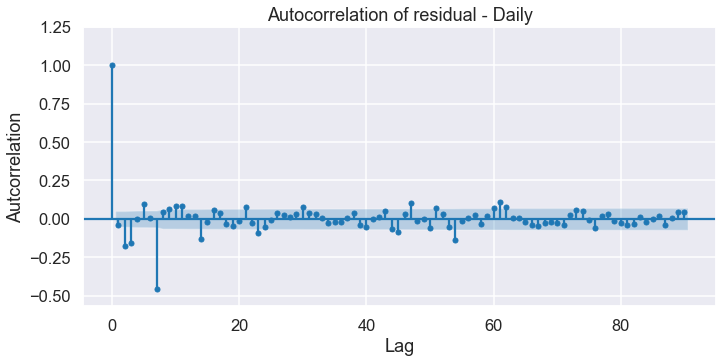

In [880]:
fig, ax = plt.subplots(figsize=[10, 5])

plot_acf(
    x=res_daily.resid,
    lags=90,
     ax=ax,
    alpha=0.05,
    auto_ylims=True
)
ax.set_title("Autocorrelation of residual - Daily")
ax.set_ylabel("Autcorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

## Daily stationarity test

In [881]:
adfuller(df_acf_pacf_daily_plots,autolag='AIC')

(-3.3629174260366494,
 0.01228987098362515,
 24,
 1436,
 {'1%': -3.434911997169608,
  '5%': -2.863554810504947,
  '10%': -2.567842671398422},
 22520.722133511823)

In [882]:
# we can see that the daily data is already is stationary

# Getting p,d,q from  Auto-ARIMA for daily data

In [883]:
auto_arima(df_acf_pacf_daily_plots,max_p=60,
    max_d=2,
    max_q=60,seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1461
Model:             SARIMAX(5, 1, 0)x(2, 0, 0, 7)   Log Likelihood              -11619.972
Date:                           Tue, 31 Jan 2023   AIC                          23255.944
Time:                                   07:33:25   BIC                          23298.233
Sample:                                        0   HQIC                         23271.720
                                          - 1461                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5077      0.015    -34.931      0.000      -0.536      -0.479
ar.L2         -0.3605      0.027    -13.385      0.000      -0.413      -0.308
ar.L3         -0.3027      0.032     -9.570      0.000      -0.365      -0.241
ar.L4         -0.1917      0.032     -5.945      0.000      -0.255      -0.128
ar.L5         -0.0887      0.026     -3.422      0.001      -0.139      -0.038
ar.S.L7        0.3820      0.021     18.251      0.000       0.341       0.423
ar.S.L14       0.3692      0.017     21.952      0.000       0.336       0.402
sigma2       4.75e+05   8807.072     53.933      0.000    4.58e+05    4.92e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2892.22
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.40
Prob(H) (two-sided):                  0.23   Kurtosis:                         9.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [884]:
gc.collect()

40679

## Weekly data - ACF and PACF

In [885]:
store_daily_sales_summary_final_weekly

CA_3  week  CA_3_rolling_weekly  CA_3_detrended  \
date                                                           
2011-01-30   9566     4                  NaN             NaN   
2011-02-06  31943     5                  NaN             NaN   
2011-02-13  33656     6                  NaN             NaN   
2011-02-20  26609     7                  NaN             NaN   
2011-02-27  27765     8                  NaN             NaN   
...           ...   ...                  ...             ...   
2016-04-24  42767    16                  NaN             NaN   
2016-05-01  42318    17                  NaN             NaN   
2016-05-08  45029    18                  NaN             NaN   
2016-05-15  44885    19                  NaN             NaN   
2016-05-22  43128    20                  NaN             NaN   

            Weekly_seasonality_x  Weekly_seasonality_y  
date                                                    
2011-01-30          -3087.911058          -3087.911058  
2011-02-06          -2205.939904          -2205.939904  
2011-02-13           1417.466346           1417.466346  
2011-02-20           -874.266827           -874.266827  
2011-02-27          -1726.235577          -1726.235577  
...                          ...                   ...  
2016-04-24          -1089.355769          -1089.355769  
2016-05-01          -2346.742788          -2346.742788  
2016-05-08            170.557692            170.557692  
2016-05-15           1296.930288           1296.930288  
2016-05-22             86.675481             86.675481  

[278 rows x 6 columns]

In [886]:
store_daily_sales_summary_final_weekly["year"] = store_daily_sales_summary_final_weekly.index.year

In [887]:
store_daily_sales_summary_final_weekly.index

DatetimeIndex(['2011-01-30', '2011-02-06', '2011-02-13', '2011-02-20',
               '2011-02-27', '2011-03-06', '2011-03-13', '2011-03-20',
               '2011-03-27', '2011-04-03',
               ...
               '2016-03-20', '2016-03-27', '2016-04-03', '2016-04-10',
               '2016-04-17', '2016-04-24', '2016-05-01', '2016-05-08',
               '2016-05-15', '2016-05-22'],
              dtype='datetime64[ns]', name='date', length=278, freq=None)

In [888]:
df_acf_pacf_weekly_plots=store_daily_sales_summary_final_weekly.query('year>=2012 & year<=2015')[['CA_3']].asfreq('W')

In [889]:
df_acf_pacf_weekly_plots.index

DatetimeIndex(['2012-01-01', '2012-01-08', '2012-01-15', '2012-01-22',
               '2012-01-29', '2012-02-05', '2012-02-12', '2012-02-19',
               '2012-02-26', '2012-03-04',
               ...
               '2015-10-25', '2015-11-01', '2015-11-08', '2015-11-15',
               '2015-11-22', '2015-11-29', '2015-12-06', '2015-12-13',
               '2015-12-20', '2015-12-27'],
              dtype='datetime64[ns]', name='date', length=209, freq='W-SUN')

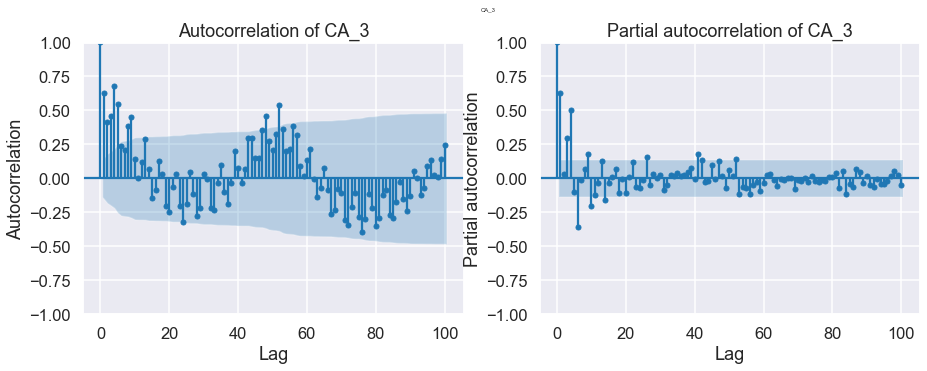

In [890]:
# plotting ACF and PACF for weekly data without removing trend and Seasonality

for col in df_acf_pacf_weekly_plots.columns:
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    plot_acf(df_acf_pacf_weekly_plots, lags=100, ax=ax[0])
    ax[0].set_title(f"Autocorrelation of {col}")
    ax[0].set_xlabel("Lag")
    ax[0].set_ylabel("Autocorrelation")
    plot_pacf(df_acf_pacf_weekly_plots, lags=100, ax=ax[1], method="ywmle")
    ax[1].set_title(f"Partial autocorrelation of {col}")
    ax[1].set_xlabel("Lag")
    ax[1].set_ylabel("Partial autocorrelation")
    fig.suptitle(col)

## Weekly- Detrending and Deseasonalizing the original series

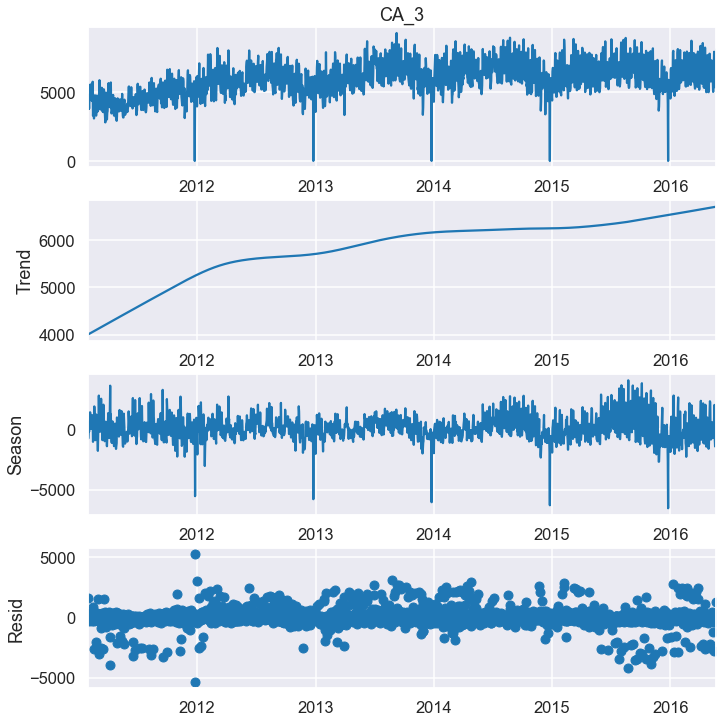

In [891]:
# Break the timeseries into trend, seasonality, and residual components
res_weekly = STL(df_acf_pacf_weekly_plots).fit()

# Plot the full decomposition
plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
res.plot();

## Weekly-PACF after detrending the original series

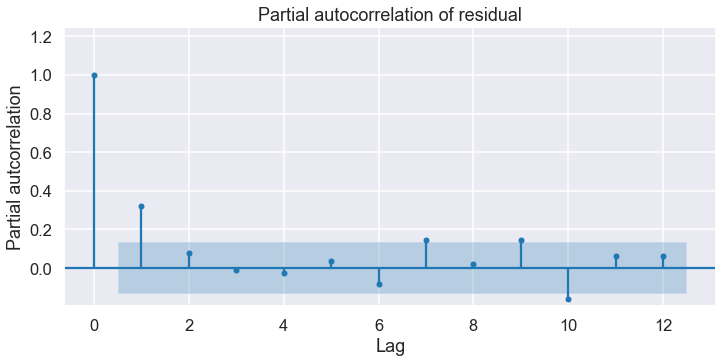

In [892]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_pacf(
    x=res_weekly.resid,
    lags=12,
    method='ywmle', # Recommended method in Statsmodels notes
    ax=ax,
    alpha=0.05,
    auto_ylims=True
)
ax.set_title("Partial autocorrelation of residual")
ax.set_ylabel("Partial autcorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

## Weekly- ACF after detrending the original series

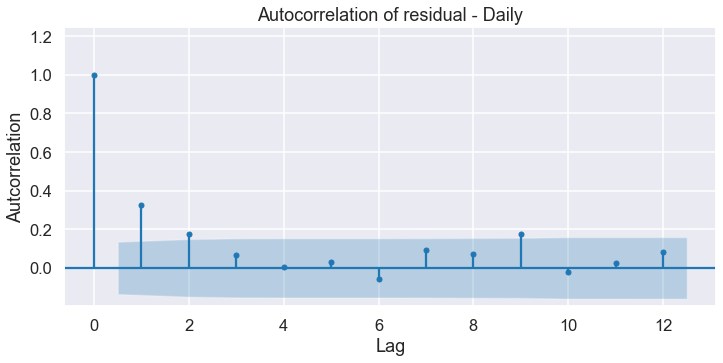

In [893]:
fig, ax = plt.subplots(figsize=[10, 5])

plot_acf(
    x=res_weekly.resid,
    lags=12,
     ax=ax,
    alpha=0.05,
    auto_ylims=True
)
ax.set_title("Autocorrelation of residual - Daily")
ax.set_ylabel("Autcorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

## Weekly stationarity test

In [894]:
adfuller(df_acf_pacf_weekly_plots,autolag='AIC')

(-3.309743674200412,
 0.014448510444048143,
 13,
 195,
 {'1%': -3.464337030867007,
  '5%': -2.876478799035722,
  '10%': -2.574733103221565},
 3530.836405775425)

In [895]:
# we can see that the weekly data is already is stationary

# Getting p,d,q from pmdarima Auto-ARIMA for weekly data

In [896]:
auto_arima(df_acf_pacf_weekly_plots,max_p=6,
    max_d=2,
    max_q=6,seasonal=True,m=52).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  209
Model:             SARIMAX(3, 1, 2)x(1, 0, [], 52)   Log Likelihood               -1913.079
Date:                             Tue, 31 Jan 2023   AIC                           3840.157
Time:                                     07:36:46   BIC                           3863.520
Sample:                                          0   HQIC                          3849.604
                                             - 209                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0778      0.037     -2.085      0.037      -0.151      -0.005
ar.L2         -0.9120      0.010    -87.127      0.000      -0.933      -0.891
ar.L3         -0.3285      0.035     -9.328      0.000      -0.398      -0.260
ma.L1         -0.2280      0.022    -10.350      0.000      -0.271      -0.185
ma.L2          0.9678      0.025     38.253      0.000       0.918       1.017
ar.S.L52       0.1280      0.032      3.979      0.000       0.065       0.191
sigma2      5.604e+06   1.69e-09   3.31e+15      0.000     5.6e+06     5.6e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.06   Jarque-Bera (JB):                61.31
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.51e+30. Standard errors may be unstable.
"""

In [897]:
gc.collect()

23249

## Monthly - Autocorrelation function (ACF) and partial autocorrelation function (PACF)

In [898]:
df_acf_pacf_monthly_plots=store_daily_sales_summary_final_monthly.query('year>=2012 & year<=2015').asfreq('MS')

In [899]:
df_acf_pacf_monthly_plots.index

DatetimeIndex(['2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')

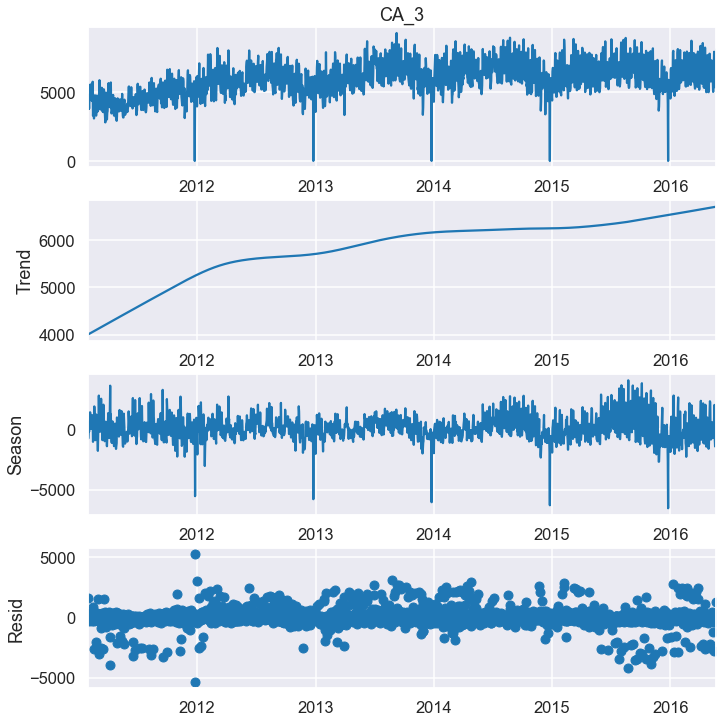

In [900]:
# Break the timeseries into trend, seasonality, and residual components
res_monthly = STL(df_acf_pacf_monthly_plots['CA_3']).fit()

# Plot the full decomposition
plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
res.plot();

## Monthly-PACF after detrending the original series

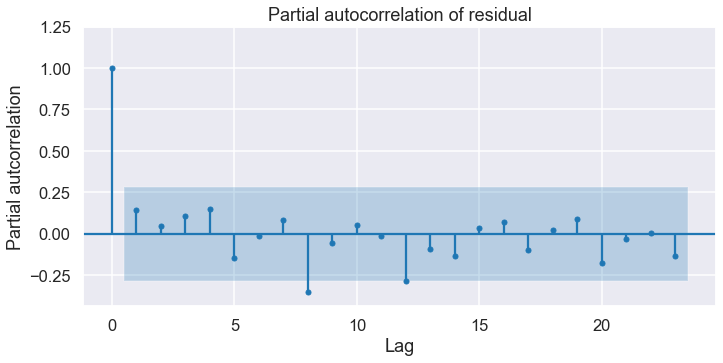

In [901]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_pacf(
    x=res_monthly.resid,
    lags=23,
    method='ywmle', # Recommended method in Statsmodels notes
    ax=ax,
    alpha=0.05,
    auto_ylims=True
)
ax.set_title("Partial autocorrelation of residual")
ax.set_ylabel("Partial autcorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

## Monthly-ACF after detrending the original series

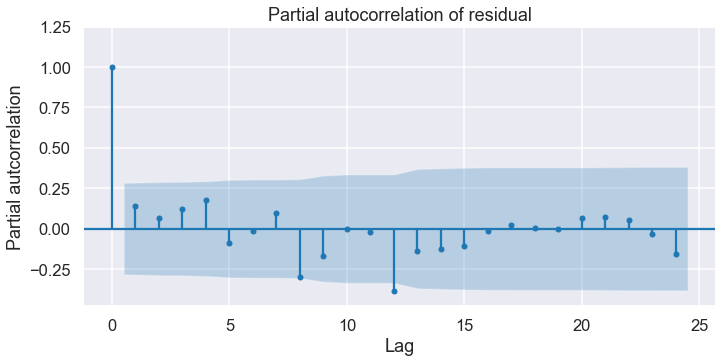

In [902]:
fig, ax = plt.subplots(figsize=[10, 5])

plot_acf(
    x=res_monthly.resid,
    lags=24,
     ax=ax,
    alpha=0.05,
    auto_ylims=True
)
ax.set_title("Partial autocorrelation of residual")
ax.set_ylabel("Partial autcorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

In [903]:
gc.collect()

16323

## Monthly stationarity test

In [904]:
adfuller(df_acf_pacf_monthly_plots['CA_3'],autolag='AIC')

(-1.6638267410653993,
 0.4498397283110064,
 9,
 38,
 {'1%': -3.6155091011809297,
  '5%': -2.941262357486514,
  '10%': -2.6091995013850418},
 519.0784975092945)

In [905]:
# we can see that the monthly data is not stationary

# Getting P,d,q from pmdarima Auto-ARIMA for monthly data

In [906]:
auto_arima(df_acf_pacf_monthly_plots['CA_3'],max_p=12,
    max_d=2,
    max_q=12,seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -241.065
Date:                             Tue, 31 Jan 2023   AIC                            486.129
Time:                                     07:36:52   BIC                            489.240
Sample:                                          0   HQIC                           487.203
                                              - 48                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4909      0.194     -2.536      0.011      -0.870      -0.112
sigma2      5.376e+04    1.7e+04      3.154      0.002    2.03e+04    8.72e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.66
Prob(Q):                              0.83   Prob(JB):                         0.72
Heteroskedasticity (H):               0.85   Skew:                            -0.22
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 13. Monthly and Quarterly plot

# Plotting monthly data using month_plot

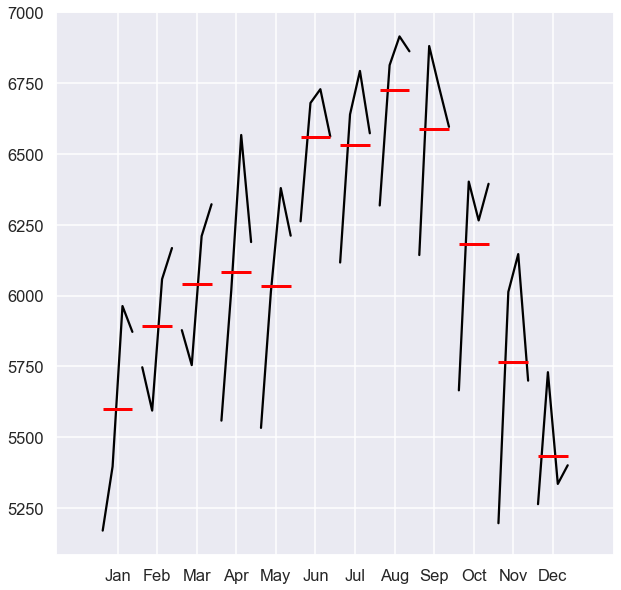

In [907]:
month_plot(df_acf_pacf_monthly_plots[['CA_3']]);

In [908]:
gc.collect()

5257

## Plotting quaterly data using quarter_plot

In [909]:
df_acf_pacf_daily_plots.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
               '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', name='date', length=1461, freq='D')

In [910]:
df_acf_pacf_quarter_plots= df_acf_pacf_daily_plots.resample(rule='Q').mean()

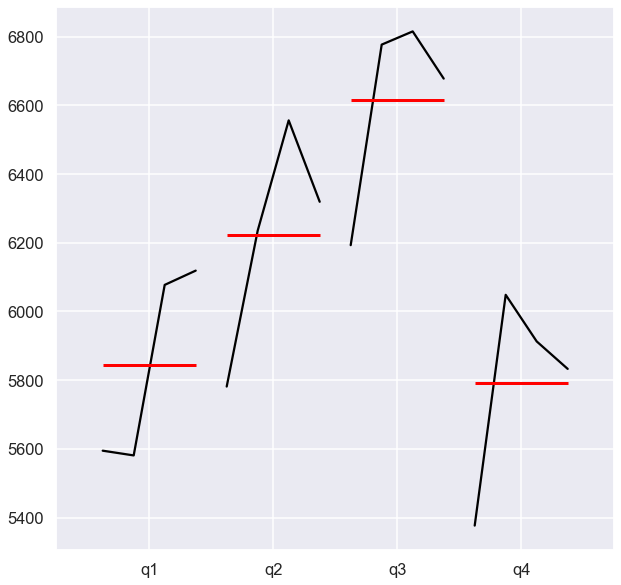

In [911]:
quarter_plot(df_acf_pacf_quarter_plots);

In [912]:
gc.collect()

3354

# 14 Hierarchical time series forecasting

In [913]:
calendar_df = pd.read_csv("C:\\Users\\ajit2\\Desktop\\Capstone- use this\\calendar.csv",parse_dates=True)
calendar_df.head(5)

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [914]:
calendar_df = calendar_df.loc[:, ['date', 'wm_yr_wk', 'd']]

In [915]:
df=pd.read_csv("C:\\Users\\ajit2\\Desktop\\Capstone- use this\\sales_train_evaluation.csv")

In [916]:
gc.collect()

0

In [917]:
df.head(10)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   
5  HOBBIES_1_006_CA_1_evaluation  HOBBIES_1_006  HOBBIES_1  HOBBIES     CA_1   
6  HOBBIES_1_007_CA_1_evaluation  HOBBIES_1_007  HOBBIES_1  HOBBIES     CA_1   
7  HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
8  HOBBIES_1_009_CA_1_evaluation  HOBBIES_1_009  HOBBIES_1  HOBBIES     CA_1   
9  HOBBIES_1_010_CA_1_evaluation  HOBBIES_1_010  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  d_1935  d_1936  \
0       CA    0    0    0    0  ...       2       4       0       0       0   
1       CA    0    0    0    0  ...       0       1       2       1       1   
2       CA    0    0    0    0  ...       1       0       2       0       0   
3       CA    0    0    0    0  ...       1       1       0       4       0   
4       CA    0    0    0    0  ...       0       0       0       2       1   
5       CA    0    0    0    0  ...       2       1       0       0       1   
6       CA    0    0    0    0  ...       0       1       0       0       0   
7       CA   12   15    0    0  ...       7       0       6       0      15   
8       CA    2    0    7    3  ...       1       0       0       0       0   
9       CA    0    0    1    0  ...       0       0       1       0       2   

   d_1937  d_1938  d_1939  d_1940  d_1941  
0       0       3       3       0       1  
1       0       0       0       0       0  
2       0       2       3       0       1  
3       1       3       0       2       6  
4       0       0       2       1       0  
5       0       0       5       2       0  
6       1       0       1       1       0  
7       5       4       1      40      32  
8       0       0       0       1       0  
9       1       1       0       0       1  

[10 rows x 1947 columns]

In [918]:
df_T = df.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
df_T

id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                 ...            ...        ...      ...   
59181085    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
59181086    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
59181087    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
59181088    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
59181089    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

         store_id state_id variable  value  
0            CA_1       CA      d_1      0  
1            CA_1       CA      d_1      0  
2            CA_1       CA      d_1      0  
3            CA_1       CA      d_1      0  
4            CA_1       CA      d_1      0  
...           ...      ...      ...    ...  
59181085     WI_3       WI   d_1941      1  
59181086     WI_3       WI   d_1941      0  
59181087     WI_3       WI   d_1941      2  
59181088     WI_3       WI   d_1941      0  
59181089     WI_3       WI   d_1941      1  

[59181090 rows x 8 columns]

In [919]:
gc.collect()

0

In [920]:
sales_df = df_T.merge(calendar_df, left_on='variable', right_on='d', how='left')
sales_df.head(10)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   
5  HOBBIES_1_006_CA_1_evaluation  HOBBIES_1_006  HOBBIES_1  HOBBIES     CA_1   
6  HOBBIES_1_007_CA_1_evaluation  HOBBIES_1_007  HOBBIES_1  HOBBIES     CA_1   
7  HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
8  HOBBIES_1_009_CA_1_evaluation  HOBBIES_1_009  HOBBIES_1  HOBBIES     CA_1   
9  HOBBIES_1_010_CA_1_evaluation  HOBBIES_1_010  HOBBIES_1  HOBBIES     CA_1   

  state_id variable  value        date  wm_yr_wk    d  
0       CA      d_1      0  2011-01-29     11101  d_1  
1       CA      d_1      0  2011-01-29     11101  d_1  
2       CA      d_1      0  2011-01-29     11101  d_1  
3       CA      d_1      0  2011-01-29     11101  d_1  
4       CA      d_1      0  2011-01-29     11101  d_1  
5       CA      d_1      0  2011-01-29     11101  d_1  
6       CA      d_1      0  2011-01-29     11101  d_1  
7       CA      d_1     12  2011-01-29     11101  d_1  
8       CA      d_1      2  2011-01-29     11101  d_1  
9       CA      d_1      0  2011-01-29     11101  d_1

In [921]:
sales_df['date'] = pd.to_datetime(sales_df['date'],infer_datetime_format=True)
#sales_df['date'].min, 

In [922]:
sales_df['date'].min(), sales_df['date'].max()

(Timestamp('2011-01-29 00:00:00'), Timestamp('2016-05-22 00:00:00'))

In [923]:
#sales_df.date.asfreq(freq='D')

In [924]:
sales_df["day_of_week"] = sales_df.date.dt.dayofweek

In [925]:
sales_df.rename(columns={'value': 'sales_qty'}, inplace=True)

In [926]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 59181089
Data columns (total 12 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           object        
 1   item_id      object        
 2   dept_id      object        
 3   cat_id       object        
 4   store_id     object        
 5   state_id     object        
 6   variable     object        
 7   sales_qty    int64         
 8   date         datetime64[ns]
 9   wm_yr_wk     int64         
 10  d            object        
 11  day_of_week  int64         
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 5.7+ GB


In [927]:
sales_df["is_weekend"] = np.where(sales_df["day_of_week"]>4, 1, 0)

In [928]:
df1 = sales_df[['date','store_id','sales_qty','state_id','is_weekend']]

In [929]:
df1.head(10) 

date store_id  sales_qty state_id  is_weekend
0 2011-01-29     CA_1          0       CA           1
1 2011-01-29     CA_1          0       CA           1
2 2011-01-29     CA_1          0       CA           1
3 2011-01-29     CA_1          0       CA           1
4 2011-01-29     CA_1          0       CA           1
5 2011-01-29     CA_1          0       CA           1
6 2011-01-29     CA_1          0       CA           1
7 2011-01-29     CA_1         12       CA           1
8 2011-01-29     CA_1          2       CA           1
9 2011-01-29     CA_1          0       CA           1

In [930]:
gc.collect()

0

In [931]:
# create the long format matrix: individual stores

In [932]:
df_ind = df1.groupby(['date', 'store_id'])[['sales_qty']].sum()
df_ind.reset_index(inplace=True)
df_ind.columns = ['ds', 'unique_id', 'sales']
df_ind

ds unique_id  sales
0     2011-01-29      CA_1   4337
1     2011-01-29      CA_2   3494
2     2011-01-29      CA_3   4739
3     2011-01-29      CA_4   1625
4     2011-01-29      TX_1   2556
...          ...       ...    ...
19405 2016-05-22      TX_2   5217
19406 2016-05-22      TX_3   4974
19407 2016-05-22      WI_1   5054
19408 2016-05-22      WI_2   5068
19409 2016-05-22      WI_3   4757

[19410 rows x 3 columns]

In [933]:
# create the long format matrix: State Level

In [934]:
df_sta = df1.groupby(['date', 'state_id'])[['sales_qty']].sum()
df_sta.reset_index(inplace=True)
df_sta.columns = ['ds', 'unique_id', 'sales']
df_sta

ds unique_id  sales
0    2011-01-29        CA  14195
1    2011-01-29        TX   9438
2    2011-01-29        WI   8998
3    2011-01-30        CA  13805
4    2011-01-30        TX   9630
...         ...       ...    ...
5818 2016-05-21        TX  13681
5819 2016-05-21        WI  14734
5820 2016-05-22        CA  24644
5821 2016-05-22        TX  14815
5822 2016-05-22        WI  14879

[5823 rows x 3 columns]

In [935]:
gc.collect()

0

In [936]:
# create the long format matrix: total level

In [937]:
df_tot = df1.groupby(['date'])[['sales_qty']].sum()
df_tot.reset_index(inplace=True)
df_tot['unique_id'] = 'Total'
df_tot.columns = ['ds', 'sales', 'unique_id' ]
df_tot

ds  sales unique_id
0    2011-01-29  32631     Total
1    2011-01-30  31749     Total
2    2011-01-31  23783     Total
3    2011-02-01  25412     Total
4    2011-02-02  19146     Total
...         ...    ...       ...
1936 2016-05-18  37096     Total
1937 2016-05-19  36963     Total
1938 2016-05-20  42552     Total
1939 2016-05-21  51518     Total
1940 2016-05-22  54338     Total

[1941 rows x 3 columns]

In [938]:
# combine all three

In [939]:
dfx = pd.concat([df_ind, df_sta, df_tot], axis = 0)
dfx

ds unique_id  sales
0    2011-01-29      CA_1   4337
1    2011-01-29      CA_2   3494
2    2011-01-29      CA_3   4739
3    2011-01-29      CA_4   1625
4    2011-01-29      TX_1   2556
...         ...       ...    ...
1936 2016-05-18     Total  37096
1937 2016-05-19     Total  36963
1938 2016-05-20     Total  42552
1939 2016-05-21     Total  51518
1940 2016-05-22     Total  54338

[27174 rows x 3 columns]

In [940]:
print(df_ind.shape, df_sta.shape, df_tot.shape, dfx.shape)

(19410, 3) (5823, 3) (1941, 3) (27174, 3)


In [941]:
# format
xset = set(dfx.unique_id)
#xset

In [942]:
#xset 

In [943]:
dfx.columns = ['ds','unique_id', 'y']
dfx['ds'] = pd.to_datetime(dfx['ds'])
dfx.head(10)

ds unique_id     y
0 2011-01-29      CA_1  4337
1 2011-01-29      CA_2  3494
2 2011-01-29      CA_3  4739
3 2011-01-29      CA_4  1625
4 2011-01-29      TX_1  2556
5 2011-01-29      TX_2  3852
6 2011-01-29      TX_3  3030
7 2011-01-29      WI_1  2704
8 2011-01-29      WI_2  2256
9 2011-01-29      WI_3  4038

In [944]:
#The steps above give us a dataframe representing a hierarchical structure:
   # Total=CA+TX+WI
    # CA=CA1+CA2+CA3+CA4
   # TX=TX1+TX2+TX3
   # WI=WI1+WI2+W

In [945]:
# Next step is the summing matrix: recall that  S  is an  m x n   matrix 
# where  m  = number of unique series across all levels (stores + states + total) 
# and  n  = (stores)

In [946]:
S = np.zeros((len(xset), len([f for f in xset if '_' in f])))

In [947]:
# rows / columns
list1 = ['Total', 'CA','CA_1','CA_2','CA_3','CA_4','TX','TX_1','TX_2','TX_3','WI','WI_1','WI_2','WI_3']
list2 = ['CA_1','CA_2','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3']
S = pd.DataFrame(S); S.index = list1; S.columns = list2

In [948]:
S

CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3
Total   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
CA      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
CA_1    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
CA_2    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
CA_3    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
CA_4    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
TX      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
TX_1    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
TX_2    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
TX_3    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
WI      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
WI_1    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
WI_2    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
WI_3    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

In [949]:
gc.collect()

0

In [950]:
# encode the hierarchical structure
S.loc['Total'] = 1
S.loc['CA'][['CA_1','CA_2','CA_3', 'CA_4']] = 1
S.loc['TX'][['TX_1','TX_2','TX_3']] = 1
S.loc['WI'][['WI_1','WI_2','WI_3']] = 1
S

CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3
Total   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0
CA      1.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0
CA_1    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
CA_2    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
CA_3    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
CA_4    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
TX      0.0   0.0   0.0   0.0   1.0   1.0   1.0   0.0   0.0   0.0
TX_1    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
TX_2    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
TX_3    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
WI      0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0
WI_1    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
WI_2    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
WI_3    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

In [951]:
## The hierarchicalforecast implementation requires tags: a dictionary describing the composition of each level:

In [952]:
tags = {}
tags['Country'] = np.array(['Total'], dtype=object)
tags['Country/State'] = np.array(['CA', 'TX', 'WI'], dtype=object)
tags['Country/State/Store'] = np.array(['CA_1', 'CA_2', 'CA_3', 'CA_4',  
                                        'TX_1', 'TX_2', 'TX_3',
                                        'WI_1', 'WI_2', 'WI_3'], dtype=object)
tags

{'Country': array(['Total'], dtype=object),
 'Country/State': array(['CA', 'TX', 'WI'], dtype=object),
 'Country/State/Store': array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
        'WI_2', 'WI_3'], dtype=object)}

In [953]:
dfx

ds unique_id      y
0    2011-01-29      CA_1   4337
1    2011-01-29      CA_2   3494
2    2011-01-29      CA_3   4739
3    2011-01-29      CA_4   1625
4    2011-01-29      TX_1   2556
...         ...       ...    ...
1936 2016-05-18     Total  37096
1937 2016-05-19     Total  36963
1938 2016-05-20     Total  42552
1939 2016-05-21     Total  51518
1940 2016-05-22     Total  54338

[27174 rows x 3 columns]

In [954]:
dfx.columns = ['ds','unique_id', 'y']

In [955]:
horizon = 28

In [956]:
x_test = dfx.groupby('unique_id').tail(horizon)
x_test 

ds unique_id      y
19130 2016-04-25      CA_1   4472
19131 2016-04-25      CA_2   3926
19132 2016-04-25      CA_3   6359
19133 2016-04-25      CA_4   2767
19134 2016-04-25      TX_1   3076
...          ...       ...    ...
1936  2016-05-18     Total  37096
1937  2016-05-19     Total  36963
1938  2016-05-20     Total  42552
1939  2016-05-21     Total  51518
1940  2016-05-22     Total  54338

[392 rows x 3 columns]

In [957]:
x_train = dfx.drop(x_test.index)

In [958]:
x_test = x_test.set_index('unique_id')
x_train = x_train.set_index('unique_id')

In [959]:
x_train

ds      y
unique_id                  
CA_1      2011-01-29   4337
CA_2      2011-01-29   3494
CA_3      2011-01-29   4739
CA_4      2011-01-29   1625
TX_1      2011-01-29   2556
...              ...    ...
Total     2016-04-20  35343
Total     2016-04-21  35033
Total     2016-04-22  40517
Total     2016-04-23  48962
Total     2016-04-24  49795

[26642 rows x 2 columns]

In [960]:
x_train.index.unique()

Index(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2',
       'WI_3', 'CA', 'TX', 'WI', 'Total'],
      dtype='object', name='unique_id')

In [961]:
x_train

ds      y
unique_id                  
CA_1      2011-01-29   4337
CA_2      2011-01-29   3494
CA_3      2011-01-29   4739
CA_4      2011-01-29   1625
TX_1      2011-01-29   2556
...              ...    ...
Total     2016-04-20  35343
Total     2016-04-21  35033
Total     2016-04-22  40517
Total     2016-04-23  48962
Total     2016-04-24  49795

[26642 rows x 2 columns]

In [962]:
gc.collect()

0

In [963]:
# Compute base auto-ARIMA predictions
fcst = StatsForecast(df = x_train, models=[AutoARIMA(season_length= 7)], freq='D', n_jobs=-1)



In [964]:
x_hat = fcst.forecast(h = horizon)

In [965]:
x_hat.index.unique()

Index(['CA', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX', 'TX_1', 'TX_2', 'TX_3',
       'Total', 'WI', 'WI_1', 'WI_2', 'WI_3'],
      dtype='object', name='unique_id')

In [966]:
x_test

ds      y
unique_id                  
CA_1      2016-04-25   4472
CA_2      2016-04-25   3926
CA_3      2016-04-25   6359
CA_4      2016-04-25   2767
TX_1      2016-04-25   3076
...              ...    ...
Total     2016-05-18  37096
Total     2016-05-19  36963
Total     2016-05-20  42552
Total     2016-05-21  51518
Total     2016-05-22  54338

[392 rows x 2 columns]

In [967]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, CA_1 to Total
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      392 non-null    datetime64[ns]
 1   y       392 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 9.2+ KB


In [968]:
x_hat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, CA to WI_3
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         392 non-null    datetime64[ns]
 1   AutoARIMA  392 non-null    float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 15.8+ KB


In [969]:
x_test['ds'] = pd.to_datetime(x_test['ds'])

In [970]:
#What do error metrics look like for the raw (unreconciled) forecasts?

In [971]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x.values,y.values)) ,4))

In [972]:
xmat = pd.merge(left = x_test, right = x_hat, on = ['ds', 'unique_id'])
xmat.columns = [['ds', 'y', 'pred']]
print('overall rmse: ' + str(my_rmse(xmat['y'], xmat['pred'])))
for k in tags.keys():
    print(k + ' rmse: ' + str(my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred'])))

overall rmse: [1423.2885]
Country rmse: [4387.3045]
Country/State rmse: [1447.9724]
Country/State/Store rmse: [531.2429]


In [973]:
xmat = pd.merge(left = x_test, right = x_hat, on = ['ds', 'unique_id'])
xmat.head(3)

ds     y    AutoARIMA
unique_id                              
CA_1      2016-04-25  4472  4426.788574
CA_2      2016-04-25  3926  3857.500977
CA_3      2016-04-25  6359  6099.537598

In [974]:
xmat.index.unique()

Index(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2',
       'WI_3', 'CA', 'TX', 'WI', 'Total'],
      dtype='object', name='unique_id')

In [975]:
xmat.reset_index(inplace=True)
#xmat.set_index('ds',inplace=True)
xmat

unique_id         ds      y     AutoARIMA
0        CA_1 2016-04-25   4472   4426.788574
1        CA_2 2016-04-25   3926   3857.500977
2        CA_3 2016-04-25   6359   6099.537598
3        CA_4 2016-04-25   2767   2713.364990
4        TX_1 2016-04-25   3076   3056.112549
..        ...        ...    ...           ...
387     Total 2016-05-18  37096  35446.519531
388     Total 2016-05-19  36963  36082.328125
389     Total 2016-05-20  42552  39852.007812
390     Total 2016-05-21  51518  49854.285156
391     Total 2016-05-22  54338  49705.316406

[392 rows x 4 columns]

In [976]:
xmat.set_index('ds',inplace=True)

In [977]:
gc.collect()

0

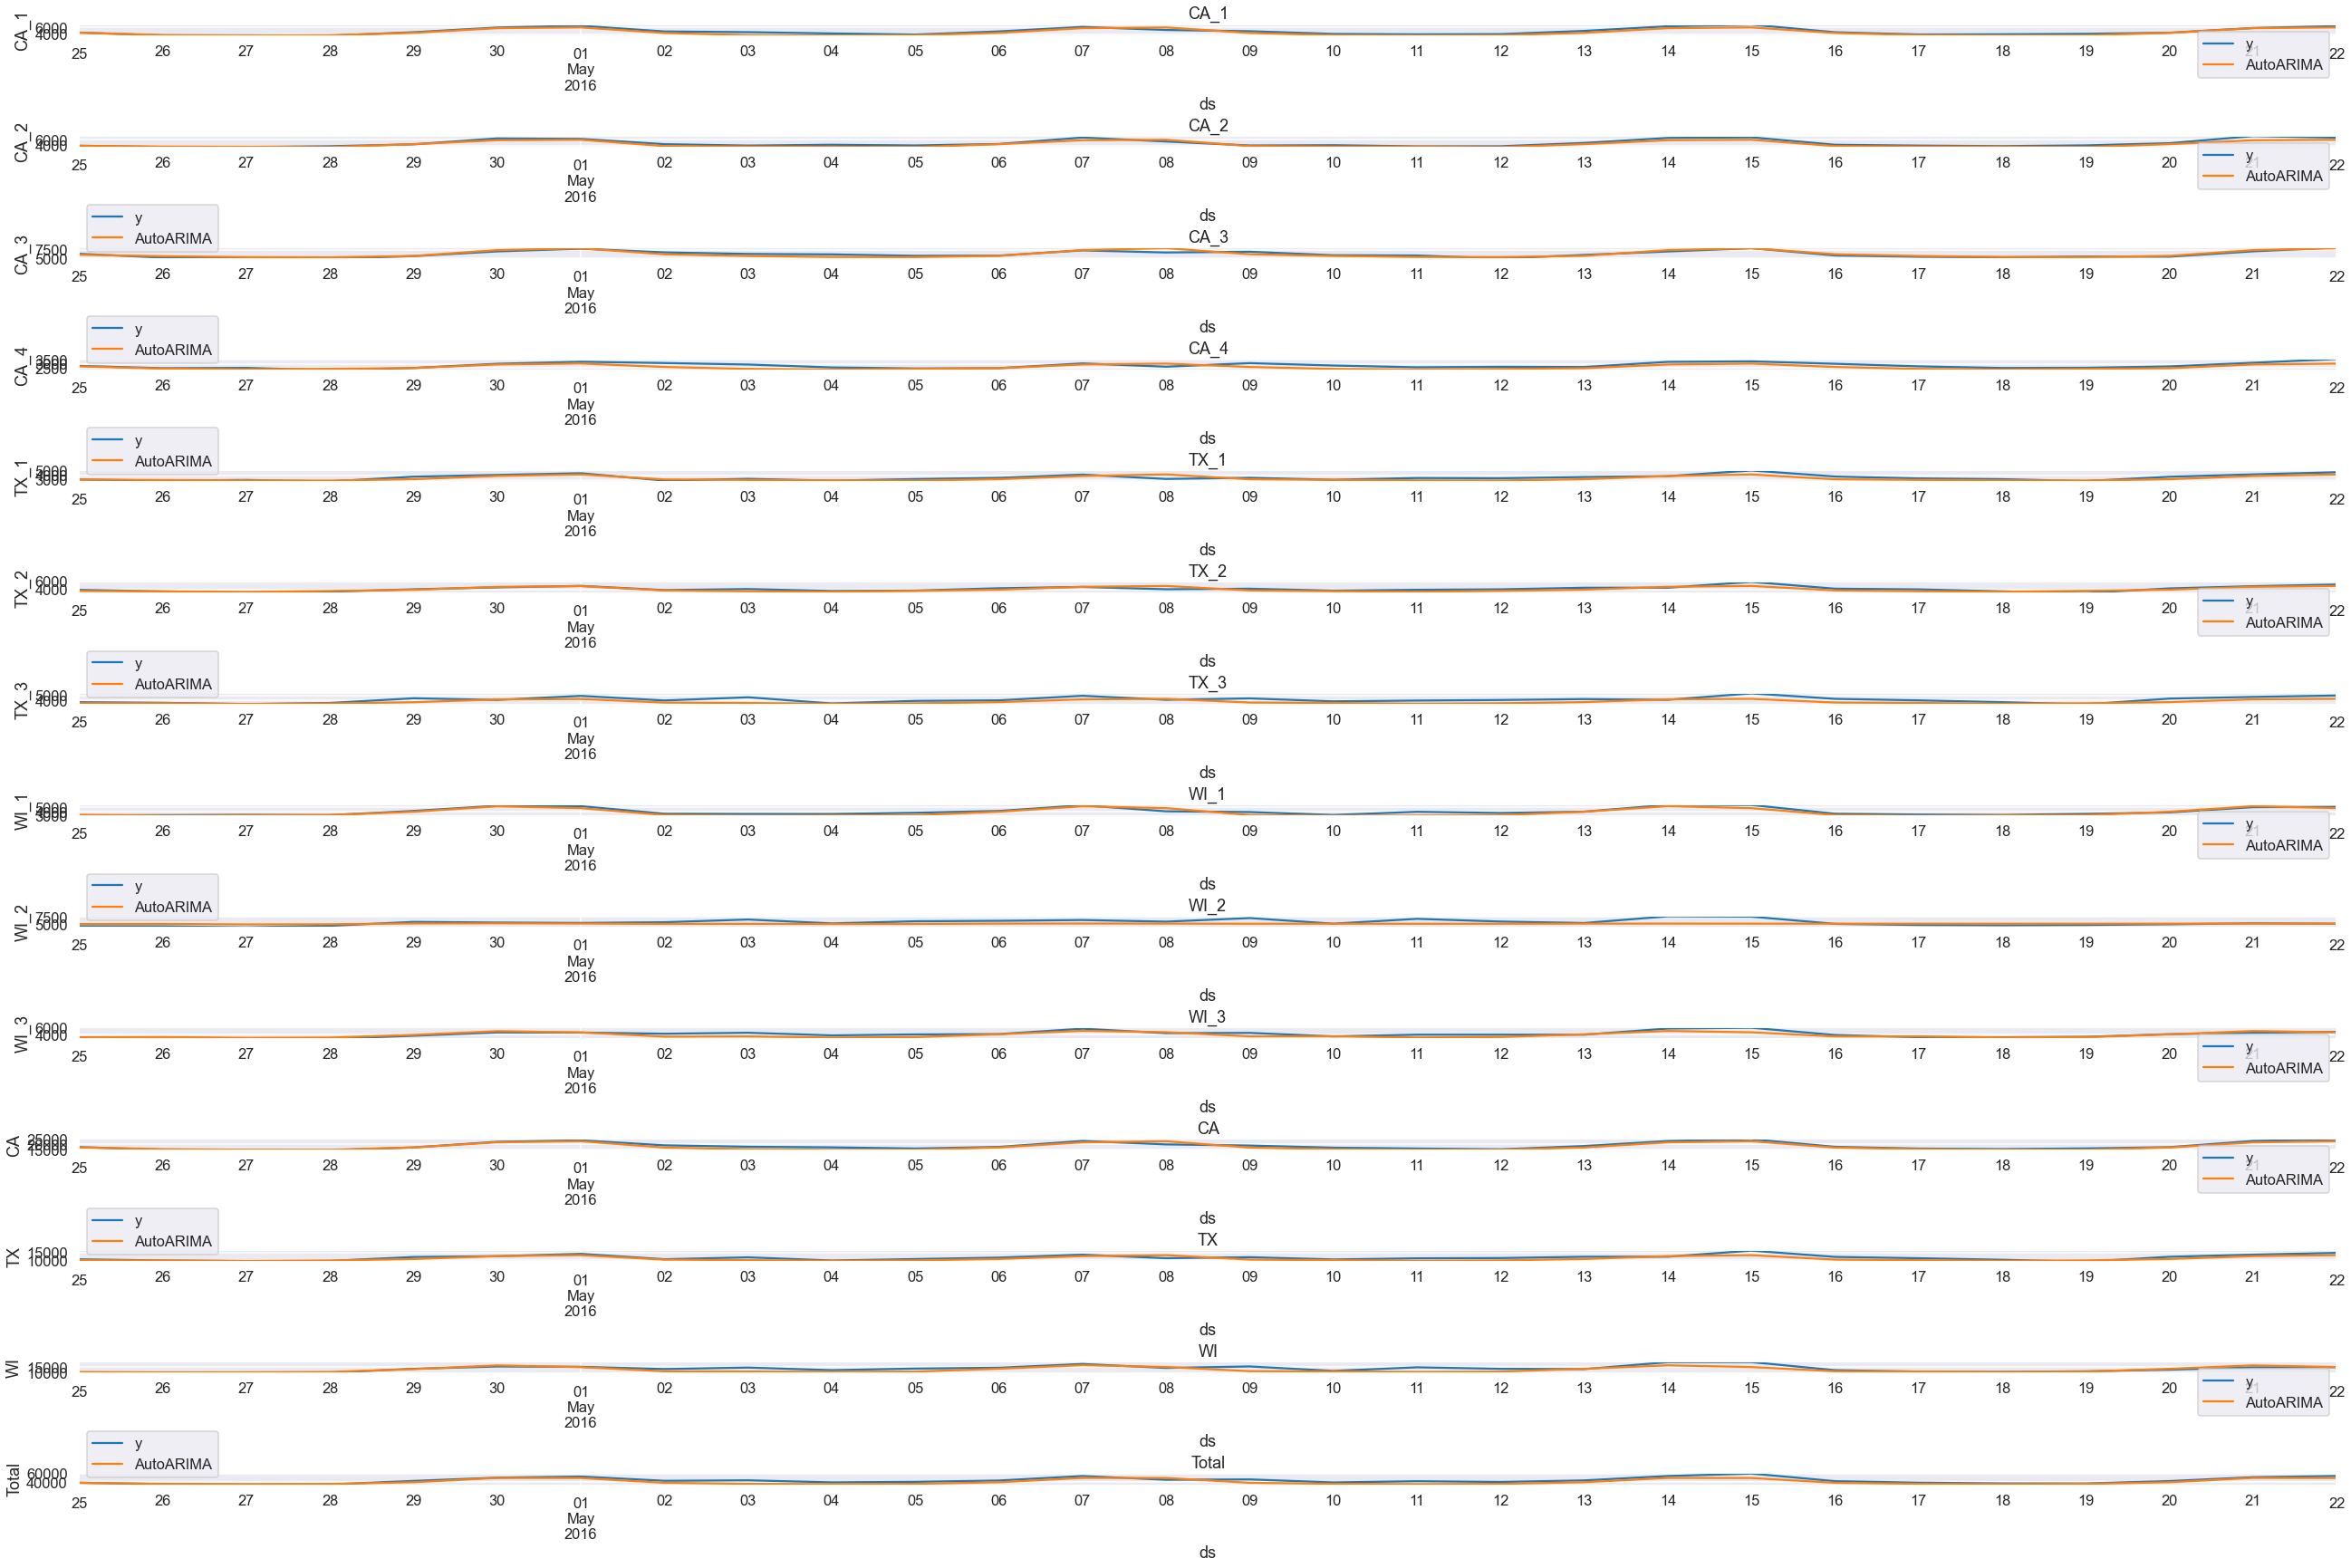

In [978]:
# Plot the time series.
x1=list(xmat.unique_id.unique())
#x1=['CA_1','CA_2']

fig, ax = plt.subplots(nrows=len(x1), figsize=[36, 24])
ax = ax.flatten()

for ix, days in enumerate(x1):

    # Plot the time series
    xmat.query(f"unique_id=='{days}'")[['y']].plot(ax=ax[ix])
    xmat.query(f"unique_id=='{days}'")[['AutoARIMA']].plot(ax=ax[ix])

    # Add title
    ax[ix].set_title(days)

    # the y axis label
    ax[ix].set_ylabel(days)

   # plt.show()
fig.tight_layout()

In [979]:
gc.collect()

4115

In [980]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x.values,y.values)) ,4))

In [981]:
xmat.head(10)

unique_id     y    AutoARIMA
ds                                     
2016-04-25      CA_1  4472  4426.788574
2016-04-25      CA_2  3926  3857.500977
2016-04-25      CA_3  6359  6099.537598
2016-04-25      CA_4  2767  2713.364990
2016-04-25      TX_1  3076  3056.112549
2016-04-25      TX_2  3883  3603.784180
2016-04-25      TX_3  3703  3509.850830
2016-04-25      WI_1  3166  3254.866455
2016-04-25      WI_2  4178  4952.360352
2016-04-25      WI_3  3263  3241.106689

In [982]:
print('overall rmse: ' + str(my_rmse(xmat['y'], xmat['AutoARIMA'])))

overall rmse: 1423.2885


In [983]:
for k in tags.keys():
    print(k)

Country
Country/State
Country/State/Store


In [984]:
xmat.unique_id.unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3', 'CA', 'TX', 'WI', 'Total'], dtype=object)

## Bottom up forecasting

In [985]:
x_hat.shape

(392, 2)

In [986]:
x_train.shape

(26642, 2)

In [987]:
x_train.index.unique()

Index(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2',
       'WI_3', 'CA', 'TX', 'WI', 'Total'],
      dtype='object', name='unique_id')

In [988]:
x_hat.index.unique()

Index(['CA', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX', 'TX_1', 'TX_2', 'TX_3',
       'Total', 'WI', 'WI_1', 'WI_2', 'WI_3'],
      dtype='object', name='unique_id')

In [989]:
# Reconcile the base predictions
reconcilers = [
    BottomUp()
]

hrec = HierarchicalReconciliation(reconcilers = reconcilers)
x_hat_rec = hrec.reconcile(x_hat, S,tags,x_train)

In [990]:
def mse(y, y_hat):
    return np.mean((y-y_hat)**2)

In [991]:
x_hat_rec

ds     AutoARIMA  AutoARIMA/BottomUp
unique_id                                             
CA        2016-04-25  17165.101562                 0.0
CA        2016-04-26  15681.851562                 0.0
CA        2016-04-27  15082.719727                 0.0
CA        2016-04-28  15056.821289                 0.0
CA        2016-04-29  17193.726562                 0.0
...              ...           ...                 ...
WI_3      2016-05-18   3211.083740                 0.0
WI_3      2016-05-19   3330.059570                 0.0
WI_3      2016-05-20   4069.292236                 0.0
WI_3      2016-05-21   4999.510742                 0.0
WI_3      2016-05-22   4629.270020                 0.0

[392 rows x 3 columns]

In [992]:
x_test

ds      y
unique_id                  
CA_1      2016-04-25   4472
CA_2      2016-04-25   3926
CA_3      2016-04-25   6359
CA_4      2016-04-25   2767
TX_1      2016-04-25   3076
...              ...    ...
Total     2016-05-18  37096
Total     2016-05-19  36963
Total     2016-05-20  42552
Total     2016-05-21  51518
Total     2016-05-22  54338

[392 rows x 2 columns]

In [993]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test, tags=tags, benchmark='AutoARIMA')

AutoARIMA AutoARIMA/BottomUp
level               metric                                 
Overall             mse-scaled       1.0         101.395405
Country             mse-scaled       1.0         102.830203
Country/State       mse-scaled       1.0         109.374535
Country/State/Store mse-scaled       1.0          73.826269

In [994]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])
xmat.head(3)

ds     y    AutoARIMA  AutoARIMA/BottomUp
unique_id                                                  
CA_1      2016-04-25  4472  4426.788574                 0.0
CA_2      2016-04-25  3926  3857.500977                 0.0
CA_3      2016-04-25  6359  6099.537598                 0.0

In [995]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])
xmat.columns = [['ds', 'y', 'pred_orig', 'pred_reconciled']]
mse1 = my_rmse(xmat['y'], xmat['pred_orig'])
mse2 = my_rmse(xmat['y'], xmat['pred_reconciled'])
print('overall rmse: ' + str(mse1) + ' -> ' + str(mse2))

for k in tags.keys():
    mse1 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_orig'])
    mse2 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_reconciled'])

    print(k + ' rmse: ' + str(mse1) + ' -> ' + str(mse2) )

overall rmse: 1423.2885 -> 14331.8444
Country rmse: 4387.3045 -> 44489.5613
Country/State rmse: 1447.9724 -> 15143.2259
Country/State/Store rmse: 531.2429 -> 4564.5565


## TopDown forecasting

In [996]:
# Reconcile the base predictions
reconcilers = [
    TopDown(method='forecast_proportions')
]

hrec = HierarchicalReconciliation(reconcilers = reconcilers)
x_hat_rec = hrec.reconcile(x_hat, S,tags,x_train)

In [997]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test, 
                   tags=tags, benchmark='AutoARIMA')

AutoARIMA  \
level               metric                 
Overall             mse-scaled       1.0   
Country             mse-scaled       1.0   
Country/State       mse-scaled       1.0   
Country/State/Store mse-scaled       1.0   

                               AutoARIMA/TopDown_method-forecast_proportions  
level               metric                                                    
Overall             mse-scaled                                      8.305497  
Country             mse-scaled                                           1.0  
Country/State       mse-scaled                                      1.263597  
Country/State/Store mse-scaled                                     73.826269

In [998]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])
xmat.columns = [['ds', 'y', 'pred_orig', 'pred_reconciled']]
mse1 = my_rmse(xmat['y'], xmat['pred_orig'])
mse2 = my_rmse(xmat['y'], xmat['pred_reconciled'])
print('overall rmse: ' + str(mse1) + ' -> ' + str(mse2))

for k in tags.keys():
    mse1 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_orig'])
    mse2 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_reconciled'])

    print(k + ' rmse: ' + str(mse1) + ' -> ' + str(mse2) )

overall rmse: 1423.2885 -> 4101.812
Country rmse: 4387.3045 -> 4387.3045
Country/State rmse: 1447.9724 -> 1627.6635
Country/State/Store rmse: 531.2429 -> 4564.5565


In [999]:
gc.collect()

0

In [1000]:
x2=xmat.reset_index()

In [1001]:
x2.columns=x2.columns.get_level_values(0)

In [1002]:
gc.collect()

0

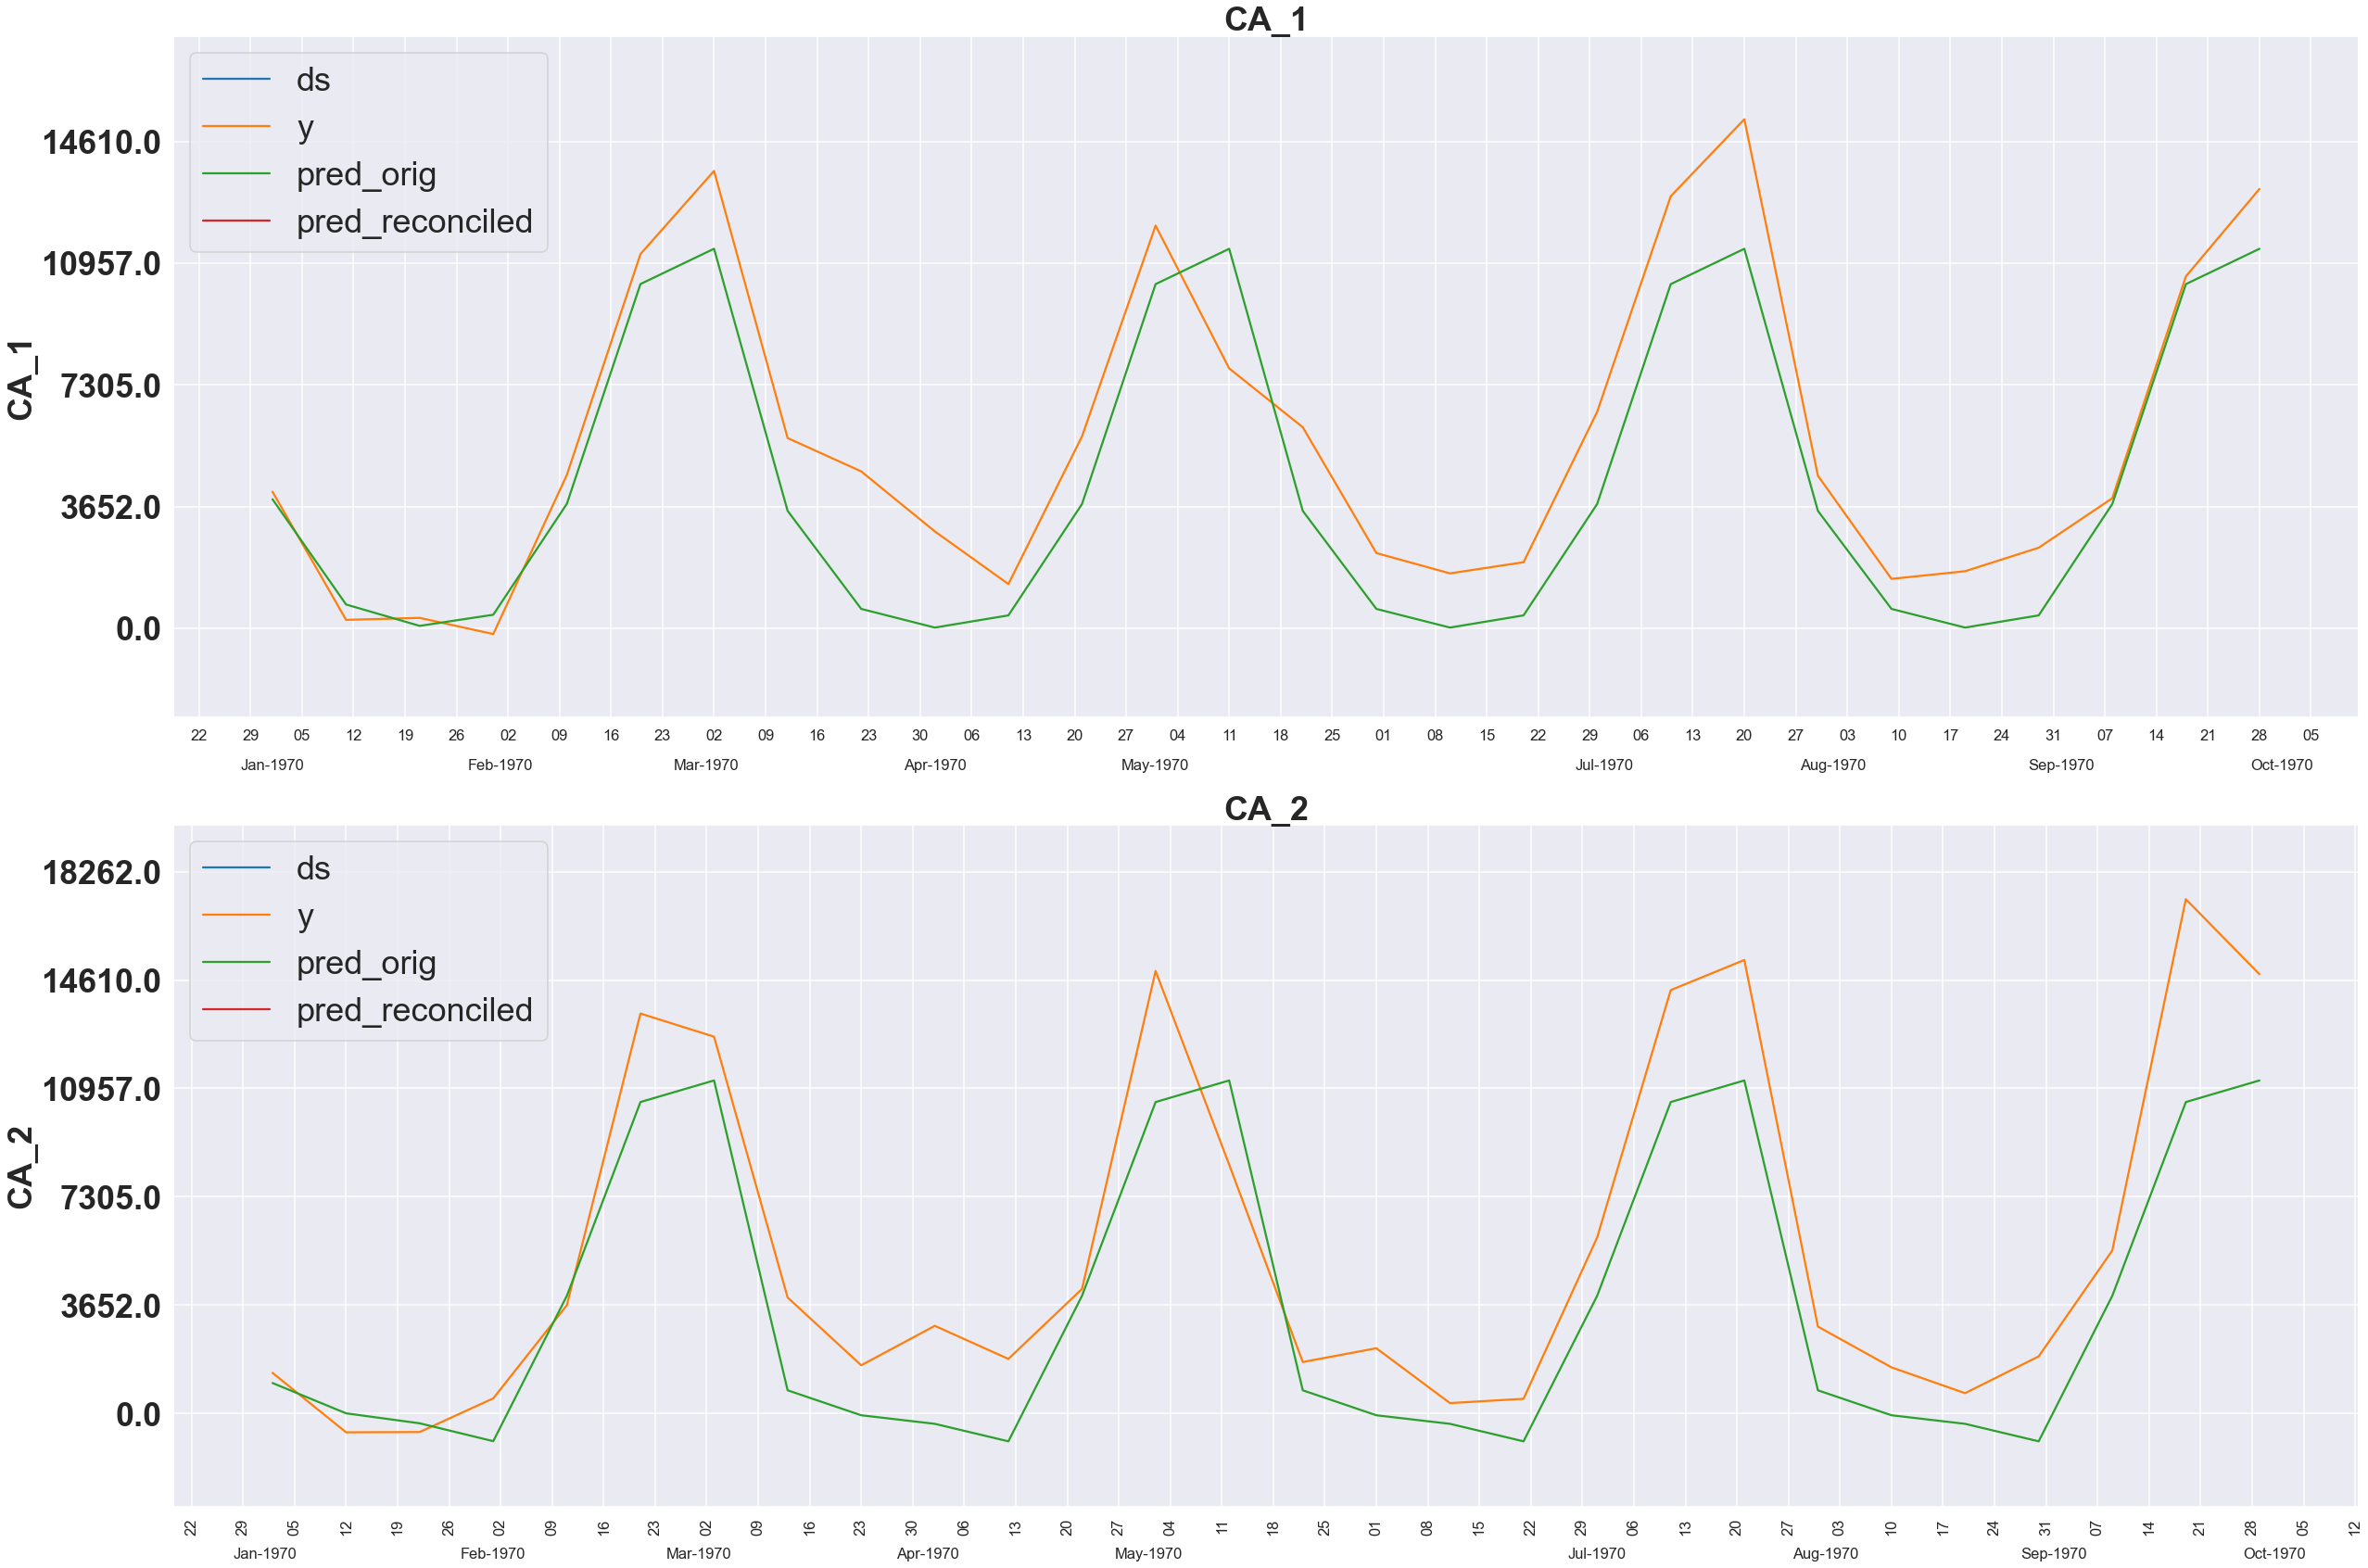

In [1003]:
# Plot the time series.

 

x1=['CA_1','CA_2']

fig, ax = plt.subplots(nrows=len(x1), figsize=[36, 24]
                      )
ax = ax.flatten()


for ix,store in enumerate(x1):
   

    # Plot the time series
    x2.query(f"unique_id=='{store}'")[['y','pred_orig','pred_reconciled']].asfreq(freq='D')
    x2.query(f"unique_id=='{store}'")[['ds','y']].plot(ax=ax[ix])
    x2.query(f"unique_id=='{store}'")[['pred_orig']].plot(ax=ax[ix],)
    x2.query(f"unique_id=='{store}'")[['pred_reconciled']].plot(ax=ax[ix])

    # Add title
    ax[ix].set_title(store,fontweight='bold',fontsize=36)

    # the y axis label
    ax[ix].set_ylabel(store,fontweight='bold',fontsize=36)
    ax[ix].legend(loc=2, prop={'size': 36})
    
    ax[ix].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
    ax[ix].xaxis.set_major_formatter(mdates.DateFormatter('%d'))

    ax[ix].xaxis.set_minor_locator(mdates.MonthLocator())
    ax[ix].xaxis.set_minor_formatter(mdates.DateFormatter('\n\n%b-%Y'))
    _ = plt.xticks(rotation=90)   
        
    #ax[ix].xaxis.set_tick_params(weight='bold',size=36)
    ax[ix].set_yticklabels(ax[ix].get_yticks(), weight='bold',size=36)
    ax[ix].set_ylim([x2.query(f"unique_id=='{store}'")['y'].min()-500, x2.query(f"unique_id=='{store}'")['y'].max()+500])
    #ax[ix].legend( loc='center left',  bbox_to_anchor=(1.05, 0.5),
           #fontsize=12)

   # plt.show()
fig.tight_layout(pad=5)

In [1004]:
gc.collect()

58680

# 15 Feature creation for time series using ML

In [1005]:
# creating a data frame for forecasting

In [1006]:
df_final_with_price_inventory_class.columns

Index(['store_id', 'item_id', 'cat_id', 'd', 'unit_sales', 'date', 'wm_yr_wk',
       'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
       'sell_price', 'Inventory_class', 'Holidays'],
      dtype='object')

In [1007]:
df_final_with_price_inventory_class.head(10)

store_id      item_id cat_id     d  unit_sales       date  wm_yr_wk  \
1612      CA_3  FOODS_1_001  FOODS   d_1           1 2011-01-29     11101   
4661      CA_3  FOODS_1_001  FOODS   d_2           2 2011-01-30     11101   
7710      CA_3  FOODS_1_001  FOODS   d_3           1 2011-01-31     11101   
10759     CA_3  FOODS_1_001  FOODS   d_4           1 2011-02-01     11101   
13808     CA_3  FOODS_1_001  FOODS   d_5           1 2011-02-02     11101   
16857     CA_3  FOODS_1_001  FOODS   d_6           2 2011-02-03     11101   
19906     CA_3  FOODS_1_001  FOODS   d_7           0 2011-02-04     11101   
22955     CA_3  FOODS_1_001  FOODS   d_8           1 2011-02-05     11102   
26004     CA_3  FOODS_1_001  FOODS   d_9           1 2011-02-06     11102   
29053     CA_3  FOODS_1_001  FOODS  d_10           1 2011-02-07     11102   

         weekday  wday  month  ...  event_name_1 event_type_1 event_name_2  \
1612    Saturday     1      1  ...           NaN          NaN          NaN   
4661      Sunday     2      1  ...           NaN          NaN          NaN   
7710      Monday     3      1  ...           NaN          NaN          NaN   
10759    Tuesday     4      2  ...           NaN          NaN          NaN   
13808  Wednesday     5      2  ...           NaN          NaN          NaN   
16857   Thursday     6      2  ...           NaN          NaN          NaN   
19906     Friday     7      2  ...           NaN          NaN          NaN   
22955   Saturday     1      2  ...           NaN          NaN          NaN   
26004     Sunday     2      2  ...     SuperBowl     Sporting          NaN   
29053     Monday     3      2  ...           NaN          NaN          NaN   

      event_type_2 snap_CA  snap_TX  snap_WI  sell_price  Inventory_class  \
1612           NaN       0        0        0         2.0                B   
4661           NaN       0        0        0         2.0                B   
7710           NaN       0        0        0         2.0                B   
10759          NaN       1        1        0         2.0                B   
13808          NaN       1        0        1         2.0                B   
16857          NaN       1        1        1         2.0                B   
19906          NaN       1        0        0         2.0                B   
22955          NaN       1        1        1         2.0                B   
26004          NaN       1        1        1         2.0                B   
29053          NaN       1        1        0         2.0                B   

      Holidays  
1612         0  
4661         0  
7710         0  
10759        0  
13808        0  
16857        0  
19906        0  
22955        0  
26004        1  
29053        0  

[10 rows x 21 columns]

In [1008]:
gc.collect()

0

In [1009]:
# randomly selecting 10 item_ids per Inventory class

In [1010]:
df_final_with_price_inventory_class.Inventory_class.unique()

array(['B', 'A', 'C'], dtype=object)

In [1011]:
samples = []
for group in df_final_with_price_inventory_class.Inventory_class.unique():
    s = df_final_with_price_inventory_class.loc[df_final_with_price_inventory_class.Inventory_class== group]\
    .sample(n=10).reset_index(drop=True)
    samples.append(s)
    
sample = pd.concat(samples, axis=0)


In [1012]:
list12=list(sample['item_id'])
list12

['FOODS_1_142',
 'FOODS_1_002',
 'HOBBIES_1_278',
 'HOBBIES_1_319',
 'FOODS_3_680',
 'FOODS_1_156',
 'FOODS_1_156',
 'HOUSEHOLD_1_153',
 'FOODS_2_137',
 'FOODS_3_105',
 'FOODS_3_424',
 'FOODS_3_329',
 'FOODS_3_249',
 'FOODS_3_368',
 'FOODS_3_638',
 'HOUSEHOLD_1_055',
 'HOUSEHOLD_1_508',
 'HOUSEHOLD_2_197',
 'HOBBIES_2_075',
 'FOODS_2_340',
 'HOUSEHOLD_2_345',
 'HOBBIES_2_139',
 'HOBBIES_1_363',
 'HOBBIES_2_008',
 'HOUSEHOLD_2_310',
 'HOBBIES_1_290',
 'HOUSEHOLD_1_271',
 'FOODS_2_195',
 'HOBBIES_1_171',
 'FOODS_3_425']

In [1013]:
df_final_with_price_inventory_class_FCSTING=df_final_with_price_inventory_class.query('item_id in @list12')

In [1014]:
df_final_with_price_inventory_class_FCSTING.shape

(56289, 21)

In [1015]:
df_final_with_price_inventory_class_FCSTING.columns

Index(['store_id', 'item_id', 'cat_id', 'd', 'unit_sales', 'date', 'wm_yr_wk',
       'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
       'sell_price', 'Inventory_class', 'Holidays'],
      dtype='object')

In [1016]:
FCSTING=df_final_with_price_inventory_class_FCSTING[['date','item_id','unit_sales','snap_CA','Holidays','sell_price', 'Inventory_class', ]]

In [1017]:
FCSTING.shape

(56289, 7)

In [1018]:
FCSTING.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56289 entries, 1613 to 5916500
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             56289 non-null  datetime64[ns]
 1   item_id          56289 non-null  object        
 2   unit_sales       56289 non-null  int64         
 3   snap_CA          56289 non-null  int64         
 4   Holidays         56289 non-null  int32         
 5   sell_price       48666 non-null  float64       
 6   Inventory_class  56289 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(2)
memory usage: 3.2+ MB


In [1019]:
FCSTING

date          item_id  unit_sales  snap_CA  Holidays  \
1613    2011-01-29      FOODS_1_002           1        0         0   
4662    2011-01-30      FOODS_1_002           0        0         0   
7711    2011-01-31      FOODS_1_002           1        0         0   
10760   2011-02-01      FOODS_1_002           2        1         0   
13809   2011-02-02      FOODS_1_002           0        1         0   
...            ...              ...         ...      ...       ...   
5904304 2016-05-18  HOUSEHOLD_2_345           0        0         0   
5907353 2016-05-19  HOUSEHOLD_2_345           1        0         0   
5910402 2016-05-20  HOUSEHOLD_2_345           0        0         0   
5913451 2016-05-21  HOUSEHOLD_2_345           0        0         0   
5916500 2016-05-22  HOUSEHOLD_2_345           1        0         0   

         sell_price Inventory_class  
1613           7.88               B  
4662           7.88               B  
7711           7.88               B  
10760          7.88               B  
13809          7.88               B  
...             ...             ...  
5904304        5.84               C  
5907353        5.84               C  
5910402        5.84               C  
5913451        5.84               C  
5916500        5.84               C  

[56289 rows x 7 columns]

In [1020]:
gc.collect()

0

## Extracting date time Features

In [1021]:
# # Extract date and time features.

# FCSTING["Day"] = FCSTING.index.day
# FCSTING["Week"] = FCSTING.index.isocalendar().week
# FCSTING["Month"] = FCSTING.index.month
# FCSTING["year"] = FCSTING.index.year
# FCSTING["Day_of_week"] = FCSTING.index.day_of_week
# FCSTING["day_of_month"] = FCSTING.index.day
# FCSTING["day_of_year"] = FCSTING.index.dayofyear
# # find out if it is a weekend.
# FCSTING["is_weekend"] = np.where(FCSTING["Day_of_week"]>4, 1, 0)

# # Show new variables
# FCSTING.head()

In [1022]:
# Periodic features

In [1023]:
## Lag features.

In [1024]:
# Window features

In [1025]:
## Feature engineering pipeline

## Extracting date time and cyclical Features

In [1026]:
dtfs = DatetimeFeatures(
    variables=None,  # it identifies the datetime variable automatically
features_to_extract=["day_of_year","week","month",'quarter',"year","day_of_week","day_of_month"]
    )

In [1027]:
pipe = Pipeline([
    
    # create datetime features.
    ('datetime', DatetimeFeatures(
        variables="date",
        features_to_extract=["day_of_year","week","month",'quarter',"year","day_of_week","day_of_month"],
        drop_original=False,
    )),

    # apply sine and cosine transformation.
    ('cyclical', CyclicalFeatures(
        variables=["date_day_of_year","date_week","date_month",'date_quarter',"date_year","date_day_of_week","date_day_of_month"],
    )),
])

In [1028]:
# Extract features
FCSTING1 = pipe.fit_transform(FCSTING)

In [1029]:
FCSTING1.head(10)

date      item_id  unit_sales  snap_CA  Holidays  sell_price  \
1613  2011-01-29  FOODS_1_002           1        0         0        7.88   
4662  2011-01-30  FOODS_1_002           0        0         0        7.88   
7711  2011-01-31  FOODS_1_002           1        0         0        7.88   
10760 2011-02-01  FOODS_1_002           2        1         0        7.88   
13809 2011-02-02  FOODS_1_002           0        1         0        7.88   
16858 2011-02-03  FOODS_1_002           0        1         0        7.88   
19907 2011-02-04  FOODS_1_002           0        1         0        7.88   
22956 2011-02-05  FOODS_1_002           1        1         0        7.88   
26005 2011-02-06  FOODS_1_002           1        1         1        7.88   
29054 2011-02-07  FOODS_1_002           0        1         0        7.88   

      Inventory_class  date_day_of_year  date_week  date_month  ...  \
1613                B                29          4           1  ...   
4662                B                30          4           1  ...   
7711                B                31          5           1  ...   
10760               B                32          5           2  ...   
13809               B                33          5           2  ...   
16858               B                34          5           2  ...   
19907               B                35          5           2  ...   
22956               B                36          5           2  ...   
26005               B                37          5           2  ...   
29054               B                38          6           2  ...   

       date_month_sin  date_month_cos  date_quarter_sin  date_quarter_cos  \
1613         0.500000        0.866025               1.0      6.123234e-17   
4662         0.500000        0.866025               1.0      6.123234e-17   
7711         0.500000        0.866025               1.0      6.123234e-17   
10760        0.866025        0.500000               1.0      6.123234e-17   
13809        0.866025        0.500000               1.0      6.123234e-17   
16858        0.866025        0.500000               1.0      6.123234e-17   
19907        0.866025        0.500000               1.0      6.123234e-17   
22956        0.866025        0.500000               1.0      6.123234e-17   
26005        0.866025        0.500000               1.0      6.123234e-17   
29054        0.866025        0.500000               1.0      6.123234e-17   

       date_year_sin  date_year_cos  date_day_of_week_sin  \
1613       -0.015583       0.999879         -8.660254e-01   
4662       -0.015583       0.999879         -2.449294e-16   
7711       -0.015583       0.999879          0.000000e+00   
10760      -0.015583       0.999879          8.660254e-01   
13809      -0.015583       0.999879          8.660254e-01   
16858      -0.015583       0.999879          1.224647e-16   
19907      -0.015583       0.999879         -8.660254e-01   
22956      -0.015583       0.999879         -8.660254e-01   
26005      -0.015583       0.999879         -2.449294e-16   
29054      -0.015583       0.999879          0.000000e+00   

       date_day_of_week_cos  date_day_of_month_sin  date_day_of_month_cos  
1613                    0.5          -3.943559e-01               0.918958  
4662                    1.0          -2.012985e-01               0.979530  
7711                    1.0          -2.449294e-16               1.000000  
10760                   0.5           2.012985e-01               0.979530  
13809                  -0.5           3.943559e-01               0.918958  
16858                  -1.0           5.712682e-01               0.820763  
19907                  -0.5           7.247928e-01               0.688967  
22956                   0.5           8.486443e-01               0.528964  
26005                   1.0           9.377521e-01               0.347305  
29054                   1.0           9.884683e-01               0.151428  

[10 rows x 28 columns]

In [1030]:
FCSTING2=pd.merge(FCSTING,FCSTING1,on=['date','item_id'],how='left')

In [1031]:
FCSTING2.head(10)

date      item_id  unit_sales_x  snap_CA_x  Holidays_x  sell_price_x  \
0 2011-01-29  FOODS_1_002             1          0           0          7.88   
1 2011-01-30  FOODS_1_002             0          0           0          7.88   
2 2011-01-31  FOODS_1_002             1          0           0          7.88   
3 2011-02-01  FOODS_1_002             2          1           0          7.88   
4 2011-02-02  FOODS_1_002             0          1           0          7.88   
5 2011-02-03  FOODS_1_002             0          1           0          7.88   
6 2011-02-04  FOODS_1_002             0          1           0          7.88   
7 2011-02-05  FOODS_1_002             1          1           0          7.88   
8 2011-02-06  FOODS_1_002             1          1           1          7.88   
9 2011-02-07  FOODS_1_002             0          1           0          7.88   

  Inventory_class_x  unit_sales_y  snap_CA_y  Holidays_y  ...  date_month_sin  \
0                 B             1          0           0  ...        0.500000   
1                 B             0          0           0  ...        0.500000   
2                 B             1          0           0  ...        0.500000   
3                 B             2          1           0  ...        0.866025   
4                 B             0          1           0  ...        0.866025   
5                 B             0          1           0  ...        0.866025   
6                 B             0          1           0  ...        0.866025   
7                 B             1          1           0  ...        0.866025   
8                 B             1          1           1  ...        0.866025   
9                 B             0          1           0  ...        0.866025   

  date_month_cos  date_quarter_sin  date_quarter_cos  date_year_sin  \
0       0.866025               1.0      6.123234e-17      -0.015583   
1       0.866025               1.0      6.123234e-17      -0.015583   
2       0.866025               1.0      6.123234e-17      -0.015583   
3       0.500000               1.0      6.123234e-17      -0.015583   
4       0.500000               1.0      6.123234e-17      -0.015583   
5       0.500000               1.0      6.123234e-17      -0.015583   
6       0.500000               1.0      6.123234e-17      -0.015583   
7       0.500000               1.0      6.123234e-17      -0.015583   
8       0.500000               1.0      6.123234e-17      -0.015583   
9       0.500000               1.0      6.123234e-17      -0.015583   

   date_year_cos  date_day_of_week_sin  date_day_of_week_cos  \
0       0.999879         -8.660254e-01                   0.5   
1       0.999879         -2.449294e-16                   1.0   
2       0.999879          0.000000e+00                   1.0   
3       0.999879          8.660254e-01                   0.5   
4       0.999879          8.660254e-01                  -0.5   
5       0.999879          1.224647e-16                  -1.0   
6       0.999879         -8.660254e-01                  -0.5   
7       0.999879         -8.660254e-01                   0.5   
8       0.999879         -2.449294e-16                   1.0   
9       0.999879          0.000000e+00                   1.0   

   date_day_of_month_sin  date_day_of_month_cos  
0          -3.943559e-01               0.918958  
1          -2.012985e-01               0.979530  
2          -2.449294e-16               1.000000  
3           2.012985e-01               0.979530  
4           3.943559e-01               0.918958  
5           5.712682e-01               0.820763  
6           7.247928e-01               0.688967  
7           8.486443e-01               0.528964  
8           9.377521e-01               0.347305  
9           9.884683e-01               0.151428  

[10 rows x 33 columns]

In [1032]:
FCSTING2.columns

Index(['date', 'item_id', 'unit_sales_x', 'snap_CA_x', 'Holidays_x',
       'sell_price_x', 'Inventory_class_x', 'unit_sales_y', 'snap_CA_y',
       'Holidays_y', 'sell_price_y', 'Inventory_class_y', 'date_day_of_year',
       'date_week', 'date_month', 'date_quarter', 'date_year',
       'date_day_of_week', 'date_day_of_month', 'date_day_of_year_sin',
       'date_day_of_year_cos', 'date_week_sin', 'date_week_cos',
       'date_month_sin', 'date_month_cos', 'date_quarter_sin',
       'date_quarter_cos', 'date_year_sin', 'date_year_cos',
       'date_day_of_week_sin', 'date_day_of_week_cos', 'date_day_of_month_sin',
       'date_day_of_month_cos'],
      dtype='object')

In [1033]:
FCSTING2.drop(['unit_sales_y', 'snap_CA_y','Holidays_y', 'sell_price_y', 'Inventory_class_y'],axis=1,inplace=True)
FCSTING2.head(10)

date      item_id  unit_sales_x  snap_CA_x  Holidays_x  sell_price_x  \
0 2011-01-29  FOODS_1_002             1          0           0          7.88   
1 2011-01-30  FOODS_1_002             0          0           0          7.88   
2 2011-01-31  FOODS_1_002             1          0           0          7.88   
3 2011-02-01  FOODS_1_002             2          1           0          7.88   
4 2011-02-02  FOODS_1_002             0          1           0          7.88   
5 2011-02-03  FOODS_1_002             0          1           0          7.88   
6 2011-02-04  FOODS_1_002             0          1           0          7.88   
7 2011-02-05  FOODS_1_002             1          1           0          7.88   
8 2011-02-06  FOODS_1_002             1          1           1          7.88   
9 2011-02-07  FOODS_1_002             0          1           0          7.88   

  Inventory_class_x  date_day_of_year  date_week  date_month  ...  \
0                 B                29          4           1  ...   
1                 B                30          4           1  ...   
2                 B                31          5           1  ...   
3                 B                32          5           2  ...   
4                 B                33          5           2  ...   
5                 B                34          5           2  ...   
6                 B                35          5           2  ...   
7                 B                36          5           2  ...   
8                 B                37          5           2  ...   
9                 B                38          6           2  ...   

   date_month_sin  date_month_cos  date_quarter_sin  date_quarter_cos  \
0        0.500000        0.866025               1.0      6.123234e-17   
1        0.500000        0.866025               1.0      6.123234e-17   
2        0.500000        0.866025               1.0      6.123234e-17   
3        0.866025        0.500000               1.0      6.123234e-17   
4        0.866025        0.500000               1.0      6.123234e-17   
5        0.866025        0.500000               1.0      6.123234e-17   
6        0.866025        0.500000               1.0      6.123234e-17   
7        0.866025        0.500000               1.0      6.123234e-17   
8        0.866025        0.500000               1.0      6.123234e-17   
9        0.866025        0.500000               1.0      6.123234e-17   

   date_year_sin  date_year_cos  date_day_of_week_sin  date_day_of_week_cos  \
0      -0.015583       0.999879         -8.660254e-01                   0.5   
1      -0.015583       0.999879         -2.449294e-16                   1.0   
2      -0.015583       0.999879          0.000000e+00                   1.0   
3      -0.015583       0.999879          8.660254e-01                   0.5   
4      -0.015583       0.999879          8.660254e-01                  -0.5   
5      -0.015583       0.999879          1.224647e-16                  -1.0   
6      -0.015583       0.999879         -8.660254e-01                  -0.5   
7      -0.015583       0.999879         -8.660254e-01                   0.5   
8      -0.015583       0.999879         -2.449294e-16                   1.0   
9      -0.015583       0.999879          0.000000e+00                   1.0   

   date_day_of_month_sin  date_day_of_month_cos  
0          -3.943559e-01               0.918958  
1          -2.012985e-01               0.979530  
2          -2.449294e-16               1.000000  
3           2.012985e-01               0.979530  
4           3.943559e-01               0.918958  
5           5.712682e-01               0.820763  
6           7.247928e-01               0.688967  
7           8.486443e-01               0.528964  
8           9.377521e-01               0.347305  
9           9.884683e-01               0.151428  

[10 rows x 28 columns]

In [1034]:
FCSTING2.columns

Index(['date', 'item_id', 'unit_sales_x', 'snap_CA_x', 'Holidays_x',
       'sell_price_x', 'Inventory_class_x', 'date_day_of_year', 'date_week',
       'date_month', 'date_quarter', 'date_year', 'date_day_of_week',
       'date_day_of_month', 'date_day_of_year_sin', 'date_day_of_year_cos',
       'date_week_sin', 'date_week_cos', 'date_month_sin', 'date_month_cos',
       'date_quarter_sin', 'date_quarter_cos', 'date_year_sin',
       'date_year_cos', 'date_day_of_week_sin', 'date_day_of_week_cos',
       'date_day_of_month_sin', 'date_day_of_month_cos'],
      dtype='object')

In [1035]:
FCSTING3= FCSTING2.rename(columns={'unit_sales_x': 'unit_sales',
                 'snap_CA_x':'snap_CA',
                  'Holidays_x':'Holidays',
                  'sell_price_x':'sell_price' ,
                  'Inventory_class_x':'Inventory_class'}  )


In [1036]:
# to display column having date time and periodic features

In [1037]:
mylist ={'Date_','sin','cos'}
pattern = '|'.join(mylist)
pattern

'cos|Date_|sin'

In [1038]:
FCSTING3[FCSTING3.columns[FCSTING3.columns.str.contains(pattern)]].head(5)

date_day_of_year_sin  date_day_of_year_cos  date_week_sin  date_week_cos  \
0              0.477536              0.878612       0.456629       0.889657   
1              0.492548              0.870285       0.456629       0.889657   
2              0.507415              0.861702       0.558647       0.829406   
3              0.522133              0.852864       0.558647       0.829406   
4              0.536696              0.843776       0.558647       0.829406   

   date_month_sin  date_month_cos  date_quarter_sin  date_quarter_cos  \
0        0.500000        0.866025               1.0      6.123234e-17   
1        0.500000        0.866025               1.0      6.123234e-17   
2        0.500000        0.866025               1.0      6.123234e-17   
3        0.866025        0.500000               1.0      6.123234e-17   
4        0.866025        0.500000               1.0      6.123234e-17   

   date_year_sin  date_year_cos  date_day_of_week_sin  date_day_of_week_cos  \
0      -0.015583       0.999879         -8.660254e-01                   0.5   
1      -0.015583       0.999879         -2.449294e-16                   1.0   
2      -0.015583       0.999879          0.000000e+00                   1.0   
3      -0.015583       0.999879          8.660254e-01                   0.5   
4      -0.015583       0.999879          8.660254e-01                  -0.5   

   date_day_of_month_sin  date_day_of_month_cos  
0          -3.943559e-01               0.918958  
1          -2.012985e-01               0.979530  
2          -2.449294e-16               1.000000  
3           2.012985e-01               0.979530  
4           3.943559e-01               0.918958

In [1039]:
# # Show new variables
# FCSTING3[[v for v in FCSTING3.columns if "lag" in v]].head()

## Creating lag features

In [1040]:
for i in range(28):
      FCSTING3[f'sales_lag_{i+1}'] =FCSTING3.groupby("item_id")['unit_sales'].shift(periods=i+1)

In [1041]:
# to displace columns with new lag variables
FCSTING3[[v for v in FCSTING3.columns if "lag" in v]].head(5)

sales_lag_1  sales_lag_2  sales_lag_3  sales_lag_4  sales_lag_5  \
0          NaN          NaN          NaN          NaN          NaN   
1          1.0          NaN          NaN          NaN          NaN   
2          0.0          1.0          NaN          NaN          NaN   
3          1.0          0.0          1.0          NaN          NaN   
4          2.0          1.0          0.0          1.0          NaN   

   sales_lag_6  sales_lag_7  sales_lag_8  sales_lag_9  sales_lag_10  ...  \
0          NaN          NaN          NaN          NaN           NaN  ...   
1          NaN          NaN          NaN          NaN           NaN  ...   
2          NaN          NaN          NaN          NaN           NaN  ...   
3          NaN          NaN          NaN          NaN           NaN  ...   
4          NaN          NaN          NaN          NaN           NaN  ...   

   sales_lag_19  sales_lag_20  sales_lag_21  sales_lag_22  sales_lag_23  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   
3           NaN           NaN           NaN           NaN           NaN   
4           NaN           NaN           NaN           NaN           NaN   

   sales_lag_24  sales_lag_25  sales_lag_26  sales_lag_27  sales_lag_28  
0           NaN           NaN           NaN           NaN           NaN  
1           NaN           NaN           NaN           NaN           NaN  
2           NaN           NaN           NaN           NaN           NaN  
3           NaN           NaN           NaN           NaN           NaN  
4           NaN           NaN           NaN           NaN           NaN  

[5 rows x 28 columns]

## Creating rolling window features

## a) rolling-mean and std

In [1042]:
FCSTING3['sales_rolling_mean_7'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(7).mean().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_mean_14']=FCSTING3.groupby("item_id")['unit_sales'].rolling(14).mean().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_mean_21'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(21).mean().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_mean_28'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(28).mean().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_std_7'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(7).std().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_std_14']=FCSTING3.groupby("item_id")['unit_sales'].rolling(14).std().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_std_21'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(21).std().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_std_28'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(28).std().reset_index(level=0, drop=True).shift(periods=1)

In [1043]:
# # Show new lag variables
# FCSTING3[[v for v in FCSTING3.columns if "rolling" in v]].head(5)

## b) rolling max and min feature

In [1044]:
FCSTING3['sales_rolling_max_7'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(7).max().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_min_7'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(7).min().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_max_14'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(14).max().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_min_14'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(14).min().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_max_21'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(21).max().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_min_21'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(21).min().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_max_28'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(28).max().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3['sales_rolling_min_28'] =FCSTING3.groupby("item_id")['unit_sales'].rolling(28).min().reset_index(level=0, drop=True).shift(periods=1)

In [1045]:
# Show new rolling variables columns
FCSTING3[[v for v in FCSTING3.columns if "rolling" in v]].head(5)

sales_rolling_mean_7  sales_rolling_mean_14  sales_rolling_mean_21  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   
3                   NaN                    NaN                    NaN   
4                   NaN                    NaN                    NaN   

   sales_rolling_mean_28  sales_rolling_std_7  sales_rolling_std_14  \
0                    NaN                  NaN                   NaN   
1                    NaN                  NaN                   NaN   
2                    NaN                  NaN                   NaN   
3                    NaN                  NaN                   NaN   
4                    NaN                  NaN                   NaN   

   sales_rolling_std_21  sales_rolling_std_28  sales_rolling_max_7  \
0                   NaN                   NaN                  NaN   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   NaN                   NaN                  NaN   

   sales_rolling_min_7  sales_rolling_max_14  sales_rolling_min_14  \
0                  NaN                   NaN                   NaN   
1                  NaN                   NaN                   NaN   
2                  NaN                   NaN                   NaN   
3                  NaN                   NaN                   NaN   
4                  NaN                   NaN                   NaN   

   sales_rolling_max_21  sales_rolling_min_21  sales_rolling_max_28  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   sales_rolling_min_28  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN

In [1046]:
# # Window Features columns
# vars_ = [v for v in dft.columns if "Date" in v]
# # Show
# dft[vars_].head()

In [1047]:
#FCSTING3['sales_rolling_mean_7'] =FCSTING3.groupby("item_id")['sales'].rolling(7).mean().reset_index(level=0, drop=True).shift(periods=1)

In [1048]:
#FCSTING3

## Creating Difference Feature

In [1049]:
FCSTING3["sales_diff_1"] = FCSTING3.groupby("item_id")['unit_sales'].diff(1).shift(periods=1)
FCSTING3["sales_diff_2"] = FCSTING3.groupby("item_id")['unit_sales'].diff(2).shift(periods=1)
FCSTING3["sales_diff_7"] = FCSTING3.groupby("item_id")['unit_sales'].diff(7).shift(periods=1)
FCSTING3["sales_diff_365"] = FCSTING3.groupby("item_id")['unit_sales'].diff(365).shift(periods=1)

In [1050]:
# Show new difference variables columns
FCSTING3[[v for v in FCSTING3.columns if "diff" in v]].head(5)

sales_diff_1  sales_diff_2  sales_diff_7  sales_diff_365
0           NaN           NaN           NaN             NaN
1           NaN           NaN           NaN             NaN
2          -1.0           NaN           NaN             NaN
3           1.0           0.0           NaN             NaN
4           1.0           2.0           NaN             NaN

## Creating Expanding Feature

In [1051]:
FCSTING3["sales_expanding_mean"] =FCSTING3.groupby("item_id")['unit_sales'].expanding().mean().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3["sales_expanding_std"] =FCSTING3.groupby("item_id")['unit_sales'].expanding().std().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3["sales_expanding_max"] =FCSTING3.groupby("item_id")['unit_sales'].expanding().max().reset_index(level=0, drop=True).shift(periods=1)
FCSTING3["sales_expanding_min"] =FCSTING3.groupby("item_id")['unit_sales'].expanding().min().reset_index(level=0, drop=True).shift(periods=1)

We can see the newly created features at the end of the dataframe.

## Dropping missing data

When creating lag and window features, we introduced missing data. 

In [1052]:
# Determine fraction of missing data.

missing=pd.DataFrame(FCSTING3.isnull().sum() / len(FCSTING3),columns=['percentage of zero'])
missing.sort_values(by=['percentage of zero'],ascending=False).head(20)

percentage of zero
sales_diff_365                   0.188065
sell_price                       0.135426
sales_lag_28                     0.014426
sales_rolling_min_28             0.013928
sales_rolling_mean_28            0.013928
sales_rolling_std_28             0.013928
sales_rolling_max_28             0.013928
sales_lag_27                     0.013910
sales_lag_26                     0.013395
sales_lag_25                     0.012880
sales_lag_24                     0.012365
sales_lag_23                     0.011850
sales_lag_22                     0.011334
sales_lag_21                     0.010819
sales_rolling_mean_21            0.010322
sales_rolling_max_21             0.010322
sales_rolling_min_21             0.010322
sales_rolling_std_21             0.010322
sales_lag_20                     0.010304
sales_lag_19                     0.009789

## Imputation

There is not a lot of data missing, so I will just remove those observations.

In [1053]:
print("data size before")
print(FCSTING3.shape)

FCSTING3.dropna(inplace=True)

print("data size after")
print(FCSTING3.shape)

data size before
(56289, 80)
data size after
(41817, 80)


In [1054]:
gc.collect()

0

## Separate into train and test

We will train the model on a certain portion of the data and leave another part out to evaluate the model.

Because these are time series, I will split based on time. We leave the most recent data as test set.

In [1055]:
# Find minimum and maximum dates.

FCSTING3.date.min(), FCSTING3.date.max()

(Timestamp('2012-01-30 00:00:00'), Timestamp('2016-05-22 00:00:00'))

In [1056]:
FCSTING3.date.max()- timedelta(days=28)

Timestamp('2016-04-24 00:00:00')

In [1057]:
FCSTING3.head(10)

date      item_id  unit_sales  snap_CA  Holidays  sell_price  \
366 2012-01-30  FOODS_1_002           0        0         0        8.88   
367 2012-01-31  FOODS_1_002           0        0         0        8.88   
368 2012-02-01  FOODS_1_002           0        1         0        8.88   
369 2012-02-02  FOODS_1_002           0        1         0        8.88   
370 2012-02-03  FOODS_1_002           0        1         0        8.88   
371 2012-02-04  FOODS_1_002           1        1         0        8.88   
372 2012-02-05  FOODS_1_002           1        1         1        8.88   
373 2012-02-06  FOODS_1_002           0        1         0        8.88   
374 2012-02-07  FOODS_1_002           0        1         0        8.88   
375 2012-02-08  FOODS_1_002           0        1         0        8.88   

    Inventory_class  date_day_of_year  date_week  date_month  ...  \
366               B                30          5           1  ...   
367               B                31          5           1  ...   
368               B                32          5           2  ...   
369               B                33          5           2  ...   
370               B                34          5           2  ...   
371               B                35          5           2  ...   
372               B                36          5           2  ...   
373               B                37          6           2  ...   
374               B                38          6           2  ...   
375               B                39          6           2  ...   

     sales_rolling_max_28  sales_rolling_min_28  sales_diff_1  sales_diff_2  \
366                   3.0                   0.0           0.0           0.0   
367                   3.0                   0.0           0.0           0.0   
368                   3.0                   0.0           0.0           0.0   
369                   3.0                   0.0           0.0           0.0   
370                   3.0                   0.0           0.0           0.0   
371                   3.0                   0.0           0.0           0.0   
372                   3.0                   0.0           1.0           1.0   
373                   3.0                   0.0           0.0           1.0   
374                   3.0                   0.0          -1.0          -1.0   
375                   3.0                   0.0           0.0          -1.0   

     sales_diff_7  sales_diff_365  sales_expanding_mean  sales_expanding_std  \
366           0.0            -1.0              0.344262             0.687706   
367          -1.0             0.0              0.343324             0.687001   
368           0.0            -1.0              0.342391             0.686298   
369           0.0            -2.0              0.341463             0.685596   
370           0.0             0.0              0.340541             0.684897   
371           0.0             0.0              0.339623             0.684199   
372           1.0             1.0              0.341398             0.684134   
373           1.0             0.0              0.343164             0.684064   
374           0.0            -1.0              0.342246             0.683377   
375           0.0             0.0              0.341333             0.682692   

     sales_expanding_max  sales_expanding_min  
366                  5.0                  0.0  
367                  5.0                  0.0  
368                  5.0                  0.0  
369                  5.0                  0.0  
370                  5.0                  0.0  
371                  5.0                  0.0  
372                  5.0                  0.0  
373                  5.0                  0.0  
374                  5.0                  0.0  
375                  5.0                  0.0  

[10 rows x 80 columns]

In [1058]:
FCSTING3.tail(20)

date          item_id  unit_sales  snap_CA  Holidays  sell_price  \
56269 2016-05-03  HOUSEHOLD_2_345           0        1         0        5.84   
56270 2016-05-04  HOUSEHOLD_2_345           0        1         0        5.84   
56271 2016-05-05  HOUSEHOLD_2_345           0        1         1        5.84   
56272 2016-05-06  HOUSEHOLD_2_345           0        1         0        5.84   
56273 2016-05-07  HOUSEHOLD_2_345           2        1         0        5.84   
56274 2016-05-08  HOUSEHOLD_2_345           2        1         1        5.84   
56275 2016-05-09  HOUSEHOLD_2_345           0        1         0        5.84   
56276 2016-05-10  HOUSEHOLD_2_345           0        1         0        5.84   
56277 2016-05-11  HOUSEHOLD_2_345           0        0         0        5.84   
56278 2016-05-12  HOUSEHOLD_2_345           0        0         0        5.84   
56279 2016-05-13  HOUSEHOLD_2_345           0        0         0        5.84   
56280 2016-05-14  HOUSEHOLD_2_345           0        0         0        5.84   
56281 2016-05-15  HOUSEHOLD_2_345           0        0         0        5.84   
56282 2016-05-16  HOUSEHOLD_2_345           0        0         0        5.84   
56283 2016-05-17  HOUSEHOLD_2_345           1        0         0        5.84   
56284 2016-05-18  HOUSEHOLD_2_345           0        0         0        5.84   
56285 2016-05-19  HOUSEHOLD_2_345           1        0         0        5.84   
56286 2016-05-20  HOUSEHOLD_2_345           0        0         0        5.84   
56287 2016-05-21  HOUSEHOLD_2_345           0        0         0        5.84   
56288 2016-05-22  HOUSEHOLD_2_345           1        0         0        5.84   

      Inventory_class  date_day_of_year  date_week  date_month  ...  \
56269               C               124         18           5  ...   
56270               C               125         18           5  ...   
56271               C               126         18           5  ...   
56272               C               127         18           5  ...   
56273               C               128         18           5  ...   
56274               C               129         18           5  ...   
56275               C               130         19           5  ...   
56276               C               131         19           5  ...   
56277               C               132         19           5  ...   
56278               C               133         19           5  ...   
56279               C               134         19           5  ...   
56280               C               135         19           5  ...   
56281               C               136         19           5  ...   
56282               C               137         20           5  ...   
56283               C               138         20           5  ...   
56284               C               139         20           5  ...   
56285               C               140         20           5  ...   
56286               C               141         20           5  ...   
56287               C               142         20           5  ...   
56288               C               143         20           5  ...   

       sales_rolling_max_28  sales_rolling_min_28  sales_diff_1  sales_diff_2  \
56269                   2.0                   0.0           0.0          -1.0   
56270                   2.0                   0.0           0.0           0.0   
56271                   2.0                   0.0           0.0           0.0   
56272                   2.0                   0.0           0.0           0.0   
56273                   2.0                   0.0           0.0           0.0   
56274                   2.0                   0.0           2.0           2.0   
56275                   2.0                   0.0           0.0           2.0   
56276                   2.0                   0.0          -2.0          -2.0   
56277                   2.0                   0.0           0.0          -2.0   
56278                   2.0  

In [1059]:
FCSTING3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41817 entries, 366 to 56288
Data columns (total 80 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   41817 non-null  datetime64[ns]
 1   item_id                41817 non-null  object        
 2   unit_sales             41817 non-null  int64         
 3   snap_CA                41817 non-null  int64         
 4   Holidays               41817 non-null  int32         
 5   sell_price             41817 non-null  float64       
 6   Inventory_class        41817 non-null  object        
 7   date_day_of_year       41817 non-null  int64         
 8   date_week              41817 non-null  int64         
 9   date_month             41817 non-null  int64         
 10  date_quarter           41817 non-null  int64         
 11  date_year              41817 non-null  int64         
 12  date_day_of_week       41817 non-null  int64         
 13 

In [1060]:
# We will keep the last 28 days of data to test
# the forecasting models.

X_train = FCSTING3[FCSTING3.date <= "2016-04-24"].set_index('date').drop(['item_id','Inventory_class'],axis=1)
X_test = FCSTING3[FCSTING3.date > "2016-04-24"].set_index('date').drop(['item_id','Inventory_class'],axis=1)

X_train.shape, X_test.shape

((41005, 77), (812, 77))

In [1061]:
# the target variable
y_train = X_train["sales_lag_1"].copy()
y_test = X_test["sales_lag_1"].copy()

# remove raw time series from predictors set
X_train1 = X_train.drop(["sales_lag_1",'unit_sales'], axis=1)
X_test1 = X_test.drop(["sales_lag_1",'unit_sales'], axis=1)

In [1062]:
y_train.shape, y_test.shape

((41005,), (812,))

## Naive Forecast
We will predict the sales at time t with its value at time t-1.

We will use this model as a benchmark.

In [1063]:
# Performance of naive forecast

print("train rmse: ", mean_squared_error(
    y_train, X_train["unit_sales"]))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["unit_sales"]))

train rmse:  14.040848676990612
test rmse:  13.084975369458128


In [1064]:
#WMAPE: https://en.wikipedia.org/wiki/WMAPE

In [1065]:
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [1066]:
y_pred_naive = X_train["unit_sales"]
y_true_naive = y_train

In [1067]:
wmape(y_true_naive, y_pred_naive)

0.7728791139808089

In [1068]:
pd.DateOffset(days=30)

<DateOffset: days=30>

In [1069]:
linear_model =Lasso(alpha=5, random_state=0)

In [1070]:
linear_model.fit(X_train1, y_train)

Lasso(alpha=5, random_state=0)

In [1071]:
print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train1), squared=False,))

train rmse:  2.4892096990623434


In [1072]:
linear_model.coef_.T

array([ 0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.12613081,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.21972495,
        0.        ,  0.01382865,  0.        ,  0.0038117 ,  0.        ,
        0.01628376,  0.        ,  0.        ,  0.09157122,  0.00

# 16 Feature importance

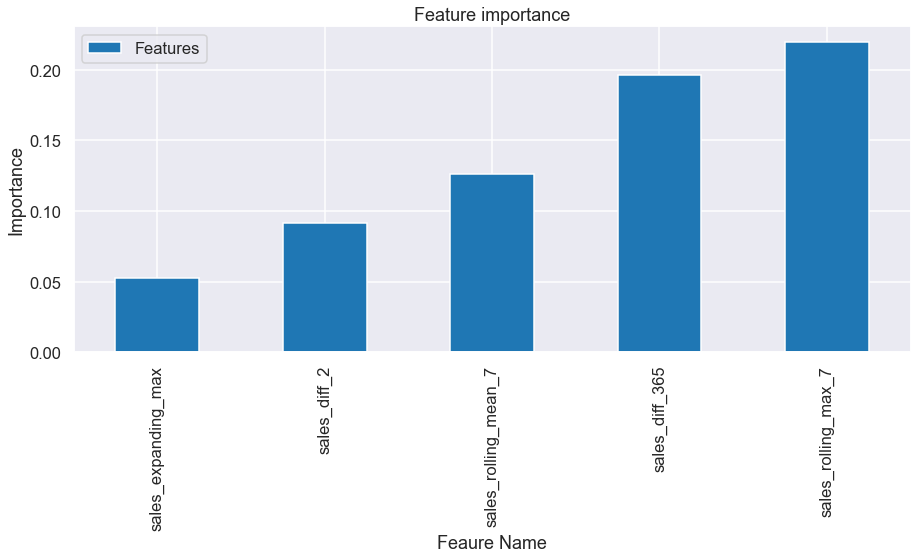

In [1073]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp =pd.DataFrame(data=np.abs(linear_model.coef_.T),index = X_train1.columns,columns=['Features']) 
fig, ax = plt.subplots(figsize=[24, 20])
tmp.sort_values(by=['Features']).tail(5).plot.bar(figsize=(15, 6),ax=ax)
ax.set_title("Feature importance")
ax.set_xlabel("Feaure Name")
ax.set_ylabel("Importance");
#plt.title("Feature importance")
#plt.ylabel("Importance")

In [1074]:
gc.collect()

0

In [1075]:
#tmp.sort_values(by=['Features'])

# 17a. ML Time series forecasting using XGBOOST - one step

In [1076]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=5000,
                           early_stopping_rounds=50,
                           objective='reg:tweedie',
                           max_depth=5,
                           learning_rate=0.01)

In [1077]:
 reg.fit(X_train1, y_train,
            eval_set=[(X_train1, y_train), (X_test1, y_test)],
            verbose=100)

[0]	validation_0-tweedie-nloglik@1.5:7.51748	validation_1-tweedie-nloglik@1.5:7.71552
[100]	validation_0-tweedie-nloglik@1.5:4.65492	validation_1-tweedie-nloglik@1.5:4.96635
[200]	validation_0-tweedie-nloglik@1.5:3.93577	validation_1-tweedie-nloglik@1.5:4.30604
[300]	validation_0-tweedie-nloglik@1.5:3.75415	validation_1-tweedie-nloglik@1.5:4.14752
[400]	validation_0-tweedie-nloglik@1.5:3.68249	validation_1-tweedie-nloglik@1.5:4.07563
[500]	validation_0-tweedie-nloglik@1.5:3.65145	validation_1-tweedie-nloglik@1.5:4.04242
[600]	validation_0-tweedie-nloglik@1.5:3.63274	validation_1-tweedie-nloglik@1.5:4.02160
[700]	validation_0-tweedie-nloglik@1.5:3.62247	validation_1-tweedie-nloglik@1.5:4.00995
[800]	validation_0-tweedie-nloglik@1.5:3.61453	validation_1-tweedie-nloglik@1.5:4.00136
[900]	validation_0-tweedie-nloglik@1.5:3.60776	validation_1-tweedie-nloglik@1.5:3.99391
[1000]	validation_0-tweedie-nloglik@1.5:3.60259	validation_1-tweedie-nloglik@1.5:3.98773
[1100]	validation_0-tweedie-nlogl

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=0,
             num_parallel_tree=1, objective='reg:tweedie', predictor='auto', ...)

In [1078]:
gc.collect()

44

In [1079]:
def roundToHalf(array):
   return np.around(array * 2.0) / 2.0

In [1080]:
y_pred = roundToHalf(reg.predict(X_test1))

In [1081]:
#mape(yval,y_pred)

In [1082]:
print("train rmse: ", mean_squared_error(
    y_test, y_pred))

train rmse:  0.10745073891625616


In [1083]:
df_result = pd.DataFrame(columns = ['y_test', 'y_pred'])

df_result['y_test']=y_test
df_result['y_pred'] = y_pred

df_result

y_test  y_pred
date                      
2016-04-25     1.0     1.0
2016-04-26     0.0     0.0
2016-04-27     1.0     1.0
2016-04-28     1.0     1.0
2016-04-29     2.0     2.0
...            ...     ...
2016-05-18     1.0     1.0
2016-05-19     0.0     0.0
2016-05-20     1.0     1.0
2016-05-21     0.0     0.0
2016-05-22     0.0     0.0

[812 rows x 2 columns]

In [1084]:
df_result['Error']=df_result['y_test']-df_result['y_pred']

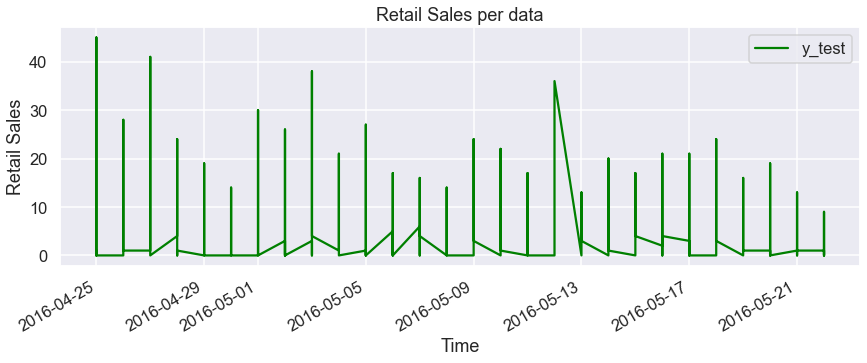

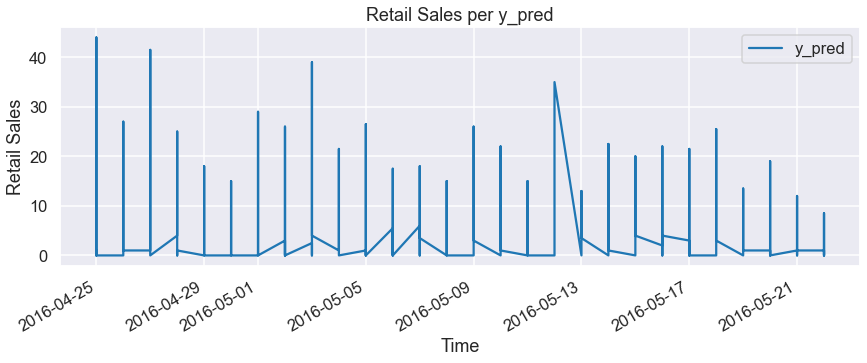

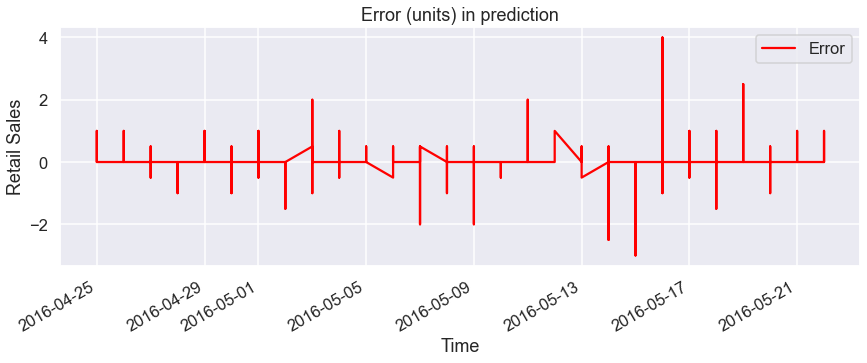

In [1085]:
fig, ax = plt.subplots(figsize=[12, 5])
df_result.plot(y="y_test",ax=ax,color="green")
ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")
ax.set_title("Retail Sales per data")
plt.tight_layout()

fig, ax = plt.subplots(figsize=[12, 5])
df_result.plot(y="y_pred",ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")
ax.set_title("Retail Sales per y_pred")
plt.tight_layout()

fig, ax = plt.subplots(figsize=[12, 5])
df_result.plot(y="Error",ax=ax,color="red")
ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")
ax.set_title("Error (units) in prediction")
plt.tight_layout()

In [1086]:
gc.collect()

9251

In [1087]:
wmape(y_test, y_pred)

0.03428414701042238

## # 17.b ML Time series forecasting Lasso  - Direct forecast of the next 28 days

In [1088]:
# The first hour of forecast.

data_start = pd.Timestamp("2016-04-24")

In [1089]:
# The last hour of forecast (24hs before the last
# timestamp in the test set).

data_end = data_start+pd.DateOffset(days=28)

data_end

Timestamp('2016-05-22 00:00:00')

In [1090]:
#start_point = forecast_point - pd.DateOffset(days=1)

In [1091]:
# Each one of the forecasting start points.

forecasting_points = pd.date_range(start=data_start, end=data_end, freq="D")

print(len(forecasting_points))

forecasting_points

29


DatetimeIndex(['2016-04-24', '2016-04-25', '2016-04-26', '2016-04-27',
               '2016-04-28', '2016-04-29', '2016-04-30', '2016-05-01',
               '2016-05-02', '2016-05-03', '2016-05-04', '2016-05-05',
               '2016-05-06', '2016-05-07', '2016-05-08', '2016-05-09',
               '2016-05-10', '2016-05-11', '2016-05-12', '2016-05-13',
               '2016-05-14', '2016-05-15', '2016-05-16', '2016-05-17',
               '2016-05-18', '2016-05-19', '2016-05-20', '2016-05-21',
               '2016-05-22'],
              dtype='datetime64[ns]', freq='D')

In [1092]:
for forecast_point in forecasting_points:
    forecast_end = forecast_point + pd.DateOffset(days=1)
    #print(forecast_end)
    index = pd.date_range(start=forecast_point, end=forecast_end,freq="D")
    print(index)

DatetimeIndex(['2016-04-24', '2016-04-25'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-04-25', '2016-04-26'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-04-26', '2016-04-27'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-04-27', '2016-04-28'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-04-28', '2016-04-29'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-04-29', '2016-04-30'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-04-30', '2016-05-01'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-05-01', '2016-05-02'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-05-02', '2016-05-03'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-05-03', '2016-05-04'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-05-04', '2016-05-05'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-05-05', '2016-05-06'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-05-06', '2016-05-07'], dtype='datetime64[ns

In [1093]:
gc.collect()

0

In [1094]:
## Direct Approach for forecasting

## Prepare the target

In [1095]:
FCSTING3

date          item_id  unit_sales  snap_CA  Holidays  sell_price  \
366   2012-01-30      FOODS_1_002           0        0         0        8.88   
367   2012-01-31      FOODS_1_002           0        0         0        8.88   
368   2012-02-01      FOODS_1_002           0        1         0        8.88   
369   2012-02-02      FOODS_1_002           0        1         0        8.88   
370   2012-02-03      FOODS_1_002           0        1         0        8.88   
...          ...              ...         ...      ...       ...         ...   
56284 2016-05-18  HOUSEHOLD_2_345           0        0         0        5.84   
56285 2016-05-19  HOUSEHOLD_2_345           1        0         0        5.84   
56286 2016-05-20  HOUSEHOLD_2_345           0        0         0        5.84   
56287 2016-05-21  HOUSEHOLD_2_345           0        0         0        5.84   
56288 2016-05-22  HOUSEHOLD_2_345           1        0         0        5.84   

      Inventory_class  date_day_of_year  date_week  date_month  ...  \
366                 B                30          5           1  ...   
367                 B                31          5           1  ...   
368                 B                32          5           2  ...   
369                 B                33          5           2  ...   
370                 B                34          5           2  ...   
...               ...               ...        ...         ...  ...   
56284               C               139         20           5  ...   
56285               C               140         20           5  ...   
56286               C               141         20           5  ...   
56287               C               142         20           5  ...   
56288               C               143         20           5  ...   

       sales_rolling_max_28  sales_rolling_min_28  sales_diff_1  sales_diff_2  \
366                     3.0                   0.0           0.0           0.0   
367                     3.0                   0.0           0.0           0.0   
368                     3.0                   0.0           0.0           0.0   
369                     3.0                   0.0           0.0           0.0   
370                     3.0                   0.0           0.0           0.0   
...                     ...                   ...           ...           ...   
56284                   2.0                   0.0           1.0           1.0   
56285                   2.0                   0.0          -1.0           0.0   
56286                   2.0                   0.0           1.0           0.0   
56287                   2.0                   0.0          -1.0           0.0   
56288                   2.0                   0.0           0.0          -1.0   

       sales_diff_7  sales_diff_365  sales_expanding_mean  \
366             0.0            -1.0              0.344262   
367            -1.0             0.0              0.343324   
368             0.0            -1.0              0.342391   
369             0.0            -2.0              0.341463   
370             0.0             0.0              0.340541   
...             ...             ...                   ...   
56284           1.0            -1.0              0.251033   
56285           0.0             0.0              0.250903   
56286           1.0             1.0              0.251290   
56287           0.0             0.0              0.251160   
56288           0.0             0.0              0.251031   

       sales_expanding_std  sales_expanding_max  sales_expanding_min  
366               0.687706                  5.0                  0.0  
367               0.687001                  5.0                  0.0  
368               0.686298                  5.0                  0.0  
369               0.685596                  5.0                  0.0  
370               0.684897                  5.0                  0.0  
...                    ...                  ...                  .

In [1096]:
y_multi=FCSTING3[[v for v in FCSTING3.columns if "lag" in v]]

In [1097]:
mylist ={'date','lag',}
pattern = '|'.join(mylist)
pattern

'lag|date'

In [1098]:
FCSTING3.columns[FCSTING3.columns.str.contains('date_', case=False)]

Index(['date_day_of_year', 'date_week', 'date_month', 'date_quarter',
       'date_year', 'date_day_of_week', 'date_day_of_month',
       'date_day_of_year_sin', 'date_day_of_year_cos', 'date_week_sin',
       'date_week_cos', 'date_month_sin', 'date_month_cos', 'date_quarter_sin',
       'date_quarter_cos', 'date_year_sin', 'date_year_cos',
       'date_day_of_week_sin', 'date_day_of_week_cos', 'date_day_of_month_sin',
       'date_day_of_month_cos'],
      dtype='object')

In [1099]:
y_multi=FCSTING3[FCSTING3.columns[FCSTING3.columns.str.contains(pattern)]].\
drop(FCSTING3.columns[FCSTING3.columns.str.contains('date_', case=False)],axis=1)

In [1100]:
y_train_multi = y_multi[y_multi.date <= "2016-04-24"].drop('date',axis=1)
y_test_multi = y_multi[y_multi.date > "2016-04-24"].drop('date',axis=1)

In [1101]:
y_multi

date  sales_lag_1  sales_lag_2  sales_lag_3  sales_lag_4  \
366   2012-01-30          0.0          0.0          0.0          0.0   
367   2012-01-31          0.0          0.0          0.0          0.0   
368   2012-02-01          0.0          0.0          0.0          0.0   
369   2012-02-02          0.0          0.0          0.0          0.0   
370   2012-02-03          0.0          0.0          0.0          0.0   
...          ...          ...          ...          ...          ...   
56284 2016-05-18          1.0          0.0          0.0          0.0   
56285 2016-05-19          0.0          1.0          0.0          0.0   
56286 2016-05-20          1.0          0.0          1.0          0.0   
56287 2016-05-21          0.0          1.0          0.0          1.0   
56288 2016-05-22          0.0          0.0          1.0          0.0   

       sales_lag_5  sales_lag_6  sales_lag_7  sales_lag_8  sales_lag_9  ...  \
366            0.0          0.0          1.0          0.0          0.0  ...   
367            0.0          0.0          0.0          1.0          0.0  ...   
368            0.0          0.0          0.0          0.0          1.0  ...   
369            0.0          0.0          0.0          0.0          0.0  ...   
370            0.0          0.0          0.0          0.0          0.0  ...   
...            ...          ...          ...          ...          ...  ...   
56284          0.0          0.0          0.0          0.0          0.0  ...   
56285          0.0          0.0          0.0          0.0          0.0  ...   
56286          0.0          0.0          0.0          0.0          0.0  ...   
56287          0.0          0.0          0.0          0.0          0.0  ...   
56288          1.0          0.0          0.0          0.0          0.0  ...   

       sales_lag_19  sales_lag_20  sales_lag_21  sales_lag_22  sales_lag_23  \
366             0.0           0.0           2.0           0.0           0.0   
367             0.0           0.0           0.0           2.0           0.0   
368             3.0           0.0           0.0           0.0           2.0   
369             1.0           3.0           0.0           0.0           0.0   
370             0.0           1.0           3.0           0.0           0.0   
...             ...           ...           ...           ...           ...   
56284           2.0           0.0           0.0           0.0           0.0   
56285           1.0           2.0           0.0           0.0           0.0   
56286           0.0           1.0           2.0           0.0           0.0   
56287           0.0           0.0           1.0           2.0           0.0   
56288           0.0           0.0           0.0           1.0           2.0   

       sales_lag_24  sales_lag_25  sales_lag_26  sales_lag_27  sales_lag_28  
366             0.0           0.0           0.0           1.0           0.0  
367             0.0           0.0           0.0           0.0           1.0  
368             0.0           0.0           0.0           0.0           0.0  
369             2.0           0.0           0.0           0.0           0.0  
370             0.0           2.0           0.0           0.0           0.0  
...             ...           ...           ...           ...           ...  
56284           0.0           0.0           0.0           0.0           0.0  
56285           0.0           0.0           0.0           0.0           0.0  
56286           0.0           0.0           0.0           0.0           0.0  
56287           0.0           0.0           0.0           0.0           0.0  
56288           0.0           0.0           0.0           0.0           0.0  

[41817 rows x 29 columns]

In [1102]:
gc.collect()

0

In [1103]:
lasso = MultiOutputRegressor(Lasso(random_state=0, max_iter=50000))

In [1104]:
lasso.fit(X_train1, y_train_multi)

MultiOutputRegressor(estimator=Lasso(max_iter=50000, random_state=0))

In [1105]:
# Make predictions

preds_28 = roundToHalf(np.abs(lasso.predict(X_test1)))

In [1106]:
preds_28 = pd.DataFrame(preds_28, columns=y_test_multi.columns)

preds_28 

sales_lag_1  sales_lag_2  sales_lag_3  sales_lag_4  sales_lag_5  \
0            1.0          1.0          0.0          0.0          1.0   
1            0.0          1.0          1.0          0.0          0.0   
2            1.0          0.0          1.0          1.0          0.0   
3            1.0          1.0          0.0          1.0          1.0   
4            2.0          1.0          1.0          0.0          1.0   
..           ...          ...          ...          ...          ...   
807          1.0          0.0          0.0          0.0          0.0   
808          0.0          1.0          0.0          0.0          0.0   
809          1.0          0.0          1.0          0.0          0.0   
810          0.0          1.0          0.0          1.0          0.0   
811          0.0          0.0          1.0          0.0          1.0   

     sales_lag_6  sales_lag_7  sales_lag_8  sales_lag_9  sales_lag_10  ...  \
0            0.0          0.0          1.0          0.0           1.0  ...   
1            1.0          0.0          0.0          1.0           0.0  ...   
2            0.0          1.0          0.0          0.0           1.0  ...   
3            0.0          0.0          1.0          0.0           0.0  ...   
4            1.0          0.0          0.0          1.0           0.0  ...   
..           ...          ...          ...          ...           ...  ...   
807          0.0          0.0          0.0          0.0           2.0  ...   
808          0.0          0.0          0.0          0.0           0.0  ...   
809          0.0          0.0          0.0          0.0           0.0  ...   
810          0.0          0.0          0.0          0.0           0.0  ...   
811          0.0          0.0          0.0          0.0           0.0  ...   

     sales_lag_19  sales_lag_20  sales_lag_21  sales_lag_22  sales_lag_23  \
0             0.0           0.0           1.0           0.0           0.0   
1             0.0           0.0           0.0           1.0           0.0   
2             1.0           0.0           0.0           0.0           1.0   
3             0.0           1.0           0.0           0.0           0.0   
4             1.0           0.0           1.0           0.0           0.0   
..            ...           ...           ...           ...           ...   
807           2.0           0.0           0.0           0.0           0.0   
808           1.0           2.0           0.0           0.0           0.0   
809           0.0           1.0           2.0           0.0           0.0   
810           0.0           0.0           1.0           2.0           0.0   
811           0.0           0.0           0.0           1.0           2.0   

     sales_lag_24  sales_lag_25  sales_lag_26  sales_lag_27  sales_lag_28  
0             0.0           0.0           0.0           1.0           0.0  
1             0.0           0.0           0.0           0.0           1.0  
2             0.0           0.0           0.0           0.0           0.0  
3             1.0           0.0           0.0           0.0           0.0  
4             0.0           1.0           0.0           0.0           0.0  
..            ...           ...           ...           ...           ...  
807           0.0           0.0           0.0           0.0           0.0  
808           0.0           0.0           0.0           0.0           0.0  
809           0.0           0.0           0.0           0.0           0.0  
810           0.0           0.0           0.0           0.0           0.0  
811           0.0           0.0           0.0           0.0           0.0  

[812 rows x 28 columns]

In [1108]:
# The RMSE in the train set.

for h in range(horizon):
    rmse = mean_squared_error(preds_28[f"sales_lag_{h+1}"], y_test_multi[f"sales_lag_{h+1}"], squared=False)
    print(f"for horizon {h+1} got rmse: {rmse} ")

for horizon 1 got rmse: 0.46390662811163985 
for horizon 2 got rmse: 0.1710227133245944 
for horizon 3 got rmse: 0.17634074717234385 
for horizon 4 got rmse: 0.17894050529015934 
for horizon 5 got rmse: 0.17979873805701907 
for horizon 6 got rmse: 0.18234920215644926 
for horizon 7 got rmse: 0.18402987549278957 
for horizon 8 got rmse: 0.19695964928958384 
for horizon 9 got rmse: 0.19380809156142012 
for horizon 10 got rmse: 0.19851666679418606 
for horizon 11 got rmse: 0.19851666679418606 
for horizon 12 got rmse: 0.19617650642948264 
for horizon 13 got rmse: 0.19929061384940563 
for horizon 14 got rmse: 0.2083538577738869 
for horizon 15 got rmse: 0.2149005956479698 
for horizon 16 got rmse: 0.22607161339769408 
for horizon 17 got rmse: 0.22877915437782462 
for horizon 18 got rmse: 0.22877915437782462 
for horizon 19 got rmse: 0.22675152955963818 
for horizon 20 got rmse: 0.22810528206166883 
for horizon 21 got rmse: 0.22194838080923765 
for horizon 22 got rmse: 0.23145502494313785 


In [ ]:
gc.collect()